# Purpose of this Collab

The goal of this collab is to create a custom way of creating and using Multi-Layer Perceptrons (MLP) using linear algebra, calculus and numpy. By doing so, a more comprehensive approach to understanding the mechanism of Neural Networks is followed in order not to use them as a 'Black Box'.

The networks created are Fully Connected, while there was an effort of creating Convolutional Layers. Due to memory issues (related to RAM and possible leakage) and time neeeded, the Convolutional Layers were not implemented (the starting code is here but is not working as expected).

Finally, numerous experiments that simulate grid search were implemented in the effort of creating a model that could maximize the predictive power of the created networks.

In [ ]:
import numpy as np
import argparse
from sklearn.metrics import *
from matplotlib import pyplot as plt
import math
import pandas as pd
import time
from keras.datasets import cifar10,mnist
import keras

In [ ]:
# Downloading the dataset (CIFAR-10) using keras datasets
def load_dataset():
 # load dataset
 (X_train,y_train),(X_test,y_test) = cifar10.load_data()
 return X_train,y_train,X_test,y_test

In [ ]:
# Initial Exploration of the dataset and its dimensions
X_train,y_train,X_test,y_test =  load_dataset()
print("The shape of X_train is :",X_train.shape)
print("The shape of y_train is :",y_train.shape)

print("The shape of X_test is :",X_test.shape)
print("The shape of y_test is :",y_test.shape)

print("The number of unique classes is:",len(np.unique(y_train)))

labels =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Class Names are:",labels)

170498071/170498071 [==============================] - 11s 0us/step
The shape of X_train is : (50000, 32, 32, 3)
The shape of y_train is : (50000, 1)
The shape of X_test is : (10000, 32, 32, 3)
The shape of y_test is : (10000, 1)
The number of unique classes is: 10
Class Names are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


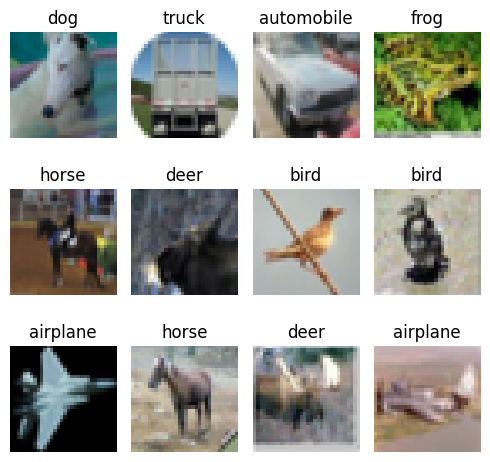

In [ ]:
# Display the images to get a better visual understanding of the dataset
import random

# Number of images to display
num_images_to_display = 12

# Create a random list of indices - to display random images of the dataset each time
random_indices = random.sample(range(len(X_train)), num_images_to_display)

# Create a grid layout for displaying images
rows = 3  # Number of rows of grid
cols = 4  # Number of columns of grid

# Create a figure for the grid
fig, axes = plt.subplots(rows, cols, figsize=(5, 5))

# Loop through the grid and display the images
for i in range(rows):
    for j in range(cols):
        index = random_indices[i * cols + j]
        ax = axes[i, j]
        ax.imshow(X_train[index], cmap=plt.cm.binary)
        ax.axis('off')

        # Get the label for the current image
        label_index = y_train[index, 0]

        ax.set_title(labels[label_index])

plt.tight_layout()
plt.show()

In [ ]:
# Checking how a single image is represented in the dataset
print("X_train",X_train[0:1,:])
print("y_train",y_train[0:1,:])

X_train [[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]]
y_train [[6]]


In [ ]:
# We know that the pixels in each image is between no colour and full color and thus [0,255]
# We also know that normalization can help neural networks
def normalization_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

X_train, X_test = normalization_pixels(X_train,X_test)

In [ ]:
# Check the results of Normalization
print("Maximum of Normalized Data(X_train):",np.max(X_train))
print("Minimum of Normalized Data(X_train):",np.min(X_train))
print("Maximum of Normalized Data(X_test):",np.max(X_test))
print("Minimum of Normalized Data(X_test):",np.min(X_test))

Maximum of Normalized Data(X_train): 1.0
Minimum of Normalized Data(X_train): 0.0
Maximum of Normalized Data(X_test): 1.0
Minimum of Normalized Data(X_test): 0.0


In [ ]:
# Reshape the X_train and X_test data to 2D arrays
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

print("New Dimensions of X_train are:",X_train_2d.shape)
print("New Dimensions of X_test are:",X_test_2d.shape)

New Dimensions of X_train are: (50000, 3072)
New Dimensions of X_test are: (10000, 3072)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Function to calculate and print different classification metrics for comparison of our models
def evaluate_classification_metrics(y_true, y_pred,verbose=True):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, and F1-score for all unique labels
    precision = precision_score(y_true, y_pred,zero_division=0, average='weighted')
    recall = recall_score(y_true, y_pred,zero_division=0, average='weighted')
    f1 = f1_score(y_true, y_pred,zero_division=0,average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Generate a classification report
    class_report = classification_report(y_true, y_pred, zero_division=0)
    if verbose:
      print(f'\tAccuracy: {accuracy}')
      print(f'\tPrecision Weighted: {precision}')
      print(f'\tRecall Weighted: {recall}')
      print(f'\tF1-Score Weighted: {f1}')

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

In [ ]:
# Preprocess target labels for our neural networks by performing one hot encoding
def preprocess_labels(y_train,y_test,number_of_classes):
  # one hot encode target values
  y_train = keras.utils.to_categorical(y_train,num_classes=number_of_classes)
  y_test = keras.utils.to_categorical(y_test,num_classes=number_of_classes)
  return y_train,y_test

y_train_onehot,y_test_onehot = preprocess_labels(y_train,y_test,len(labels))
print("Shape of one-hot-encoded y_train: ",y_train_onehot.shape)

Shape of one-hot-encoded y_train:  (50000, 10)


In the following cell, a object oriented approach to create generic classes that could be used for creating a Fully Connencted Neural Network. The implementation was based on the Linear Algebra taught in class and found in web articles and videos, expecially in backpropagation. The implementation was created in a way to be easy to create a model and to remind of the usual frameworks used such as Pytorch and Keras.

The final implementation is a result of a trial and error process, and investigating each layer individually.

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import time
from tqdm import tqdm

# a generic class which every other component that is consider a layer will inherit
# the creation of this class will make sure that its layer of the NN that will be
# created will have the basic functions for forward and backward passing of the layer

# global constant variable
epsilon = 1e-9

class Layer():
    def __init__(self):
      self.input = None
      self.output = None

    def forward(self,input):
      pass

    def backward(self,output_gradient):
      pass

class Dense_Layer(Layer):
    def __init__(self, n_inputs, n_neurons):
        super().__init__()
        # n_inputs is the dimension of each example
        self.weights = np.random.randn(n_inputs, n_neurons) # n_neurons is also the output size
        self.biases = np.random.randn(1,n_neurons)
        self.dweights = None
        self.dbiases = None

    def forward(self, inputs):
        self.input = inputs
        # calculate the output of the layer
        self.output = np.dot(self.input, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        # calculate the derivatives with respect to the parameters
        self.dweights = np.dot(self.input.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # calculate the derivatives with respect to the inputs
        self.dvalues = np.dot(dvalues, self.weights.T)
        # return the derivatives with respect to the inputs
        return self.dvalues

class Activation_ReLU(Layer):
  # class for the activation function "Rectified Linear Unit(ReLU)"
    def forward(self, inputs):
        self.input = inputs
        # implementation of ReLU's output
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dvalues = dvalues.copy()
        self.dvalues[self.input <= 0] = 0
        # one of the following implementation can be added as seen in bibliographic sources to prevent a phenomenon called "dying ReLU"
        self.dvalues[self.input > 0] +=epsilon
        #self.dvalues[self.input > 0] = 1
        return self.dvalues


class Activation_Sigmoid(Layer):
    def forward(self, inputs):
        self.input = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        self.dvalues = dvalues * (1 - self.output) * self.output
        return self.dvalues

class Activation_Tanh(Layer):
    def forward(self, inputs):
        self.input = inputs
        self.output = np.tanh(inputs)
        return self.output

    def backward(self, dvalues):
        self.dvalues = dvalues * (1 - np.square(self.output))
        return self.dvalues

class Activation_Softmax(Layer):
    def forward(self, inputs):
        # calculating the forward pass of Softmax
        # using the "max trick" to deal with a possible instability due to very large numbers
        # now the max will be -> e^0 = 1 and thus the number will be in [0,1] -> invariant to scaling
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

        return self.output

    def backward(self, dvalues):
      # Create an empty array to store the gradient with respect to inputs
      self.dvalues = np.empty_like(dvalues)

      # Number of samples in the batch
      samples = len(dvalues)

      # Loop through the samples
      for i in range(samples):
          # Get the output probabilities for the current sample as a column vector
          softmax_output = self.output[i].reshape(-1, 1)

          # Calculate the Jacobian matrix of the softmax
          # Jacobian(s) = diag(s) - s*transpose(s)
          jacobian_matrix = np.diagflat(softmax_output) - np.dot(softmax_output, softmax_output.T) # could use np.outer as well

          # Calculate the gradient for the current sample by using the dot product of the jacobian matrix (dsoftmax/dxi)
          # and the (dL/dsoftmax) which is stored in dvalues
          self.dvalues[i] = np.dot(jacobian_matrix, dvalues[i])
      # The gradient returned here is used to update the previous layer in the network
      return self.dvalues


# A generic class that will need some class to inherit it, in order to base the
# Loss calculation on a specific formula
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        # Clipping the y_pred between [1e-7,1-e-7]
        # to avoid values too close to 1 or 0 that may lead to numerical instability
        # or infinity in the log calculation
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        # This operation will result in an array where all elements are zero,
        # except for the element corresponding to the correct class since the y_true
        # variable is one-hot encoded
        correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences + epsilon)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        # calculating the derivative of the ouput probablities with respect
        # to the output of the previous softmax layer
        #self.dvalues = (dvalues - y_true) / samples
        self.dvalues = -(1/samples)*(y_true/(dvalues+epsilon))
        return self.dvalues

# A dropout layer class that could be used to add some randomness to the process
# in order to avoid overfitting
class Dropout_Layer(Layer):
    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, inputs, training=True):
        if training:
            # Generate a binary mask where values are set to 1 with probability (1 - dropout_rate)
            # Perform also scaling that helps to maintain the expected value of the output
            self.mask = (np.random.rand(*inputs.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
            # Apply the mask to the inputs during training
            self.output = inputs * self.mask
        else:
            # During inference, scale the inputs by (1 - dropout_rate)
            self.output = inputs * (1.0 - self.dropout_rate)
        return self.output

    def backward(self, dvalues):
        # Backward pass through the dropout layer
        self.dvalues = dvalues * self.mask # This line makes sure that only the values that survived dropout during the forward pass contribute to the gradient during backpropagation.
        return self.dvalues

# class for initiliazing an architecture of an NN
class NeuralNetwork:
    def __init__(self,learning_rate=0.01):
        self.components = []
        self.learning_rate = learning_rate
        self.loss_history_train = []
        self.accuracy_history_train = []
        self.loss_history_test = []
        self.accuracy_history_test = []

    # Adding components(Layers) to the Neural Network
    def add_component(self, component):
        self.components.append(component)

    # Calculate the output of the Neural Network
    def forward(self, X):
        for component in self.components:
            # Calling the forward method of all components(Layers)
            X = component.forward(X)
        return X

    def train(self, X_train, y_train,X_test,y_test, epochs,verbose=True):
        self.loss = Loss_CategoricalCrossEntropy()
        # Create a tqdm instance outside the loop to add a progress bar
        progress_bar = tqdm(total=epochs, desc="Processing", unit="epoch",position=0)
        for epoch in range(epochs):
            # Calculating the output of the NN
            output = self.forward(X_train)
            # Calculating Loss
            data_loss = self.loss.calculate(output, y_train)
            loss = data_loss
            # Starting the Learning by calculating the
            # the gradients
            loss_gradients = self.loss.backward(output, y_train)
            for component in reversed(self.components):
                loss_gradients = component.backward(loss_gradients)

            for component in self.components:
              # The Dense Layers will update their weights here
              if isinstance(component, Dense_Layer):
                  component.weights -= self.learning_rate * component.dweights
                  component.biases -= self.learning_rate * component.dbiases

            # Track training loss and accuracy
            self.loss_history_train.append(loss)
            predictions_train = np.argmax(output, axis=1)
            accuracy_train = accuracy_score(np.argmax(y_train, axis=1), predictions_train)
            self.accuracy_history_train.append(accuracy_train)
            # Testing
            output_test = self.forward(X_test)
            data_loss_test = self.loss.calculate(output_test, y_test)
            loss_test = data_loss_test

            # Track test loss and accuracy
            self.loss_history_test.append(loss_test)
            predictions_test = np.argmax(output_test, axis=1)
            accuracy_test = accuracy_score(np.argmax(y_test, axis=1), predictions_test)
            self.accuracy_history_test.append(accuracy_test)

            if verbose:
              print(f'Epoch {epoch}, loss: {loss}')
            progress_bar.update(1)

        progress_bar.close()
        # Plot loss and accuracy after training
        self.plot_loss_accuracy()

    def predict(self, X, num_of_classes):
      output = self.forward(X)
      predictions = np.argmax(output, axis=1,keepdims=True)
      onehot_predictions = keras.utils.to_categorical(predictions, num_classes=num_of_classes)
      return onehot_predictions

    def plot_loss_accuracy(self):
      epochs = range(1, len(self.loss_history_train) + 1)

      # Plotting training loss
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 2, 1)
      plt.plot(epochs, self.loss_history_train, label='Training Loss', marker='o')
      plt.plot(epochs, self.loss_history_test, label='Test Loss', marker='o')
      plt.title('Training and Test Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      # Plotting training accuracy
      plt.subplot(1, 2, 2)
      plt.plot(epochs, self.accuracy_history_train, label='Training Accuracy', marker='o')
      plt.plot(epochs, self.accuracy_history_test, label='Test Accuracy', marker='o', color='orange')
      plt.title('Training and Test Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()

      plt.show()

# Class to perform Cross-Validation
class NeuralNetwork_CrossValidator():
    def __init__(self, components,num_of_classes, k_folds=5, epochs=15,learning_rate = 0.1):
        self.components = components
        self.num_of_classes = num_of_classes
        self.k_folds = k_folds
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.losses = []
        self.metrics = []
        self.network  = None

    def fit_and_cross_validate(self, X, y):
        skf = StratifiedKFold(n_splits=self.k_folds,shuffle=True)
        class_labels = np.argmax(y, axis=1)  # Convert one-hot encoded labels to class labels which is needed in .split() method

        for fold, (train_index, val_index) in enumerate(skf.split(X, class_labels)):
            print(f'\tFold: {fold}/{self.k_folds}')
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            self.network = NeuralNetwork(learning_rate = self.learning_rate)

            for component in self.components:
                self.network.add_component(component)
            self.network.train(X_train, y_train, epochs=self.epochs, verbose=True)

            network_predictions = self.network.predict(X_val,self.num_of_classes)

            # The function I implemented using scikit-learn libraries needs not one hot encoded labels
            network_predictions_flatten = np.argmax(network_predictions, axis=1)
            y_val_flatten = np.argmax(y_val, axis=1)
            metrics = evaluate_classification_metrics(y_val_flatten,network_predictions_flatten,False)
            self.metrics.append(metrics)
            final_loss = self.network.loss.calculate(network_predictions, y_val)
            self.losses.append(final_loss)

In [ ]:
'''
np.random.seed(0)

# Get the dimensions of the data
input_dimension = X_train_2d_pca.shape[1]
output_dimension = y_train_onehot.shape[1]

# Create the neural network
network = NeuralNetwork(learning_rate = 0.1)
network.add_component(Dense_Layer(input_dimension, 128))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(128,128))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(128,32))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(32, output_dimension))
network.add_component(Activation_Softmax())
# Train the neural network
network.train(X_train_2d_pca, y_train_onehot, epochs=50,verbose = True)
# After training, you can use the network for predictions
predictions = network.predict(X_test_2d_pca, output_dimension)
# Evaluate the accuracy of the trained model
predictions_flatten = np.argmax(predictions, axis=1)
y_val_flatten = np.argmax(y_test_onehot, axis=1)
metrics = evaluate_classification_metrics(y_val_flatten,predictions_flatten,False)
metrics
'''

'\nnp.random.seed(0)\n# Get the dimensions of the data\ninput_dimension = X_train_2d_pca.shape[1]\noutput_dimension = y_train_onehot.shape[1]\n\n# Create the neural network\nnetwork = NeuralNetwork(learning_rate = 0.1)\nnetwork.add_component(Dense_Layer(input_dimension, 128))\nnetwork.add_component(Activation_ReLU())\nnetwork.add_component(Dense_Layer(128,128))\nnetwork.add_component(Activation_ReLU())\nnetwork.add_component(Dense_Layer(128,32))\nnetwork.add_component(Activation_ReLU())\nnetwork.add_component(Dense_Layer(32, output_dimension))\nnetwork.add_component(Activation_Softmax())\n# Train the neural network\nnetwork.train(X_train_2d_pca, y_train_onehot, epochs=50,verbose = True)\n# After training, you can use the network for predictions\npredictions = network.predict(X_test_2d_pca, output_dimension)\n# Evaluate the accuracy of the trained model\npredictions_flatten = np.argmax(predictions, axis=1)\ny_val_flatten = np.argmax(y_test_onehot, axis=1)\nmetrics = evaluate_classificat

In [ ]:
'''
Checking on MNIST to evaluate if the architecture is learning
(X_train, y_train), (X_test, y_test)  = mnist.load_data()
y_train_onehot,y_test_onehot = preprocess_labels(y_train,y_test,10)
print("Shape of one-hot-encoded y_train: ",y_train_onehot.shape)
X_train, X_test = normalization_pixels(X_train,X_test)
# Reshape the X_train and X_test data to 2D arrays
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

print("New Dimensions of X_train are:",X_train_2d.shape)
print("New Dimensions of X_test are:",X_test_2d.shape)
'''

from sklearn.decomposition import PCA
# Implement Feature Selection Using PCA in the 2D Feature Array
def feature_selection_pca(X_train,X_test):
  # Select the number of features of the dataset, in our dataset it is pixels, that explain 95% of the variance
  pca = PCA(n_components=0.95,svd_solver='auto',tol=0.0,random_state=None)
  # Fitting and Transforming the training and the testing to reduce the dimensionality of both datasets
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)
  return X_train_pca,X_test_pca

X_train_2d_pca,X_test_2d_pca = feature_selection_pca(X_train_2d,X_test_2d)

In [ ]:
def experiment_with_architectures(X_train, y_train, X_test, y_test, layer_sizes_list, activation_functions_list, k_folds=5, epochs_list = [10,20], learning_rate=0.1):
    results = []

    number_of_architectures = len(layer_sizes_list)

    for iteration in range(0,number_of_architectures):
            for epochs in epochs_list:
              layer_sizes = layer_sizes_list[iteration]
              activation_functions = activation_functions_list[iteration]
              architecture = []

              # Add input layer
              architecture.append(Dense_Layer(X_train.shape[1], layer_sizes[0]))
              architecture.append(activation_functions[0])

              # Add hidden layers
              if len(layer_sizes) > 1: # if we have more than 1 layer
                for i in range(1, len(layer_sizes)):
                    architecture.append(Dense_Layer(layer_sizes[i-1], layer_sizes[i]))
                    architecture.append(activation_functions[i])

              # Output layer (Softmax)
              architecture.append(Dense_Layer(layer_sizes[-1], y_train.shape[1]))
              architecture.append(Activation_Softmax())

              # Create and train the neural network
              cross_validator = NeuralNetwork_CrossValidator(
                  components=architecture,
                  num_of_classes=y_train.shape[1],
                  k_folds=k_folds,
                  epochs=epochs,
                  learning_rate=learning_rate
              )

              time1 = time.time()
              # Performing Cross Validation
              cross_validator.fit_and_cross_validate(X_train, y_train)
              time2 = time.time()
              # Time Needed for training and cross validation
              training_validation_time = time2 - time1

              time3 = time.time()
              # Testing the model in unseen test data
              test_predictions = cross_validator.network.predict(X_test,cross_validator.num_of_classes)
              time4 = time.time()
              testing_time = time3 - time2
              # The function I implemented using scikit-learn libraries needs not one hot encoded labels
              test_predictions_flatten = np.argmax(test_predictions, axis=1)
              y_test_flatten = np.argmax(y_test, axis=1)
              test_metrics = evaluate_classification_metrics(y_test_flatten,test_predictions_flatten,False)

              # Calculate average accuracy and loss
              avg_accuracy = np.mean([metric['Accuracy'] for metric in cross_validator.metrics])
              avg_precision = np.mean([metric['Precision'] for metric in cross_validator.metrics])
              avg_recall = np.mean([metric['Recall'] for metric in cross_validator.metrics])
              avg_f1 = np.mean([metric['F1 Score'] for metric in cross_validator.metrics])
              avg_loss = np.mean(cross_validator.losses)

              results.append({
                  'Number of Layers': len(layer_sizes),
                  'Epochs': epochs,
                  'Layer Sizes': layer_sizes,
                  'Activation Functions': [activation.__class__.__name__ for activation in activation_functions] + ['Activation_Softmax'],
                  'Average CV Accuracy': avg_accuracy,
                  'Average CV Precision': avg_precision,
                  'Average CV Recall': avg_recall,
                  'Average CV F1-Score': avg_f1,
                  'Average CV Losses': avg_loss,
                  'Time for Training & CV':training_validation_time,
                  'Test Accuracy': test_metrics['Accuracy'],
                  'Test Precision': test_metrics['Precision'],
                  'Test Recall': test_metrics['Recall'],
                  'Test F1-Score': test_metrics['F1 Score'],
                  'Time for Testin': testing_time
              })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df

In [ ]:
'''
Experiment with Different Architectures
epochs_list = [50]
# The following Lists should be of the same size
layer_sizes_list = [
    [32, 16],
    [32, 16],
    [32, 16],
    [32, 64, 32],
    [32, 64, 32],
    [32, 64, 32],
    [64, 128, 128, 32]
]

activation_functions_list = [
    [Activation_ReLU(), Activation_ReLU()],
    [Activation_Sigmoid(),Activation_Sigmoid()],
    [Activation_Tanh(),Activation_Tanh()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
    [Activation_Sigmoid(),Activation_Sigmoid(),Activation_Sigmoid()],
    [Activation_Tanh(),Activation_Tanh(),Activation_Tanh()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
]

# Run experiments
experiment1_results = experiment_with_architectures(X_train_2d, y_train_onehot, X_test_2d, y_test_onehot, layer_sizes_list, activation_functions_list, k_folds=2, epochs_list, learning_rate=0.1)
#experiment_results.to_excel("Different_Layers_Exerimentation.xlsx")
experiment1_results
'''

In [ ]:
#Experiment with best Architectures so far and different hyperparameters
epochs_list = [50,75]

# Try for the same architecture different number of parameters
layer_sizes_list = [
    [128, 128, 128],
    [32, 64, 32],
    [64, 128, 64],
    [64, 64, 64]
]

activation_functions_list = [
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()]
]

# Run experiments with different Learning Rates
experiment4_1_results = experiment_with_architectures(X_train_2d, y_train_onehot, X_test_2d, y_test_onehot, layer_sizes_list, activation_functions_list, k_folds=2, epochs_list = epochs_list, learning_rate=0.1)
experiment4_2_results = experiment_with_architectures(X_train_2d, y_train_onehot, X_test_2d, y_test_onehot, layer_sizes_list, activation_functions_list, k_folds=2, epochs_list = epochs_list, learning_rate=0.01)


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:05<04:06,  5.04s/items]

Epoch 0, loss: 17.915917952188632


Processing:   4%|▍         | 2/50 [00:09<03:45,  4.71s/items]

Epoch 1, loss: 18.05462458203504


Processing:   6%|▌         | 3/50 [00:16<04:21,  5.57s/items]

Epoch 2, loss: 18.0311128144791


Processing:   8%|▊         | 4/50 [00:20<03:53,  5.07s/items]

Epoch 3, loss: 18.025494956289126


Processing:  10%|█         | 5/50 [00:24<03:40,  4.89s/items]

Epoch 4, loss: 18.025138323642963


Processing:  12%|█▏        | 6/50 [00:30<03:50,  5.25s/items]

Epoch 5, loss: 18.044637831475278


Processing:  14%|█▍        | 7/50 [00:35<03:32,  4.94s/items]

Epoch 6, loss: 18.02550438125531


Processing:  16%|█▌        | 8/50 [00:39<03:22,  4.82s/items]

Epoch 7, loss: 18.02835654604858


Processing:  18%|█▊        | 9/50 [00:46<03:40,  5.37s/items]

Epoch 8, loss: 18.028331972096606


Processing:  20%|██        | 10/50 [00:51<03:28,  5.21s/items]

Epoch 9, loss: 18.025504381255313


Processing:  22%|██▏       | 11/50 [00:56<03:20,  5.14s/items]

Epoch 10, loss: 18.025504381255313


Processing:  24%|██▍       | 12/50 [01:01<03:21,  5.30s/items]

Epoch 11, loss: 18.025504381255313


Processing:  26%|██▌       | 13/50 [01:06<03:05,  5.01s/items]

Epoch 12, loss: 18.0239019717628


Processing:  28%|██▊       | 14/50 [01:12<03:09,  5.25s/items]

Epoch 13, loss: 18.02550438125531


Processing:  30%|███       | 15/50 [01:17<03:05,  5.30s/items]

Epoch 14, loss: 18.02550438125531


Processing:  32%|███▏      | 16/50 [01:21<02:50,  5.01s/items]

Epoch 15, loss: 18.027106790747823


Processing:  34%|███▍      | 17/50 [01:27<02:47,  5.09s/items]

Epoch 16, loss: 18.027907995494076


Processing:  36%|███▌      | 18/50 [01:32<02:45,  5.19s/items]

Epoch 17, loss: 18.025504381255313


Processing:  38%|███▊      | 19/50 [01:36<02:32,  4.93s/items]

Epoch 18, loss: 18.025504381255313


Processing:  40%|████      | 20/50 [01:41<02:29,  4.98s/items]

Epoch 19, loss: 18.02710679156482


Processing:  42%|████▏     | 21/50 [01:47<02:29,  5.17s/items]

Epoch 20, loss: 18.028709200240332


Processing:  44%|████▍     | 22/50 [01:51<02:16,  4.89s/items]

Epoch 21, loss: 18.02790799549408


Processing:  46%|████▌     | 23/50 [01:56<02:10,  4.83s/items]

Epoch 22, loss: 18.028709200240336


Processing:  48%|████▊     | 24/50 [02:02<02:12,  5.10s/items]

Epoch 23, loss: 18.023921397548843


Processing:  50%|█████     | 25/50 [02:06<02:01,  4.86s/items]

Epoch 24, loss: 18.02330507809606


Processing:  52%|█████▏    | 26/50 [02:10<01:54,  4.76s/items]

Epoch 25, loss: 18.02630914594512


Processing:  54%|█████▍    | 27/50 [02:17<01:59,  5.20s/items]

Epoch 26, loss: 18.024486080588645


Processing:  56%|█████▌    | 28/50 [02:21<01:48,  4.92s/items]

Epoch 27, loss: 18.034898007288266


Processing:  58%|█████▊    | 29/50 [02:25<01:39,  4.75s/items]

Epoch 28, loss: 18.031502084629036


Processing:  60%|██████    | 30/50 [02:32<01:45,  5.30s/items]

Epoch 29, loss: 18.028830414500536


Processing:  62%|██████▏   | 31/50 [02:36<01:35,  5.00s/items]

Epoch 30, loss: 18.02679100956313


Processing:  64%|██████▍   | 32/50 [02:40<01:26,  4.78s/items]

Epoch 31, loss: 17.99823625626473


Processing:  66%|██████▌   | 33/50 [02:47<01:30,  5.30s/items]

Epoch 32, loss: 17.85806558072506


Processing:  68%|██████▊   | 34/50 [02:51<01:20,  5.01s/items]

Epoch 33, loss: 17.92510151992601


Processing:  70%|███████   | 35/50 [02:56<01:11,  4.79s/items]

Epoch 34, loss: 17.876044836828942


Processing:  72%|███████▏  | 36/50 [03:03<01:19,  5.69s/items]

Epoch 35, loss: 17.805682650331164


Processing:  74%|███████▍  | 37/50 [03:09<01:14,  5.75s/items]

Epoch 36, loss: 17.709191659369154


Processing:  76%|███████▌  | 38/50 [03:15<01:08,  5.68s/items]

Epoch 37, loss: 17.964055204431574


Processing:  78%|███████▊  | 39/50 [03:20<01:00,  5.52s/items]

Epoch 38, loss: 17.99789591607828


Processing:  80%|████████  | 40/50 [03:24<00:51,  5.13s/items]

Epoch 39, loss: 18.016691129046503


Processing:  82%|████████▏ | 41/50 [03:28<00:43,  4.86s/items]

Epoch 40, loss: 17.996887476861616


Processing:  84%|████████▍ | 42/50 [03:34<00:41,  5.23s/items]

Epoch 41, loss: 18.017492333792756


Processing:  86%|████████▌ | 43/50 [03:38<00:34,  4.86s/items]

Epoch 42, loss: 18.01792143055067


Processing:  88%|████████▊ | 44/50 [03:43<00:27,  4.67s/items]

Epoch 43, loss: 18.01845841270479


Processing:  90%|█████████ | 45/50 [03:49<00:25,  5.12s/items]

Epoch 44, loss: 18.006275496258336


Processing:  92%|█████████▏| 46/50 [03:53<00:19,  4.85s/items]

Epoch 45, loss: 18.001016844878855


Processing:  94%|█████████▍| 47/50 [03:57<00:13,  4.58s/items]

Epoch 46, loss: 17.98342868636715


Processing:  96%|█████████▌| 48/50 [04:03<00:10,  5.03s/items]

Epoch 47, loss: 17.997467797173517


Processing:  98%|█████████▊| 49/50 [04:07<00:04,  4.73s/items]

Epoch 48, loss: 17.99672781081196


Processing: 100%|██████████| 50/50 [04:11<00:00,  5.04s/items]

Epoch 49, loss: 17.958151540937774


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:06<05:23,  6.61s/items]

Epoch 0, loss: 17.702291532076547


Processing:   4%|▍         | 2/50 [00:10<04:08,  5.17s/items]

Epoch 1, loss: 17.668030927281094


Processing:   6%|▌         | 3/50 [00:15<03:44,  4.77s/items]

Epoch 2, loss: 17.678582036852216


Processing:   8%|▊         | 4/50 [00:21<04:07,  5.39s/items]

Epoch 3, loss: 17.691916232860585


Processing:  10%|█         | 5/50 [00:25<03:44,  5.00s/items]

Epoch 4, loss: 17.71176151096018


Processing:  12%|█▏        | 6/50 [00:29<03:28,  4.74s/items]

Epoch 5, loss: 17.80437056435114


Processing:  14%|█▍        | 7/50 [00:36<03:47,  5.29s/items]

Epoch 6, loss: 17.7943974954996


Processing:  16%|█▌        | 8/50 [00:40<03:27,  4.94s/items]

Epoch 7, loss: 17.804319327681597


Processing:  18%|█▊        | 9/50 [00:44<03:14,  4.74s/items]

Epoch 8, loss: 17.727511829137075


Processing:  20%|██        | 10/50 [00:51<03:27,  5.19s/items]

Epoch 9, loss: 17.700446065150167


Processing:  22%|██▏       | 11/50 [00:55<03:11,  4.91s/items]

Epoch 10, loss: 17.635716333691363


Processing:  24%|██▍       | 12/50 [00:59<02:57,  4.68s/items]

Epoch 11, loss: 17.603020295717002


Processing:  26%|██▌       | 13/50 [01:05<03:07,  5.06s/items]

Epoch 12, loss: 17.662327526042585


Processing:  28%|██▊       | 14/50 [01:09<02:54,  4.85s/items]

Epoch 13, loss: 17.65838975900026


Processing:  30%|███       | 15/50 [01:14<02:43,  4.68s/items]

Epoch 14, loss: 17.593954709915266


Processing:  32%|███▏      | 16/50 [01:19<02:50,  5.00s/items]

Epoch 15, loss: 17.59201763191026


Processing:  34%|███▍      | 17/50 [01:24<02:42,  4.91s/items]

Epoch 16, loss: 17.64068831482599


Processing:  36%|███▌      | 18/50 [01:28<02:29,  4.69s/items]

Epoch 17, loss: 17.584031812422232


Processing:  38%|███▊      | 19/50 [01:34<02:36,  5.05s/items]

Epoch 18, loss: 17.575388306489334


Processing:  40%|████      | 20/50 [01:39<02:29,  4.98s/items]

Epoch 19, loss: 17.55287772843882


Processing:  42%|████▏     | 21/50 [01:43<02:18,  4.77s/items]

Epoch 20, loss: 17.564696804943235


Processing:  44%|████▍     | 22/50 [01:48<02:17,  4.92s/items]

Epoch 21, loss: 17.61852549973663


Processing:  46%|████▌     | 23/50 [01:54<02:15,  5.03s/items]

Epoch 22, loss: 17.97422727749496


Processing:  48%|████▊     | 24/50 [01:58<02:04,  4.78s/items]

Epoch 23, loss: 17.962500283637368


Processing:  50%|█████     | 25/50 [02:03<02:02,  4.91s/items]

Epoch 24, loss: 17.912697813151773


Processing:  52%|█████▏    | 26/50 [02:08<02:00,  5.03s/items]

Epoch 25, loss: 17.651096530493156


Processing:  54%|█████▍    | 27/50 [02:13<01:50,  4.80s/items]

Epoch 26, loss: 17.739404020656934


Processing:  56%|█████▌    | 28/50 [02:18<01:45,  4.81s/items]

Epoch 27, loss: 17.71132812693587


Processing:  58%|█████▊    | 29/50 [02:23<01:46,  5.06s/items]

Epoch 28, loss: 17.67701601410823


Processing:  60%|██████    | 30/50 [02:27<01:36,  4.81s/items]

Epoch 29, loss: 17.61695398241842


Processing:  62%|██████▏   | 31/50 [02:32<01:29,  4.70s/items]

Epoch 30, loss: 17.666406828287457


Processing:  64%|██████▍   | 32/50 [02:38<01:31,  5.07s/items]

Epoch 31, loss: 17.621321593731636


Processing:  66%|██████▌   | 33/50 [02:42<01:22,  4.84s/items]

Epoch 32, loss: 17.527228311301613


Processing:  68%|██████▊   | 34/50 [02:46<01:14,  4.63s/items]

Epoch 33, loss: 17.705815513088616


Processing:  70%|███████   | 35/50 [02:53<01:17,  5.16s/items]

Epoch 34, loss: 17.62346813816718


Processing:  72%|███████▏  | 36/50 [02:57<01:08,  4.87s/items]

Epoch 35, loss: 17.566961807458856


Processing:  74%|███████▍  | 37/50 [03:01<01:01,  4.70s/items]

Epoch 36, loss: 17.49810523160799


Processing:  76%|███████▌  | 38/50 [03:08<01:02,  5.20s/items]

Epoch 37, loss: 17.724838661324487


Processing:  78%|███████▊  | 39/50 [03:12<00:54,  4.92s/items]

Epoch 38, loss: 17.48242215292947


Processing:  80%|████████  | 40/50 [03:16<00:46,  4.69s/items]

Epoch 39, loss: 17.43735331502615


Processing:  82%|████████▏ | 41/50 [03:22<00:46,  5.15s/items]

Epoch 40, loss: 17.545703027546356


Processing:  84%|████████▍ | 42/50 [03:26<00:38,  4.87s/items]

Epoch 41, loss: 17.633311986789835


Processing:  86%|████████▌ | 43/50 [03:31<00:32,  4.68s/items]

Epoch 42, loss: 17.558072041018807


Processing:  88%|████████▊ | 44/50 [03:37<00:30,  5.12s/items]

Epoch 43, loss: 17.32370638691023


Processing:  90%|█████████ | 45/50 [03:41<00:24,  4.86s/items]

Epoch 44, loss: 17.25233697143942


Processing:  92%|█████████▏| 46/50 [03:45<00:18,  4.64s/items]

Epoch 45, loss: 17.390251304993313


Processing:  94%|█████████▍| 47/50 [03:51<00:15,  5.04s/items]

Epoch 46, loss: 17.386253901427864


Processing:  96%|█████████▌| 48/50 [03:55<00:09,  4.84s/items]

Epoch 47, loss: 17.521356276709184


Processing:  98%|█████████▊| 49/50 [04:00<00:04,  4.67s/items]

Epoch 48, loss: 17.366114667524364


Processing: 100%|██████████| 50/50 [04:05<00:00,  4.92s/items]

Epoch 49, loss: 17.230449450358748


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:04<04:57,  4.03s/items]

Epoch 0, loss: 18.016452234087087


Processing:   3%|▎         | 2/75 [00:08<05:02,  4.14s/items]

Epoch 1, loss: 17.73665728452589


Processing:   4%|▍         | 3/75 [00:14<06:06,  5.09s/items]

Epoch 2, loss: 17.63749567786774


Processing:   5%|▌         | 4/75 [00:18<05:36,  4.74s/items]

Epoch 3, loss: 17.576052505410154


Processing:   7%|▋         | 5/75 [00:22<05:13,  4.48s/items]

Epoch 4, loss: 17.856339590460095


Processing:   8%|▊         | 6/75 [00:29<05:52,  5.11s/items]

Epoch 5, loss: 17.755340303965706


Processing:   9%|▉         | 7/75 [00:33<05:23,  4.76s/items]

Epoch 6, loss: 17.423617425839847


Processing:  11%|█         | 8/75 [00:37<05:07,  4.59s/items]

Epoch 7, loss: 17.428117802373176


Processing:  12%|█▏        | 9/75 [00:43<05:26,  4.95s/items]

Epoch 8, loss: 17.65042962048275


Processing:  13%|█▎        | 10/75 [00:47<05:13,  4.82s/items]

Epoch 9, loss: 17.866863217191792


Processing:  15%|█▍        | 11/75 [00:51<04:53,  4.59s/items]

Epoch 10, loss: 17.41484025833189


Processing:  16%|█▌        | 12/75 [00:57<05:12,  4.97s/items]

Epoch 11, loss: 17.253798003536478


Processing:  17%|█▋        | 13/75 [01:02<05:04,  4.91s/items]

Epoch 12, loss: 17.3951073195801


Processing:  19%|█▊        | 14/75 [01:06<04:46,  4.70s/items]

Epoch 13, loss: 17.441553322622475


Processing:  20%|██        | 15/75 [01:11<04:49,  4.83s/items]

Epoch 14, loss: 17.176734584846365


Processing:  21%|██▏       | 16/75 [01:16<04:52,  4.96s/items]

Epoch 15, loss: 17.69740795302027


Processing:  23%|██▎       | 17/75 [01:20<04:32,  4.69s/items]

Epoch 16, loss: 17.31525438000609


Processing:  24%|██▍       | 18/75 [01:25<04:28,  4.71s/items]

Epoch 17, loss: 17.08747786065236


Processing:  25%|██▌       | 19/75 [01:31<04:36,  4.93s/items]

Epoch 18, loss: 17.3811499857103


Processing:  27%|██▋       | 20/75 [01:35<04:19,  4.72s/items]

Epoch 19, loss: 17.236808833640794


Processing:  28%|██▊       | 21/75 [01:39<04:04,  4.53s/items]

Epoch 20, loss: 17.141574577177852


Processing:  29%|██▉       | 22/75 [01:45<04:30,  5.10s/items]

Epoch 21, loss: 17.28313620227495


Processing:  31%|███       | 23/75 [01:49<04:09,  4.79s/items]

Epoch 22, loss: 17.434724642371137


Processing:  32%|███▏      | 24/75 [01:54<03:56,  4.63s/items]

Epoch 23, loss: 17.04719424975421


Processing:  33%|███▎      | 25/75 [02:00<04:16,  5.13s/items]

Epoch 24, loss: 17.22859826650941


Processing:  35%|███▍      | 26/75 [02:04<03:58,  4.86s/items]

Epoch 25, loss: 17.83499025710446


Processing:  36%|███▌      | 27/75 [02:09<03:49,  4.78s/items]

Epoch 26, loss: 17.658682686772174


Processing:  37%|███▋      | 28/75 [02:16<04:22,  5.59s/items]

Epoch 27, loss: 16.989256089366524


Processing:  39%|███▊      | 29/75 [02:21<04:06,  5.35s/items]

Epoch 28, loss: 17.301441061882688


Processing:  40%|████      | 30/75 [02:25<03:46,  5.03s/items]

Epoch 29, loss: 17.218395293449035


Processing:  41%|████▏     | 31/75 [02:32<03:58,  5.42s/items]

Epoch 30, loss: 16.962349457376106


Processing:  43%|████▎     | 32/75 [02:36<03:42,  5.17s/items]

Epoch 31, loss: 16.93924509599745


Processing:  44%|████▍     | 33/75 [02:41<03:27,  4.93s/items]

Epoch 32, loss: 16.97144448925688


Processing:  45%|████▌     | 34/75 [02:47<03:44,  5.48s/items]

Epoch 33, loss: 16.925398412098133


Processing:  47%|████▋     | 35/75 [02:52<03:23,  5.08s/items]

Epoch 34, loss: 17.2021220709028


Processing:  48%|████▊     | 36/75 [02:56<03:08,  4.82s/items]

Epoch 35, loss: 17.170151684474277


Processing:  49%|████▉     | 37/75 [03:02<03:19,  5.24s/items]

Epoch 36, loss: 16.88881470766399


Processing:  51%|█████     | 38/75 [03:06<03:02,  4.94s/items]

Epoch 37, loss: 16.899287276749966


Processing:  52%|█████▏    | 39/75 [03:10<02:48,  4.69s/items]

Epoch 38, loss: 16.902356843563584


Processing:  53%|█████▎    | 40/75 [03:16<02:59,  5.12s/items]

Epoch 39, loss: 16.885102711297073


Processing:  55%|█████▍    | 41/75 [03:20<02:43,  4.80s/items]

Epoch 40, loss: 16.89694171796091


Processing:  56%|█████▌    | 42/75 [03:25<02:32,  4.62s/items]

Epoch 41, loss: 16.8925039225973


Processing:  57%|█████▋    | 43/75 [03:30<02:37,  4.92s/items]

Epoch 42, loss: 17.020420574752208


Processing:  59%|█████▊    | 44/75 [03:35<02:29,  4.84s/items]

Epoch 43, loss: 17.128226522114083


Processing:  60%|██████    | 45/75 [03:39<02:18,  4.63s/items]

Epoch 44, loss: 16.95631967320529


Processing:  61%|██████▏   | 46/75 [03:45<02:23,  4.95s/items]

Epoch 45, loss: 16.8331472848744


Processing:  63%|██████▎   | 47/75 [03:50<02:17,  4.90s/items]

Epoch 46, loss: 16.823254257450216


Processing:  64%|██████▍   | 48/75 [03:54<02:06,  4.69s/items]

Epoch 47, loss: 16.947399932382663


Processing:  65%|██████▌   | 49/75 [03:59<02:04,  4.78s/items]

Epoch 48, loss: 16.871324398457208


Processing:  67%|██████▋   | 50/75 [04:04<02:04,  4.98s/items]

Epoch 49, loss: 16.940101101169294


Processing:  68%|██████▊   | 51/75 [04:08<01:53,  4.73s/items]

Epoch 50, loss: 16.93767487324571


Processing:  69%|██████▉   | 52/75 [04:13<01:48,  4.72s/items]

Epoch 51, loss: 16.866354127746618


Processing:  71%|███████   | 53/75 [04:19<01:50,  5.02s/items]

Epoch 52, loss: 16.841531736743015


Processing:  72%|███████▏  | 54/75 [04:23<01:40,  4.79s/items]

Epoch 53, loss: 16.80849951801607


Processing:  73%|███████▎  | 55/75 [04:27<01:31,  4.58s/items]

Epoch 54, loss: 16.79587771508891


Processing:  75%|███████▍  | 56/75 [04:34<01:37,  5.12s/items]

Epoch 55, loss: 16.815799400715026


Processing:  76%|███████▌  | 57/75 [04:38<01:26,  4.82s/items]

Epoch 56, loss: 16.91794468526754


Processing:  77%|███████▋  | 58/75 [04:42<01:18,  4.65s/items]

Epoch 57, loss: 17.178265087217703


Processing:  79%|███████▊  | 59/75 [04:48<01:22,  5.16s/items]

Epoch 58, loss: 16.98231681780149


Processing:  80%|████████  | 60/75 [04:52<01:13,  4.88s/items]

Epoch 59, loss: 16.762563971033384


Processing:  81%|████████▏ | 61/75 [04:57<01:05,  4.65s/items]

Epoch 60, loss: 16.898340213191215


Processing:  83%|████████▎ | 62/75 [05:03<01:06,  5.11s/items]

Epoch 61, loss: 16.832604288719697


Processing:  84%|████████▍ | 63/75 [05:07<00:58,  4.84s/items]

Epoch 62, loss: 16.76929985662646


Processing:  85%|████████▌ | 64/75 [05:11<00:51,  4.65s/items]

Epoch 63, loss: 16.806360191429672


Processing:  87%|████████▋ | 65/75 [05:17<00:49,  4.98s/items]

Epoch 64, loss: 16.9409199698481


Processing:  88%|████████▊ | 66/75 [05:22<00:43,  4.89s/items]

Epoch 65, loss: 16.792315765398225


Processing:  89%|████████▉ | 67/75 [05:26<00:37,  4.65s/items]

Epoch 66, loss: 16.794261793487593


Processing:  91%|█████████ | 68/75 [05:31<00:34,  4.95s/items]

Epoch 67, loss: 16.838728383073065


Processing:  92%|█████████▏| 69/75 [05:36<00:29,  4.93s/items]

Epoch 68, loss: 16.729971691790738


Processing:  93%|█████████▎| 70/75 [05:40<00:23,  4.71s/items]

Epoch 69, loss: 16.889465191130306


Processing:  95%|█████████▍| 71/75 [05:45<00:19,  4.81s/items]

Epoch 70, loss: 16.779895969219663


Processing:  96%|█████████▌| 72/75 [05:51<00:14,  4.99s/items]

Epoch 71, loss: 16.738219967698267


Processing:  97%|█████████▋| 73/75 [05:55<00:09,  4.73s/items]

Epoch 72, loss: 16.766459015423642


Processing:  99%|█████████▊| 74/75 [06:00<00:04,  4.72s/items]

Epoch 73, loss: 16.743832484355195


Processing: 100%|██████████| 75/75 [06:05<00:00,  4.88s/items]

Epoch 74, loss: 16.811523437420476


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:04<05:03,  4.10s/items]

Epoch 0, loss: 16.896668749477122


Processing:   3%|▎         | 2/75 [00:09<06:00,  4.94s/items]

Epoch 1, loss: 16.76161151319859


Processing:   4%|▍         | 3/75 [00:14<05:55,  4.94s/items]

Epoch 2, loss: 16.82543349238338


Processing:   5%|▌         | 4/75 [00:18<05:27,  4.61s/items]

Epoch 3, loss: 16.766504398716386


Processing:   7%|▋         | 5/75 [00:24<05:43,  4.91s/items]

Epoch 4, loss: 16.848529178670447


Processing:   8%|▊         | 6/75 [00:29<05:44,  4.99s/items]

Epoch 5, loss: 16.80829882430374


Processing:   9%|▉         | 7/75 [00:33<05:20,  4.71s/items]

Epoch 6, loss: 16.783507111908452


Processing:  11%|█         | 8/75 [00:37<05:13,  4.67s/items]

Epoch 7, loss: 16.798563879223014


Processing:  12%|█▏        | 9/75 [00:43<05:27,  4.96s/items]

Epoch 8, loss: 16.71889220201444


Processing:  13%|█▎        | 10/75 [00:47<05:05,  4.71s/items]

Epoch 9, loss: 16.73820890332858


Processing:  15%|█▍        | 11/75 [00:51<04:49,  4.52s/items]

Epoch 10, loss: 16.743124542544546


Processing:  16%|█▌        | 12/75 [00:58<05:19,  5.07s/items]

Epoch 11, loss: 16.70796856254994


Processing:  17%|█▋        | 13/75 [01:02<04:56,  4.78s/items]

Epoch 12, loss: 16.715032489200674


Processing:  19%|█▊        | 14/75 [01:06<04:39,  4.58s/items]

Epoch 13, loss: 16.661643364176136


Processing:  20%|██        | 15/75 [01:12<05:01,  5.02s/items]

Epoch 14, loss: 16.699750109005574


Processing:  21%|██▏       | 16/75 [01:16<04:40,  4.76s/items]

Epoch 15, loss: 16.55295793737454


Processing:  23%|██▎       | 17/75 [01:20<04:25,  4.57s/items]

Epoch 16, loss: 16.61857092755349


Processing:  24%|██▍       | 18/75 [01:26<04:37,  4.87s/items]

Epoch 17, loss: 16.747231851420604


Processing:  25%|██▌       | 19/75 [01:30<04:28,  4.80s/items]

Epoch 18, loss: 16.539736224145962


Processing:  27%|██▋       | 20/75 [01:34<04:12,  4.58s/items]

Epoch 19, loss: 16.575025067114503


Processing:  28%|██▊       | 21/75 [01:40<04:18,  4.80s/items]

Epoch 20, loss: 16.421446390111125


Processing:  29%|██▉       | 22/75 [01:45<04:17,  4.85s/items]

Epoch 21, loss: 16.438368582481683


Processing:  31%|███       | 23/75 [01:49<03:59,  4.62s/items]

Epoch 22, loss: 16.372537050208443


Processing:  32%|███▏      | 24/75 [01:54<03:56,  4.64s/items]

Epoch 23, loss: 16.340849745935994


Processing:  33%|███▎      | 25/75 [01:59<04:04,  4.89s/items]

Epoch 24, loss: 16.3242704170282


Processing:  35%|███▍      | 26/75 [02:03<03:48,  4.65s/items]

Epoch 25, loss: 16.486362016179125


Processing:  36%|███▌      | 27/75 [02:07<03:35,  4.49s/items]

Epoch 26, loss: 16.29130228650211


Processing:  37%|███▋      | 28/75 [02:13<03:55,  5.00s/items]

Epoch 27, loss: 16.18921230365802


Processing:  39%|███▊      | 29/75 [02:17<03:37,  4.73s/items]

Epoch 28, loss: 16.172374171967913


Processing:  40%|████      | 30/75 [02:22<03:24,  4.54s/items]

Epoch 29, loss: 16.221269033053805


Processing:  41%|████▏     | 31/75 [02:28<03:40,  5.01s/items]

Epoch 30, loss: 16.310996529715943


Processing:  43%|████▎     | 32/75 [02:32<03:23,  4.74s/items]

Epoch 31, loss: 16.18772700446364


Processing:  44%|████▍     | 33/75 [02:36<03:10,  4.54s/items]

Epoch 32, loss: 16.339297422802595


Processing:  45%|████▌     | 34/75 [02:42<03:23,  4.96s/items]

Epoch 33, loss: 16.19192698332946


Processing:  47%|████▋     | 35/75 [02:46<03:11,  4.78s/items]

Epoch 34, loss: 16.204855369573437


Processing:  48%|████▊     | 36/75 [02:50<02:59,  4.59s/items]

Epoch 35, loss: 16.156569022194066


Processing:  49%|████▉     | 37/75 [02:56<03:06,  4.90s/items]

Epoch 36, loss: 16.094930673069925


Processing:  51%|█████     | 38/75 [03:01<02:59,  4.86s/items]

Epoch 37, loss: 16.165096373801063


Processing:  52%|█████▏    | 39/75 [03:05<02:46,  4.63s/items]

Epoch 38, loss: 16.083742123005926


Processing:  53%|█████▎    | 40/75 [03:10<02:46,  4.77s/items]

Epoch 39, loss: 16.20845093353585


Processing:  55%|█████▍    | 41/75 [03:15<02:47,  4.92s/items]

Epoch 40, loss: 16.281275097304476


Processing:  56%|█████▌    | 42/75 [03:19<02:34,  4.68s/items]

Epoch 41, loss: 16.123331115340044


Processing:  57%|█████▋    | 43/75 [03:24<02:27,  4.61s/items]

Epoch 42, loss: 16.1767413734236


Processing:  59%|█████▊    | 44/75 [03:30<02:34,  4.98s/items]

Epoch 43, loss: 15.996222644234356


Processing:  60%|██████    | 45/75 [03:34<02:21,  4.71s/items]

Epoch 44, loss: 15.986063514529402


Processing:  61%|██████▏   | 46/75 [03:38<02:11,  4.53s/items]

Epoch 45, loss: 16.09171422361694


Processing:  63%|██████▎   | 47/75 [03:44<02:21,  5.06s/items]

Epoch 46, loss: 15.985868162910673


Processing:  64%|██████▍   | 48/75 [03:48<02:08,  4.77s/items]

Epoch 47, loss: 15.95140900634144


Processing:  65%|██████▌   | 49/75 [03:52<01:58,  4.57s/items]

Epoch 48, loss: 16.1460140444604


Processing:  67%|██████▋   | 50/75 [03:58<02:05,  5.01s/items]

Epoch 49, loss: 16.162662387254265


Processing:  68%|██████▊   | 51/75 [04:02<01:53,  4.74s/items]

Epoch 50, loss: 15.953256107867796


Processing:  69%|██████▉   | 52/75 [04:07<01:44,  4.56s/items]

Epoch 51, loss: 15.962693592809538


Processing:  71%|███████   | 53/75 [04:12<01:47,  4.89s/items]

Epoch 52, loss: 15.949309130225968


Processing:  72%|███████▏  | 54/75 [04:17<01:40,  4.77s/items]

Epoch 53, loss: 16.276547753186502


Processing:  73%|███████▎  | 55/75 [04:21<01:35,  4.76s/items]

Epoch 54, loss: 15.920007856300744


Processing:  75%|███████▍  | 56/75 [04:27<01:36,  5.10s/items]

Epoch 55, loss: 15.96460816585502


Processing:  76%|███████▌  | 57/75 [04:32<01:28,  4.91s/items]

Epoch 56, loss: 16.0475591505338


Processing:  77%|███████▋  | 58/75 [04:36<01:19,  4.68s/items]

Epoch 57, loss: 15.93554291133417


Processing:  79%|███████▊  | 59/75 [04:41<01:17,  4.86s/items]

Epoch 58, loss: 16.131614645086263


Processing:  80%|████████  | 60/75 [04:46<01:13,  4.92s/items]

Epoch 59, loss: 16.25815809211959


Processing:  81%|████████▏ | 61/75 [04:50<01:05,  4.67s/items]

Epoch 60, loss: 15.908328763751197


Processing:  83%|████████▎ | 62/75 [04:55<01:00,  4.63s/items]

Epoch 61, loss: 15.896159713119099


Processing:  84%|████████▍ | 63/75 [05:00<00:58,  4.90s/items]

Epoch 62, loss: 15.870519247841893


Processing:  85%|████████▌ | 64/75 [05:05<00:51,  4.66s/items]

Epoch 63, loss: 15.8575843623264


Processing:  87%|████████▋ | 65/75 [05:09<00:44,  4.49s/items]

Epoch 64, loss: 16.148181570801217


Processing:  88%|████████▊ | 66/75 [05:15<00:45,  5.05s/items]

Epoch 65, loss: 15.936012389734788


Processing:  89%|████████▉ | 67/75 [05:19<00:38,  4.76s/items]

Epoch 66, loss: 16.243275289138992


Processing:  91%|█████████ | 68/75 [05:23<00:32,  4.57s/items]

Epoch 67, loss: 16.119036286838725


Processing:  92%|█████████▏| 69/75 [05:29<00:30,  5.05s/items]

Epoch 68, loss: 15.875226791487911


Processing:  93%|█████████▎| 70/75 [05:34<00:23,  4.78s/items]

Epoch 69, loss: 15.86732586125076


Processing:  95%|█████████▍| 71/75 [05:38<00:18,  4.59s/items]

Epoch 70, loss: 15.80417136420098


Processing:  96%|█████████▌| 72/75 [05:44<00:14,  4.97s/items]

Epoch 71, loss: 15.8764656785152


Processing:  97%|█████████▋| 73/75 [05:48<00:09,  4.79s/items]

Epoch 72, loss: 15.778146478118042


Processing:  99%|█████████▊| 74/75 [05:52<00:04,  4.57s/items]

Epoch 73, loss: 15.909923967792286


Processing: 100%|██████████| 75/75 [05:58<00:00,  4.77s/items]

Epoch 74, loss: 15.860940370419307


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:02<01:59,  2.44s/items]

Epoch 0, loss: 17.922623006893495


Processing:   4%|▍         | 2/50 [00:04<01:57,  2.44s/items]

Epoch 1, loss: 17.875909530861257


Processing:   6%|▌         | 3/50 [00:07<01:55,  2.45s/items]

Epoch 2, loss: 17.79261160458549


Processing:   8%|▊         | 4/50 [00:10<02:00,  2.62s/items]

Epoch 3, loss: 17.70612864419591


Processing:  10%|█         | 5/50 [00:14<02:18,  3.08s/items]

Epoch 4, loss: 17.71703525198633


Processing:  12%|█▏        | 6/50 [00:16<02:05,  2.84s/items]

Epoch 5, loss: 17.636347117325485


Processing:  14%|█▍        | 7/50 [00:18<01:56,  2.72s/items]

Epoch 6, loss: 17.62135722488578


Processing:  16%|█▌        | 8/50 [00:21<01:50,  2.63s/items]

Epoch 7, loss: 17.61124007857694


Processing:  18%|█▊        | 9/50 [00:23<01:45,  2.57s/items]

Epoch 8, loss: 17.506138322407683


Processing:  20%|██        | 10/50 [00:27<01:59,  3.00s/items]

Epoch 9, loss: 17.46504644701044


Processing:  22%|██▏       | 11/50 [00:30<01:55,  2.95s/items]

Epoch 10, loss: 17.496175905095242


Processing:  24%|██▍       | 12/50 [00:33<01:45,  2.78s/items]

Epoch 11, loss: 17.503691769319385


Processing:  26%|██▌       | 13/50 [00:35<01:39,  2.68s/items]

Epoch 12, loss: 17.486175826278203


Processing:  28%|██▊       | 14/50 [00:37<01:33,  2.59s/items]

Epoch 13, loss: 17.6466373737336


Processing:  30%|███       | 15/50 [00:41<01:39,  2.85s/items]

Epoch 14, loss: 17.406972270539768


Processing:  32%|███▏      | 16/50 [00:44<01:40,  2.97s/items]

Epoch 15, loss: 17.396911714158993


Processing:  34%|███▍      | 17/50 [00:47<01:32,  2.82s/items]

Epoch 16, loss: 17.380981504069737


Processing:  36%|███▌      | 18/50 [00:49<01:26,  2.69s/items]

Epoch 17, loss: 17.393349104072296


Processing:  38%|███▊      | 19/50 [00:51<01:21,  2.63s/items]

Epoch 18, loss: 17.31505023426386


Processing:  40%|████      | 20/50 [00:54<01:21,  2.70s/items]

Epoch 19, loss: 17.214667244090965


Processing:  42%|████▏     | 21/50 [00:58<01:29,  3.09s/items]

Epoch 20, loss: 17.239940048498834


Processing:  44%|████▍     | 22/50 [01:01<01:20,  2.89s/items]

Epoch 21, loss: 17.28936955718495


Processing:  46%|████▌     | 23/50 [01:03<01:14,  2.75s/items]

Epoch 22, loss: 17.374061158225626


Processing:  48%|████▊     | 24/50 [01:06<01:09,  2.66s/items]

Epoch 23, loss: 17.178725258781718


Processing:  50%|█████     | 25/50 [01:08<01:05,  2.60s/items]

Epoch 24, loss: 17.34705820021678


Processing:  52%|█████▏    | 26/50 [01:12<01:11,  2.99s/items]

Epoch 25, loss: 17.288995160201406


Processing:  54%|█████▍    | 27/50 [01:15<01:08,  2.96s/items]

Epoch 26, loss: 17.178109393344013


Processing:  56%|█████▌    | 28/50 [01:17<01:01,  2.80s/items]

Epoch 27, loss: 17.12651382331786


Processing:  58%|█████▊    | 29/50 [01:20<00:56,  2.69s/items]

Epoch 28, loss: 17.069666521054547


Processing:  60%|██████    | 30/50 [01:22<00:52,  2.62s/items]

Epoch 29, loss: 17.03883988615492


Processing:  62%|██████▏   | 31/50 [01:25<00:53,  2.83s/items]

Epoch 30, loss: 17.017610445277654


Processing:  64%|██████▍   | 32/50 [01:29<00:53,  2.97s/items]

Epoch 31, loss: 16.975992328186166


Processing:  66%|██████▌   | 33/50 [01:31<00:47,  2.82s/items]

Epoch 32, loss: 17.025075026464656


Processing:  68%|██████▊   | 34/50 [01:34<00:43,  2.71s/items]

Epoch 33, loss: 17.021893468894977


Processing:  70%|███████   | 35/50 [01:36<00:39,  2.63s/items]

Epoch 34, loss: 17.029463959771917


Processing:  72%|███████▏  | 36/50 [01:39<00:37,  2.71s/items]

Epoch 35, loss: 16.98372879299957


Processing:  74%|███████▍  | 37/50 [01:43<00:40,  3.08s/items]

Epoch 36, loss: 17.032324491469208


Processing:  76%|███████▌  | 38/50 [01:45<00:34,  2.89s/items]

Epoch 37, loss: 16.94774762539787


Processing:  78%|███████▊  | 39/50 [01:48<00:30,  2.75s/items]

Epoch 38, loss: 17.073045934421092


Processing:  80%|████████  | 40/50 [01:50<00:26,  2.65s/items]

Epoch 39, loss: 16.95710600891856


Processing:  82%|████████▏ | 41/50 [01:53<00:23,  2.59s/items]

Epoch 40, loss: 16.896295116617317


Processing:  84%|████████▍ | 42/50 [01:57<00:23,  3.00s/items]

Epoch 41, loss: 16.83852641470327


Processing:  86%|████████▌ | 43/50 [02:00<00:20,  2.95s/items]

Epoch 42, loss: 16.888806675489185


Processing:  88%|████████▊ | 44/50 [02:02<00:16,  2.80s/items]

Epoch 43, loss: 16.85048086564646


Processing:  90%|█████████ | 45/50 [02:04<00:13,  2.71s/items]

Epoch 44, loss: 16.806372469276095


Processing:  92%|█████████▏| 46/50 [02:07<00:10,  2.62s/items]

Epoch 45, loss: 16.95538554774615


Processing:  94%|█████████▍| 47/50 [02:10<00:08,  2.83s/items]

Epoch 46, loss: 17.10004092682807


Processing:  96%|█████████▌| 48/50 [02:14<00:05,  2.98s/items]

Epoch 47, loss: 16.851007420799203


Processing:  98%|█████████▊| 49/50 [02:16<00:02,  2.83s/items]

Epoch 48, loss: 16.90526103151012


Processing: 100%|██████████| 50/50 [02:18<00:00,  2.78s/items]

Epoch 49, loss: 16.941671095380535


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:02<01:58,  2.41s/items]

Epoch 0, loss: 16.971966944969296


Processing:   4%|▍         | 2/50 [00:06<02:32,  3.17s/items]

Epoch 1, loss: 16.927219288354582


Processing:   6%|▌         | 3/50 [00:09<02:25,  3.10s/items]

Epoch 2, loss: 16.962690241596736


Processing:   8%|▊         | 4/50 [00:11<02:10,  2.83s/items]

Epoch 3, loss: 17.050679319842587


Processing:  10%|█         | 5/50 [00:13<02:01,  2.69s/items]

Epoch 4, loss: 16.997907566608315


Processing:  12%|█▏        | 6/50 [00:16<01:54,  2.61s/items]

Epoch 5, loss: 16.82228696011709


Processing:  14%|█▍        | 7/50 [00:19<02:02,  2.85s/items]

Epoch 6, loss: 16.768022751014687


Processing:  16%|█▌        | 8/50 [00:23<02:11,  3.12s/items]

Epoch 7, loss: 17.004209359485916


Processing:  18%|█▊        | 9/50 [00:25<01:59,  2.90s/items]

Epoch 8, loss: 16.89474590986757


Processing:  20%|██        | 10/50 [00:28<01:50,  2.75s/items]

Epoch 9, loss: 16.721604591166635


Processing:  22%|██▏       | 11/50 [00:30<01:42,  2.64s/items]

Epoch 10, loss: 16.83396080806212


Processing:  24%|██▍       | 12/50 [00:33<01:38,  2.60s/items]

Epoch 11, loss: 16.719692632128865


Processing:  26%|██▌       | 13/50 [00:37<01:50,  3.00s/items]

Epoch 12, loss: 16.742670631553274


Processing:  28%|██▊       | 14/50 [00:39<01:43,  2.89s/items]

Epoch 13, loss: 16.75323040433606


Processing:  30%|███       | 15/50 [00:42<01:36,  2.75s/items]

Epoch 14, loss: 16.70640717940426


Processing:  32%|███▏      | 16/50 [00:44<01:30,  2.67s/items]

Epoch 15, loss: 16.79072203408192


Processing:  34%|███▍      | 17/50 [00:47<01:25,  2.59s/items]

Epoch 16, loss: 16.779590857992


Processing:  36%|███▌      | 18/50 [00:50<01:32,  2.90s/items]

Epoch 17, loss: 16.78714441781864


Processing:  38%|███▊      | 19/50 [00:53<01:31,  2.97s/items]

Epoch 18, loss: 16.63274395655521


Processing:  40%|████      | 20/50 [00:56<01:24,  2.82s/items]

Epoch 19, loss: 16.75872890805891


Processing:  42%|████▏     | 21/50 [00:58<01:17,  2.69s/items]

Epoch 20, loss: 16.62407427090108


Processing:  44%|████▍     | 22/50 [01:01<01:13,  2.63s/items]

Epoch 21, loss: 16.573303697875236


Processing:  46%|████▌     | 23/50 [01:04<01:15,  2.79s/items]

Epoch 22, loss: 16.929775893231046


Processing:  48%|████▊     | 24/50 [01:08<01:19,  3.07s/items]

Epoch 23, loss: 16.577816126427482


Processing:  50%|█████     | 25/50 [01:10<01:11,  2.88s/items]

Epoch 24, loss: 16.57194167325923


Processing:  52%|█████▏    | 26/50 [01:12<01:05,  2.74s/items]

Epoch 25, loss: 16.6247983128366


Processing:  54%|█████▍    | 27/50 [01:15<01:00,  2.63s/items]

Epoch 26, loss: 16.645700472992974


Processing:  56%|█████▌    | 28/50 [01:17<00:57,  2.63s/items]

Epoch 27, loss: 16.597178655982443


Processing:  58%|█████▊    | 29/50 [01:21<01:03,  3.04s/items]

Epoch 28, loss: 16.530257231454865


Processing:  60%|██████    | 30/50 [01:24<00:58,  2.93s/items]

Epoch 29, loss: 16.579840658123956


Processing:  62%|██████▏   | 31/50 [01:26<00:52,  2.76s/items]

Epoch 30, loss: 16.590064174551177


Processing:  64%|██████▍   | 32/50 [01:29<00:48,  2.68s/items]

Epoch 31, loss: 16.545616114679678


Processing:  66%|██████▌   | 33/50 [01:31<00:44,  2.60s/items]

Epoch 32, loss: 16.58822353093532


Processing:  68%|██████▊   | 34/50 [01:35<00:45,  2.87s/items]

Epoch 33, loss: 16.70250681338519


Processing:  70%|███████   | 35/50 [01:38<00:44,  2.94s/items]

Epoch 34, loss: 16.514822192081063


Processing:  72%|███████▏  | 36/50 [01:40<00:39,  2.80s/items]

Epoch 35, loss: 16.56037806869189


Processing:  74%|███████▍  | 37/50 [01:43<00:34,  2.69s/items]

Epoch 36, loss: 16.535352472694566


Processing:  76%|███████▌  | 38/50 [01:45<00:31,  2.62s/items]

Epoch 37, loss: 16.500074722312807


Processing:  78%|███████▊  | 39/50 [01:49<00:31,  2.82s/items]

Epoch 38, loss: 16.48710457243204


Processing:  80%|████████  | 40/50 [01:53<00:31,  3.15s/items]

Epoch 39, loss: 16.518796756782432


Processing:  82%|████████▏ | 41/50 [01:55<00:26,  2.94s/items]

Epoch 40, loss: 16.496757722381396


Processing:  84%|████████▍ | 42/50 [01:57<00:22,  2.79s/items]

Epoch 41, loss: 16.459657842191827


Processing:  86%|████████▌ | 43/50 [02:00<00:18,  2.67s/items]

Epoch 42, loss: 16.52801404959654


Processing:  88%|████████▊ | 44/50 [02:02<00:15,  2.66s/items]

Epoch 43, loss: 16.55839694539456


Processing:  90%|█████████ | 45/50 [02:06<00:15,  3.04s/items]

Epoch 44, loss: 16.74957133904189


Processing:  92%|█████████▏| 46/50 [02:09<00:11,  2.94s/items]

Epoch 45, loss: 16.548314970903764


Processing:  94%|█████████▍| 47/50 [02:12<00:08,  2.79s/items]

Epoch 46, loss: 16.61139556183545


Processing:  96%|█████████▌| 48/50 [02:14<00:05,  2.70s/items]

Epoch 47, loss: 16.460562949134495


Processing:  98%|█████████▊| 49/50 [02:16<00:02,  2.62s/items]

Epoch 48, loss: 16.436760034181223


Processing: 100%|██████████| 50/50 [02:20<00:00,  2.81s/items]

Epoch 49, loss: 16.4329568233262


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:02<03:03,  2.48s/items]

Epoch 0, loss: 17.801289838201466


Processing:   3%|▎         | 2/75 [00:04<02:58,  2.44s/items]

Epoch 1, loss: 17.720759113557754


Processing:   4%|▍         | 3/75 [00:07<02:57,  2.46s/items]

Epoch 2, loss: 17.802932978148853


Processing:   5%|▌         | 4/75 [00:09<02:52,  2.43s/items]

Epoch 3, loss: 17.58808470613338


Processing:   7%|▋         | 5/75 [00:13<03:30,  3.01s/items]

Epoch 4, loss: 17.77976244110717


Processing:   8%|▊         | 6/75 [00:16<03:24,  2.96s/items]

Epoch 5, loss: 17.724838517688305


Processing:   9%|▉         | 7/75 [00:19<03:10,  2.80s/items]

Epoch 6, loss: 17.539723577423533


Processing:  11%|█         | 8/75 [00:21<02:59,  2.69s/items]

Epoch 7, loss: 17.566003109945342


Processing:  12%|█▏        | 9/75 [00:24<02:53,  2.63s/items]

Epoch 8, loss: 17.524218023492356


Processing:  13%|█▎        | 10/75 [00:27<03:08,  2.91s/items]

Epoch 9, loss: 17.436628982967044


Processing:  15%|█▍        | 11/75 [00:30<03:13,  3.02s/items]

Epoch 10, loss: 17.33994790080735


Processing:  16%|█▌        | 12/75 [00:33<02:58,  2.84s/items]

Epoch 11, loss: 17.722944327408516


Processing:  17%|█▋        | 13/75 [00:35<02:49,  2.73s/items]

Epoch 12, loss: 17.619498197470797


Processing:  19%|█▊        | 14/75 [00:38<02:41,  2.65s/items]

Epoch 13, loss: 17.362982822015802


Processing:  20%|██        | 15/75 [00:41<02:47,  2.79s/items]

Epoch 14, loss: 17.33677694789007


Processing:  21%|██▏       | 16/75 [00:45<03:03,  3.10s/items]

Epoch 15, loss: 17.272399398572716


Processing:  23%|██▎       | 17/75 [00:47<02:49,  2.93s/items]

Epoch 16, loss: 17.389776224127395


Processing:  24%|██▍       | 18/75 [00:50<02:38,  2.79s/items]

Epoch 17, loss: 17.384246232192094


Processing:  25%|██▌       | 19/75 [00:52<02:30,  2.70s/items]

Epoch 18, loss: 17.31691370601561


Processing:  27%|██▋       | 20/75 [00:55<02:25,  2.64s/items]

Epoch 19, loss: 17.17127708219018


Processing:  28%|██▊       | 21/75 [00:59<02:45,  3.07s/items]

Epoch 20, loss: 17.331795749293867


Processing:  29%|██▉       | 22/75 [01:02<02:37,  2.98s/items]

Epoch 21, loss: 17.418887706008935


Processing:  31%|███       | 23/75 [01:04<02:27,  2.84s/items]

Epoch 22, loss: 17.16655365759894


Processing:  32%|███▏      | 24/75 [01:06<02:19,  2.73s/items]

Epoch 23, loss: 17.081690295374965


Processing:  33%|███▎      | 25/75 [01:09<02:13,  2.67s/items]

Epoch 24, loss: 17.251428547929336


Processing:  35%|███▍      | 26/75 [01:13<02:29,  3.05s/items]

Epoch 25, loss: 17.199816563013506


Processing:  36%|███▌      | 27/75 [01:16<02:27,  3.07s/items]

Epoch 26, loss: 17.09558991653708


Processing:  37%|███▋      | 28/75 [01:19<02:15,  2.88s/items]

Epoch 27, loss: 17.38762847509998


Processing:  39%|███▊      | 29/75 [01:21<02:07,  2.77s/items]

Epoch 28, loss: 17.22372924325827


Processing:  40%|████      | 30/75 [01:24<02:00,  2.69s/items]

Epoch 29, loss: 17.09587846129881


Processing:  41%|████▏     | 31/75 [01:27<02:07,  2.90s/items]

Epoch 30, loss: 17.00691856241917


Processing:  43%|████▎     | 32/75 [01:30<02:11,  3.06s/items]

Epoch 31, loss: 16.93091563857862


Processing:  44%|████▍     | 33/75 [01:33<02:01,  2.90s/items]

Epoch 32, loss: 16.947070338214786


Processing:  45%|████▌     | 34/75 [01:35<01:53,  2.76s/items]

Epoch 33, loss: 16.788163952248272


Processing:  47%|████▋     | 35/75 [01:38<01:47,  2.68s/items]

Epoch 34, loss: 16.87068795532087


Processing:  48%|████▊     | 36/75 [01:41<01:49,  2.82s/items]

Epoch 35, loss: 16.88168125956561


Processing:  49%|████▉     | 37/75 [01:45<02:01,  3.19s/items]

Epoch 36, loss: 16.71865454565983


Processing:  51%|█████     | 38/75 [01:48<01:50,  2.98s/items]

Epoch 37, loss: 16.834887842454552


Processing:  52%|█████▏    | 39/75 [01:50<01:42,  2.84s/items]

Epoch 38, loss: 16.630881943927278


Processing:  53%|█████▎    | 40/75 [01:53<01:36,  2.74s/items]

Epoch 39, loss: 16.81416457547368


Processing:  55%|█████▍    | 41/75 [01:55<01:33,  2.75s/items]

Epoch 40, loss: 16.75544872048901


Processing:  56%|█████▌    | 42/75 [01:59<01:40,  3.05s/items]

Epoch 41, loss: 16.651555547535747


Processing:  57%|█████▋    | 43/75 [02:02<01:33,  2.94s/items]

Epoch 42, loss: 16.593223601217073


Processing:  59%|█████▊    | 44/75 [02:04<01:26,  2.78s/items]

Epoch 43, loss: 16.49035161469058


Processing:  60%|██████    | 45/75 [02:07<01:20,  2.69s/items]

Epoch 44, loss: 16.681672705306635


Processing:  61%|██████▏   | 46/75 [02:09<01:15,  2.60s/items]

Epoch 45, loss: 16.7009040378101


Processing:  63%|██████▎   | 47/75 [02:13<01:21,  2.92s/items]

Epoch 46, loss: 16.3865281006034


Processing:  64%|██████▍   | 48/75 [02:16<01:20,  2.97s/items]

Epoch 47, loss: 16.53276551381617


Processing:  65%|██████▌   | 49/75 [02:18<01:13,  2.82s/items]

Epoch 48, loss: 16.371476232662527


Processing:  67%|██████▋   | 50/75 [02:21<01:07,  2.69s/items]

Epoch 49, loss: 16.6661186677637


Processing:  68%|██████▊   | 51/75 [02:23<01:03,  2.64s/items]

Epoch 50, loss: 16.43747219328192


Processing:  69%|██████▉   | 52/75 [02:26<01:04,  2.81s/items]

Epoch 51, loss: 16.33848381548668


Processing:  71%|███████   | 53/75 [02:30<01:07,  3.05s/items]

Epoch 52, loss: 16.247635415833926


Processing:  72%|███████▏  | 54/75 [02:32<01:00,  2.86s/items]

Epoch 53, loss: 16.218187273186427


Processing:  73%|███████▎  | 55/75 [02:35<00:55,  2.75s/items]

Epoch 54, loss: 16.229811934002047


Processing:  75%|███████▍  | 56/75 [02:37<00:50,  2.66s/items]

Epoch 55, loss: 16.449143992052512


Processing:  76%|███████▌  | 57/75 [02:40<00:48,  2.71s/items]

Epoch 56, loss: 16.385700399331952


Processing:  77%|███████▋  | 58/75 [02:44<00:51,  3.06s/items]

Epoch 57, loss: 16.14683412875477


Processing:  79%|███████▊  | 59/75 [02:47<00:46,  2.91s/items]

Epoch 58, loss: 16.252810602434323


Processing:  80%|████████  | 60/75 [02:49<00:41,  2.77s/items]

Epoch 59, loss: 16.379208478675373


Processing:  81%|████████▏ | 61/75 [02:52<00:37,  2.68s/items]

Epoch 60, loss: 16.235466868208427


Processing:  83%|████████▎ | 62/75 [02:54<00:34,  2.62s/items]

Epoch 61, loss: 16.15964378118279


Processing:  84%|████████▍ | 63/75 [02:58<00:36,  3.01s/items]

Epoch 62, loss: 16.11528722357438


Processing:  85%|████████▌ | 64/75 [03:01<00:32,  2.99s/items]

Epoch 63, loss: 16.102636523384426


Processing:  87%|████████▋ | 65/75 [03:03<00:28,  2.86s/items]

Epoch 64, loss: 16.075843170375006


Processing:  88%|████████▊ | 66/75 [03:06<00:24,  2.73s/items]

Epoch 65, loss: 16.039007058159402


Processing:  89%|████████▉ | 67/75 [03:08<00:21,  2.67s/items]

Epoch 66, loss: 16.042107086665755


Processing:  91%|█████████ | 68/75 [03:12<00:20,  2.92s/items]

Epoch 67, loss: 15.983800479997512


Processing:  92%|█████████▏| 69/75 [03:15<00:18,  3.04s/items]

Epoch 68, loss: 16.097410619232264


Processing:  93%|█████████▎| 70/75 [03:18<00:14,  2.86s/items]

Epoch 69, loss: 16.027223485941285


Processing:  95%|█████████▍| 71/75 [03:20<00:11,  2.77s/items]

Epoch 70, loss: 16.11893007654841


Processing:  96%|█████████▌| 72/75 [03:23<00:08,  2.68s/items]

Epoch 71, loss: 16.199045197280324


Processing:  97%|█████████▋| 73/75 [03:26<00:05,  2.89s/items]

Epoch 72, loss: 16.000363184192256


Processing:  99%|█████████▊| 74/75 [03:30<00:03,  3.10s/items]

Epoch 73, loss: 16.09748217053439


Processing: 100%|██████████| 75/75 [03:32<00:00,  2.84s/items]

Epoch 74, loss: 15.93409025372929


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:02<03:00,  2.44s/items]

Epoch 0, loss: 15.977396817372822


Processing:   3%|▎         | 2/75 [00:04<03:01,  2.49s/items]

Epoch 1, loss: 16.119839507493342


Processing:   4%|▍         | 3/75 [00:08<03:36,  3.01s/items]

Epoch 2, loss: 16.04854232249265


Processing:   5%|▌         | 4/75 [00:11<03:35,  3.04s/items]

Epoch 3, loss: 15.937083940910764


Processing:   7%|▋         | 5/75 [00:14<03:16,  2.81s/items]

Epoch 4, loss: 15.89945637667584


Processing:   8%|▊         | 6/75 [00:16<03:06,  2.70s/items]

Epoch 5, loss: 15.867193007646755


Processing:   9%|▉         | 7/75 [00:18<02:56,  2.60s/items]

Epoch 6, loss: 15.965002911955347


Processing:  11%|█         | 8/75 [00:22<03:10,  2.84s/items]

Epoch 7, loss: 15.8486705444842


Processing:  12%|█▏        | 9/75 [00:25<03:23,  3.08s/items]

Epoch 8, loss: 15.97787883628355


Processing:  13%|█▎        | 10/75 [00:28<03:08,  2.90s/items]

Epoch 9, loss: 16.10531965844082


Processing:  15%|█▍        | 11/75 [00:30<02:56,  2.75s/items]

Epoch 10, loss: 16.181418869874644


Processing:  16%|█▌        | 12/75 [00:33<02:48,  2.67s/items]

Epoch 11, loss: 15.794205350907541


Processing:  17%|█▋        | 13/75 [00:35<02:45,  2.66s/items]

Epoch 12, loss: 15.827522612088535


Processing:  19%|█▊        | 14/75 [00:40<03:08,  3.09s/items]

Epoch 13, loss: 15.803666831645225


Processing:  20%|██        | 15/75 [00:42<02:54,  2.91s/items]

Epoch 14, loss: 15.776540333243844


Processing:  21%|██▏       | 16/75 [00:45<02:43,  2.78s/items]

Epoch 15, loss: 15.799384278958444


Processing:  23%|██▎       | 17/75 [00:47<02:35,  2.67s/items]

Epoch 16, loss: 15.976030826058167


Processing:  24%|██▍       | 18/75 [00:49<02:29,  2.62s/items]

Epoch 17, loss: 15.829994812753696


Processing:  25%|██▌       | 19/75 [00:53<02:49,  3.02s/items]

Epoch 18, loss: 15.816379342505972


Processing:  27%|██▋       | 20/75 [00:56<02:44,  3.00s/items]

Epoch 19, loss: 15.745789875509162


Processing:  28%|██▊       | 21/75 [00:59<02:32,  2.82s/items]

Epoch 20, loss: 15.721292926008022


Processing:  29%|██▉       | 22/75 [01:01<02:24,  2.73s/items]

Epoch 21, loss: 15.719489963274222


Processing:  31%|███       | 23/75 [01:04<02:17,  2.64s/items]

Epoch 22, loss: 15.90301283105481


Processing:  32%|███▏      | 24/75 [01:07<02:28,  2.91s/items]

Epoch 23, loss: 16.02367475553751


Processing:  33%|███▎      | 25/75 [01:10<02:30,  3.01s/items]

Epoch 24, loss: 15.956119366272844


Processing:  35%|███▍      | 26/75 [01:13<02:19,  2.85s/items]

Epoch 25, loss: 15.958859615660334


Processing:  36%|███▌      | 27/75 [01:15<02:10,  2.72s/items]

Epoch 26, loss: 15.74868258667119


Processing:  37%|███▋      | 28/75 [01:18<02:05,  2.66s/items]

Epoch 27, loss: 15.71729760415306


Processing:  39%|███▊      | 29/75 [01:21<02:10,  2.85s/items]

Epoch 28, loss: 15.684250690765337


Processing:  40%|████      | 30/75 [01:25<02:21,  3.14s/items]

Epoch 29, loss: 15.878509306617653


Processing:  41%|████▏     | 31/75 [01:27<02:09,  2.93s/items]

Epoch 30, loss: 15.748256415474836


Processing:  43%|████▎     | 32/75 [01:30<02:00,  2.79s/items]

Epoch 31, loss: 15.661008041079542


Processing:  44%|████▍     | 33/75 [01:32<01:52,  2.68s/items]

Epoch 32, loss: 15.644407803170607


Processing:  45%|████▌     | 34/75 [01:35<01:50,  2.69s/items]

Epoch 33, loss: 15.947719401849804


Processing:  47%|████▋     | 35/75 [01:39<02:01,  3.04s/items]

Epoch 34, loss: 15.711561554929819


Processing:  48%|████▊     | 36/75 [01:42<01:54,  2.93s/items]

Epoch 35, loss: 15.71848686125116


Processing:  49%|████▉     | 37/75 [01:44<01:45,  2.78s/items]

Epoch 36, loss: 15.61033848991248


Processing:  51%|█████     | 38/75 [01:46<01:39,  2.69s/items]

Epoch 37, loss: 15.673228938263042


Processing:  52%|█████▏    | 39/75 [01:49<01:34,  2.62s/items]

Epoch 38, loss: 15.59941003889516


Processing:  53%|█████▎    | 40/75 [01:53<01:44,  2.98s/items]

Epoch 39, loss: 15.618806934833412


Processing:  55%|█████▍    | 41/75 [01:56<01:41,  2.99s/items]

Epoch 40, loss: 15.70020520693287


Processing:  56%|█████▌    | 42/75 [01:58<01:33,  2.83s/items]

Epoch 41, loss: 15.646035997413527


Processing:  57%|█████▋    | 43/75 [02:01<01:26,  2.71s/items]

Epoch 42, loss: 15.583440239690205


Processing:  59%|█████▊    | 44/75 [02:03<01:22,  2.65s/items]

Epoch 43, loss: 16.133413079647752


Processing:  60%|██████    | 45/75 [02:07<01:25,  2.86s/items]

Epoch 44, loss: 15.785553456282361


Processing:  61%|██████▏   | 46/75 [02:10<01:27,  3.03s/items]

Epoch 45, loss: 15.654659590114802


Processing:  63%|██████▎   | 47/75 [02:12<01:20,  2.87s/items]

Epoch 46, loss: 15.721854077306958


Processing:  64%|██████▍   | 48/75 [02:15<01:14,  2.77s/items]

Epoch 47, loss: 15.649503863669308


Processing:  65%|██████▌   | 49/75 [02:17<01:09,  2.68s/items]

Epoch 48, loss: 15.553172357140095


Processing:  67%|██████▋   | 50/75 [02:21<01:10,  2.81s/items]

Epoch 49, loss: 15.587932998038442


Processing:  68%|██████▊   | 51/75 [02:25<01:15,  3.16s/items]

Epoch 50, loss: 15.531725214496943


Processing:  69%|██████▉   | 52/75 [02:27<01:08,  2.97s/items]

Epoch 51, loss: 15.708526085761418


Processing:  71%|███████   | 53/75 [02:30<01:02,  2.82s/items]

Epoch 52, loss: 15.61652255613157


Processing:  72%|███████▏  | 54/75 [02:32<00:57,  2.72s/items]

Epoch 53, loss: 15.544952766687866


Processing:  73%|███████▎  | 55/75 [02:35<00:52,  2.65s/items]

Epoch 54, loss: 15.52653529784255


Processing:  75%|███████▍  | 56/75 [02:39<00:58,  3.06s/items]

Epoch 55, loss: 15.573952938860229


Processing:  76%|███████▌  | 57/75 [02:41<00:54,  3.00s/items]

Epoch 56, loss: 15.535291533843065


Processing:  77%|███████▋  | 58/75 [02:44<00:48,  2.84s/items]

Epoch 57, loss: 15.586511626420252


Processing:  79%|███████▊  | 59/75 [02:46<00:43,  2.70s/items]

Epoch 58, loss: 15.613624318103287


Processing:  80%|████████  | 60/75 [02:49<00:39,  2.63s/items]

Epoch 59, loss: 15.595747131861527


Processing:  81%|████████▏ | 61/75 [02:52<00:40,  2.88s/items]

Epoch 60, loss: 15.599027154960881


Processing:  83%|████████▎ | 62/75 [02:55<00:38,  2.97s/items]

Epoch 61, loss: 15.530659495949836


Processing:  84%|████████▍ | 63/75 [02:58<00:33,  2.81s/items]

Epoch 62, loss: 15.533384667728969


Processing:  85%|████████▌ | 64/75 [03:00<00:29,  2.70s/items]

Epoch 63, loss: 15.584668266512619


Processing:  87%|████████▋ | 65/75 [03:03<00:26,  2.62s/items]

Epoch 64, loss: 15.63152571518745


Processing:  88%|████████▊ | 66/75 [03:06<00:25,  2.78s/items]

Epoch 65, loss: 15.441893522743655


Processing:  89%|████████▉ | 67/75 [03:10<00:24,  3.10s/items]

Epoch 66, loss: 15.489326535289592


Processing:  91%|█████████ | 68/75 [03:12<00:20,  2.91s/items]

Epoch 67, loss: 15.43571405426111


Processing:  92%|█████████▏| 69/75 [03:15<00:16,  2.77s/items]

Epoch 68, loss: 15.456035121584591


Processing:  93%|█████████▎| 70/75 [03:17<00:13,  2.68s/items]

Epoch 69, loss: 15.450030409863237


Processing:  95%|█████████▍| 71/75 [03:19<00:10,  2.60s/items]

Epoch 70, loss: 15.511942929167558


Processing:  96%|█████████▌| 72/75 [03:23<00:09,  3.03s/items]

Epoch 71, loss: 15.490259041850141


Processing:  97%|█████████▋| 73/75 [03:26<00:05,  2.94s/items]

Epoch 72, loss: 15.439828120899222


Processing:  99%|█████████▊| 74/75 [03:29<00:02,  2.80s/items]

Epoch 73, loss: 15.447424008471575


Processing: 100%|██████████| 75/75 [03:31<00:00,  2.82s/items]

Epoch 74, loss: 15.518024064733906


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:04<03:19,  4.07s/items]

Epoch 0, loss: 17.995521873308423


Processing:   4%|▍         | 2/50 [00:08<03:12,  4.00s/items]

Epoch 1, loss: 18.02657169373452


Processing:   6%|▌         | 3/50 [00:11<02:47,  3.57s/items]

Epoch 2, loss: 18.018719589390464


Processing:   8%|▊         | 4/50 [00:14<02:34,  3.35s/items]

Epoch 3, loss: 18.021498357524287


Processing:  10%|█         | 5/50 [00:17<02:30,  3.35s/items]

Epoch 4, loss: 18.02311569597114


Processing:  12%|█▏        | 6/50 [00:22<02:49,  3.86s/items]

Epoch 5, loss: 18.01909474569538


Processing:  14%|█▍        | 7/50 [00:25<02:34,  3.60s/items]

Epoch 6, loss: 18.021727684575584


Processing:  16%|█▌        | 8/50 [00:28<02:23,  3.42s/items]

Epoch 7, loss: 18.020697152777778


Processing:  18%|█▊        | 9/50 [00:31<02:15,  3.31s/items]

Epoch 8, loss: 18.020399851391616


Processing:  20%|██        | 10/50 [00:36<02:32,  3.81s/items]

Epoch 9, loss: 17.979808687146473


Processing:  22%|██▏       | 11/50 [00:39<02:20,  3.61s/items]

Epoch 10, loss: 17.976292130267634


Processing:  24%|██▍       | 12/50 [00:42<02:11,  3.45s/items]

Epoch 11, loss: 18.00298837859369


Processing:  26%|██▌       | 13/50 [00:45<02:03,  3.33s/items]

Epoch 12, loss: 17.960816001147524


Processing:  28%|██▊       | 14/50 [00:50<02:11,  3.64s/items]

Epoch 13, loss: 17.980316786987252


Processing:  30%|███       | 15/50 [00:53<02:08,  3.66s/items]

Epoch 14, loss: 17.98532856905857


Processing:  32%|███▏      | 16/50 [00:56<01:58,  3.49s/items]

Epoch 15, loss: 18.002211622914466


Processing:  34%|███▍      | 17/50 [00:59<01:50,  3.35s/items]

Epoch 16, loss: 17.985903417653713


Processing:  36%|███▌      | 18/50 [01:04<01:54,  3.59s/items]

Epoch 17, loss: 17.972257415721472


Processing:  38%|███▊      | 19/50 [01:08<01:55,  3.72s/items]

Epoch 18, loss: 17.874640038157207


Processing:  40%|████      | 20/50 [01:11<01:45,  3.52s/items]

Epoch 19, loss: 17.871117455110696


Processing:  42%|████▏     | 21/50 [01:14<01:38,  3.39s/items]

Epoch 20, loss: 17.779301865651426


Processing:  44%|████▍     | 22/50 [01:17<01:35,  3.40s/items]

Epoch 21, loss: 17.78846489008891


Processing:  46%|████▌     | 23/50 [01:22<01:43,  3.84s/items]

Epoch 22, loss: 17.866296287047565


Processing:  48%|████▊     | 24/50 [01:25<01:33,  3.61s/items]

Epoch 23, loss: 17.842116126575956


Processing:  50%|█████     | 25/50 [01:28<01:25,  3.44s/items]

Epoch 24, loss: 18.013486353157795


Processing:  52%|█████▏    | 26/50 [01:31<01:20,  3.34s/items]

Epoch 25, loss: 18.013492218659927


Processing:  54%|█████▍    | 27/50 [01:36<01:28,  3.85s/items]

Epoch 26, loss: 18.01155149510775


Processing:  56%|█████▌    | 28/50 [01:39<01:20,  3.65s/items]

Epoch 27, loss: 18.013916304393806


Processing:  58%|█████▊    | 29/50 [01:42<01:12,  3.47s/items]

Epoch 28, loss: 17.994063941217807


Processing:  60%|██████    | 30/50 [01:46<01:07,  3.35s/items]

Epoch 29, loss: 17.949275617108235


Processing:  62%|██████▏   | 31/50 [01:50<01:08,  3.59s/items]

Epoch 30, loss: 17.86847619804755


Processing:  64%|██████▍   | 32/50 [01:54<01:06,  3.68s/items]

Epoch 31, loss: 17.866204732562185


Processing:  66%|██████▌   | 33/50 [01:57<00:59,  3.50s/items]

Epoch 32, loss: 17.79970608236514


Processing:  68%|██████▊   | 34/50 [02:00<00:53,  3.37s/items]

Epoch 33, loss: 17.72222079542289


Processing:  70%|███████   | 35/50 [02:03<00:51,  3.45s/items]

Epoch 34, loss: 17.748408227979766


Processing:  72%|███████▏  | 36/50 [02:08<00:52,  3.78s/items]

Epoch 35, loss: 17.757838838021407


Processing:  74%|███████▍  | 37/50 [02:11<00:46,  3.56s/items]

Epoch 36, loss: 17.687441406316907


Processing:  76%|███████▌  | 38/50 [02:14<00:40,  3.42s/items]

Epoch 37, loss: 17.682581415327707


Processing:  78%|███████▊  | 39/50 [02:17<00:36,  3.30s/items]

Epoch 38, loss: 17.66326672793409


Processing:  80%|████████  | 40/50 [02:22<00:38,  3.84s/items]

Epoch 39, loss: 17.856581405141085


Processing:  82%|████████▏ | 41/50 [02:25<00:32,  3.60s/items]

Epoch 40, loss: 17.75796015934469


Processing:  84%|████████▍ | 42/50 [02:28<00:27,  3.44s/items]

Epoch 41, loss: 17.899413820851393


Processing:  86%|████████▌ | 43/50 [02:31<00:23,  3.32s/items]

Epoch 42, loss: 17.86309517618011


Processing:  88%|████████▊ | 44/50 [02:36<00:22,  3.74s/items]

Epoch 43, loss: 17.961815174004094


Processing:  90%|█████████ | 45/50 [02:40<00:18,  3.66s/items]

Epoch 44, loss: 18.012685343771455


Processing:  92%|█████████▏| 46/50 [02:43<00:13,  3.48s/items]

Epoch 45, loss: 18.012685115041688


Processing:  94%|█████████▍| 47/50 [02:46<00:10,  3.35s/items]

Epoch 46, loss: 18.013773544513956


Processing:  96%|█████████▌| 48/50 [02:50<00:07,  3.56s/items]

Epoch 47, loss: 18.00664113214802


Processing:  98%|█████████▊| 49/50 [02:54<00:03,  3.72s/items]

Epoch 48, loss: 17.97615047949554


Processing: 100%|██████████| 50/50 [02:57<00:00,  3.55s/items]

Epoch 49, loss: 17.954466589970117


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:03<02:30,  3.07s/items]

Epoch 0, loss: 17.85738633993818


Processing:   4%|▍         | 2/50 [00:07<03:06,  3.90s/items]

Epoch 1, loss: 17.991994461373675


Processing:   6%|▌         | 3/50 [00:11<02:58,  3.81s/items]

Epoch 2, loss: 18.011235040186087


Processing:   8%|▊         | 4/50 [00:14<02:41,  3.51s/items]

Epoch 3, loss: 17.990539553617023


Processing:  10%|█         | 5/50 [00:17<02:30,  3.34s/items]

Epoch 4, loss: 17.917343286442314


Processing:  12%|█▏        | 6/50 [00:21<02:36,  3.57s/items]

Epoch 5, loss: 17.90368594971415


Processing:  14%|█▍        | 7/50 [00:25<02:44,  3.83s/items]

Epoch 6, loss: 17.802240487717288


Processing:  16%|█▌        | 8/50 [00:28<02:30,  3.59s/items]

Epoch 7, loss: 17.795000317956994


Processing:  18%|█▊        | 9/50 [00:31<02:20,  3.42s/items]

Epoch 8, loss: 17.625189188575195


Processing:  20%|██        | 10/50 [00:35<02:13,  3.35s/items]

Epoch 9, loss: 17.632061032665934


Processing:  22%|██▏       | 11/50 [00:39<02:28,  3.82s/items]

Epoch 10, loss: 17.730566606464112


Processing:  24%|██▍       | 12/50 [00:42<02:16,  3.59s/items]

Epoch 11, loss: 17.621796005222745


Processing:  26%|██▌       | 13/50 [00:46<02:06,  3.43s/items]

Epoch 12, loss: 17.56100860813834


Processing:  28%|██▊       | 14/50 [00:49<01:59,  3.32s/items]

Epoch 13, loss: 17.64766175423611


Processing:  30%|███       | 15/50 [00:53<02:11,  3.74s/items]

Epoch 14, loss: 17.53193461911351


Processing:  32%|███▏      | 16/50 [00:57<02:03,  3.64s/items]

Epoch 15, loss: 17.54726089105881


Processing:  34%|███▍      | 17/50 [01:00<01:54,  3.47s/items]

Epoch 16, loss: 17.542650965097927


Processing:  36%|███▌      | 18/50 [01:03<01:46,  3.34s/items]

Epoch 17, loss: 17.547937496836536


Processing:  38%|███▊      | 19/50 [01:07<01:51,  3.58s/items]

Epoch 18, loss: 17.554932341682573


Processing:  40%|████      | 20/50 [01:11<01:49,  3.67s/items]

Epoch 19, loss: 17.525748850574907


Processing:  42%|████▏     | 21/50 [01:14<01:40,  3.48s/items]

Epoch 20, loss: 17.53858522891835


Processing:  44%|████▍     | 22/50 [01:17<01:33,  3.35s/items]

Epoch 21, loss: 17.514054561639533


Processing:  46%|████▌     | 23/50 [01:21<01:32,  3.42s/items]

Epoch 22, loss: 17.624247006346852


Processing:  48%|████▊     | 24/50 [01:25<01:39,  3.82s/items]

Epoch 23, loss: 17.54238983298946


Processing:  50%|█████     | 25/50 [01:28<01:29,  3.59s/items]

Epoch 24, loss: 17.54491751760218


Processing:  52%|█████▏    | 26/50 [01:31<01:22,  3.44s/items]

Epoch 25, loss: 17.515020962311528


Processing:  54%|█████▍    | 27/50 [01:35<01:16,  3.33s/items]

Epoch 26, loss: 17.50272380567696


Processing:  56%|█████▌    | 28/50 [01:39<01:23,  3.79s/items]

Epoch 27, loss: 17.63358033753785


Processing:  58%|█████▊    | 29/50 [01:43<01:15,  3.60s/items]

Epoch 28, loss: 17.66581538494767


Processing:  60%|██████    | 30/50 [01:46<01:08,  3.44s/items]

Epoch 29, loss: 17.7260292361823


Processing:  62%|██████▏   | 31/50 [01:49<01:03,  3.33s/items]

Epoch 30, loss: 17.708752893912518


Processing:  64%|██████▍   | 32/50 [01:53<01:05,  3.64s/items]

Epoch 31, loss: 17.686462538495345


Processing:  66%|██████▌   | 33/50 [01:57<01:02,  3.67s/items]

Epoch 32, loss: 17.652771032384297


Processing:  68%|██████▊   | 34/50 [02:00<00:55,  3.49s/items]

Epoch 33, loss: 17.593509935197066


Processing:  70%|███████   | 35/50 [02:03<00:50,  3.35s/items]

Epoch 34, loss: 17.47788693027143


Processing:  72%|███████▏  | 36/50 [02:07<00:49,  3.52s/items]

Epoch 35, loss: 17.469233763050177


Processing:  74%|███████▍  | 37/50 [02:11<00:48,  3.74s/items]

Epoch 36, loss: 17.63482318600893


Processing:  76%|███████▌  | 38/50 [02:14<00:42,  3.53s/items]

Epoch 37, loss: 17.64797344933142


Processing:  78%|███████▊  | 39/50 [02:17<00:37,  3.39s/items]

Epoch 38, loss: 17.741897963221287


Processing:  80%|████████  | 40/50 [02:20<00:33,  3.34s/items]

Epoch 39, loss: 17.509246233790243


Processing:  82%|████████▏ | 41/50 [02:25<00:34,  3.80s/items]

Epoch 40, loss: 17.444593073179107


Processing:  84%|████████▍ | 42/50 [02:28<00:28,  3.59s/items]

Epoch 41, loss: 17.440264243539712


Processing:  86%|████████▌ | 43/50 [02:31<00:23,  3.42s/items]

Epoch 42, loss: 17.43090122065605


Processing:  88%|████████▊ | 44/50 [02:34<00:19,  3.32s/items]

Epoch 43, loss: 17.437727855964035


Processing:  90%|█████████ | 45/50 [02:39<00:18,  3.75s/items]

Epoch 44, loss: 17.492272174231868


Processing:  92%|█████████▏| 46/50 [02:43<00:14,  3.66s/items]

Epoch 45, loss: 17.44018671525276


Processing:  94%|█████████▍| 47/50 [02:46<00:10,  3.47s/items]

Epoch 46, loss: 17.423094181743473


Processing:  96%|█████████▌| 48/50 [02:49<00:06,  3.35s/items]

Epoch 47, loss: 17.49752536950978


Processing:  98%|█████████▊| 49/50 [02:53<00:03,  3.56s/items]

Epoch 48, loss: 17.428391620289258


Processing: 100%|██████████| 50/50 [02:57<00:00,  3.54s/items]

Epoch 49, loss: 17.431439789163186


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:03<03:44,  3.04s/items]

Epoch 0, loss: 17.900818958446308


Processing:   3%|▎         | 2/75 [00:06<03:41,  3.03s/items]

Epoch 1, loss: 18.025712474560457


Processing:   4%|▍         | 3/75 [00:10<04:29,  3.74s/items]

Epoch 2, loss: 17.80037005870612


Processing:   5%|▌         | 4/75 [00:13<04:13,  3.57s/items]

Epoch 3, loss: 17.67542035421674


Processing:   7%|▋         | 5/75 [00:17<03:56,  3.38s/items]

Epoch 4, loss: 17.586896238352022


Processing:   8%|▊         | 6/75 [00:20<03:45,  3.26s/items]

Epoch 5, loss: 17.3820080540577


Processing:   9%|▉         | 7/75 [00:24<04:00,  3.53s/items]

Epoch 6, loss: 17.885170525553153


Processing:  11%|█         | 8/75 [00:28<04:07,  3.69s/items]

Epoch 7, loss: 17.809451848749305


Processing:  12%|█▏        | 9/75 [00:31<03:50,  3.50s/items]

Epoch 8, loss: 17.466565753762236


Processing:  13%|█▎        | 10/75 [00:34<03:38,  3.35s/items]

Epoch 9, loss: 17.164212299968757


Processing:  15%|█▍        | 11/75 [00:37<03:40,  3.45s/items]

Epoch 10, loss: 17.107735333330133


Processing:  16%|█▌        | 12/75 [00:42<03:59,  3.79s/items]

Epoch 11, loss: 17.298769264755858


Processing:  17%|█▋        | 13/75 [00:45<03:41,  3.57s/items]

Epoch 12, loss: 18.00296082714161


Processing:  19%|█▊        | 14/75 [00:48<03:28,  3.41s/items]

Epoch 13, loss: 17.768932081227767


Processing:  20%|██        | 15/75 [00:51<03:18,  3.30s/items]

Epoch 14, loss: 17.947342634335147


Processing:  21%|██▏       | 16/75 [00:56<03:44,  3.81s/items]

Epoch 15, loss: 17.849347690955085


Processing:  23%|██▎       | 17/75 [00:59<03:28,  3.59s/items]

Epoch 16, loss: 17.371418008229135


Processing:  24%|██▍       | 18/75 [01:02<03:15,  3.43s/items]

Epoch 17, loss: 16.937454958724427


Processing:  25%|██▌       | 19/75 [01:05<03:05,  3.31s/items]

Epoch 18, loss: 16.91060113375283


Processing:  27%|██▋       | 20/75 [01:10<03:18,  3.60s/items]

Epoch 19, loss: 17.424140856717948


Processing:  28%|██▊       | 21/75 [01:13<03:16,  3.64s/items]

Epoch 20, loss: 17.032500556039817


Processing:  29%|██▉       | 22/75 [01:16<03:04,  3.48s/items]

Epoch 21, loss: 17.34357441822517


Processing:  31%|███       | 23/75 [01:20<02:55,  3.37s/items]

Epoch 22, loss: 17.197616909415906


Processing:  32%|███▏      | 24/75 [01:24<03:03,  3.60s/items]

Epoch 23, loss: 17.041577775027353


Processing:  33%|███▎      | 25/75 [01:28<03:07,  3.75s/items]

Epoch 24, loss: 16.975176012241214


Processing:  35%|███▍      | 26/75 [01:31<02:53,  3.54s/items]

Epoch 25, loss: 16.86667407178602


Processing:  36%|███▌      | 27/75 [01:34<02:43,  3.40s/items]

Epoch 26, loss: 16.839348593965124


Processing:  37%|███▋      | 28/75 [01:37<02:39,  3.39s/items]

Epoch 27, loss: 16.968807793545864


Processing:  39%|███▊      | 29/75 [01:42<02:54,  3.79s/items]

Epoch 28, loss: 16.9350797504883


Processing:  40%|████      | 30/75 [01:45<02:40,  3.57s/items]

Epoch 29, loss: 17.03776645157437


Processing:  41%|████▏     | 31/75 [01:48<02:30,  3.42s/items]

Epoch 30, loss: 16.92813813979066


Processing:  43%|████▎     | 32/75 [01:51<02:22,  3.32s/items]

Epoch 31, loss: 16.84128025830327


Processing:  44%|████▍     | 33/75 [01:56<02:40,  3.81s/items]

Epoch 32, loss: 16.764024502937


Processing:  45%|████▌     | 34/75 [01:59<02:27,  3.61s/items]

Epoch 33, loss: 16.783942490414496


Processing:  47%|████▋     | 35/75 [02:02<02:18,  3.47s/items]

Epoch 34, loss: 16.90723772310564


Processing:  48%|████▊     | 36/75 [02:06<02:10,  3.36s/items]

Epoch 35, loss: 16.761247463681638


Processing:  49%|████▉     | 37/75 [02:10<02:23,  3.77s/items]

Epoch 36, loss: 16.917048164913204


Processing:  51%|█████     | 38/75 [02:14<02:16,  3.69s/items]

Epoch 37, loss: 16.932690487544527


Processing:  52%|█████▏    | 39/75 [02:17<02:06,  3.52s/items]

Epoch 38, loss: 16.967002438295676


Processing:  53%|█████▎    | 40/75 [02:20<01:58,  3.38s/items]

Epoch 39, loss: 17.208562596948635


Processing:  55%|█████▍    | 41/75 [02:24<02:03,  3.62s/items]

Epoch 40, loss: 16.811797181741447


Processing:  56%|█████▌    | 42/75 [02:28<02:02,  3.70s/items]

Epoch 41, loss: 17.05672324484042


Processing:  57%|█████▋    | 43/75 [02:31<01:52,  3.51s/items]

Epoch 42, loss: 16.871470572021103


Processing:  59%|█████▊    | 44/75 [02:34<01:44,  3.38s/items]

Epoch 43, loss: 16.8075340406546


Processing:  60%|██████    | 45/75 [02:38<01:46,  3.53s/items]

Epoch 44, loss: 16.794932500085018


Processing:  61%|██████▏   | 46/75 [02:42<01:50,  3.81s/items]

Epoch 45, loss: 16.713507388263785


Processing:  63%|██████▎   | 47/75 [02:46<01:40,  3.59s/items]

Epoch 46, loss: 16.674692873794505


Processing:  64%|██████▍   | 48/75 [02:49<01:32,  3.44s/items]

Epoch 47, loss: 16.681679132424478


Processing:  65%|██████▌   | 49/75 [02:52<01:28,  3.40s/items]

Epoch 48, loss: 16.68846189450856


Processing:  67%|██████▋   | 50/75 [02:57<01:36,  3.86s/items]

Epoch 49, loss: 16.687978245885937


Processing:  68%|██████▊   | 51/75 [03:00<01:26,  3.62s/items]

Epoch 50, loss: 16.877994137932216


Processing:  69%|██████▉   | 52/75 [03:03<01:19,  3.46s/items]

Epoch 51, loss: 17.16013148861769


Processing:  71%|███████   | 53/75 [03:06<01:13,  3.35s/items]

Epoch 52, loss: 17.020381421061334


Processing:  72%|███████▏  | 54/75 [03:11<01:18,  3.76s/items]

Epoch 53, loss: 16.711698657877967


Processing:  73%|███████▎  | 55/75 [03:14<01:13,  3.66s/items]

Epoch 54, loss: 16.795671496676952


Processing:  75%|███████▍  | 56/75 [03:17<01:06,  3.50s/items]

Epoch 55, loss: 16.703360408545613


Processing:  76%|███████▌  | 57/75 [03:20<01:00,  3.37s/items]

Epoch 56, loss: 16.83374928144803


Processing:  77%|███████▋  | 58/75 [03:25<01:01,  3.64s/items]

Epoch 57, loss: 16.77208823591258


Processing:  79%|███████▊  | 59/75 [03:29<00:59,  3.70s/items]

Epoch 58, loss: 16.74068459697328


Processing:  80%|████████  | 60/75 [03:32<00:52,  3.52s/items]

Epoch 59, loss: 16.887808811654498


Processing:  81%|████████▏ | 61/75 [03:35<00:47,  3.38s/items]

Epoch 60, loss: 16.807449186982637


Processing:  83%|████████▎ | 62/75 [03:39<00:46,  3.57s/items]

Epoch 61, loss: 16.74270717953946


Processing:  84%|████████▍ | 63/75 [03:43<00:44,  3.73s/items]

Epoch 62, loss: 16.77005084807295


Processing:  85%|████████▌ | 64/75 [03:46<00:38,  3.54s/items]

Epoch 63, loss: 16.93635445853382


Processing:  87%|████████▋ | 65/75 [03:49<00:33,  3.39s/items]

Epoch 64, loss: 16.60879329970013


Processing:  88%|████████▊ | 66/75 [03:52<00:30,  3.36s/items]

Epoch 65, loss: 16.78026173398391


Processing:  89%|████████▉ | 67/75 [03:57<00:30,  3.83s/items]

Epoch 66, loss: 16.667691724948085


Processing:  91%|█████████ | 68/75 [04:00<00:25,  3.60s/items]

Epoch 67, loss: 17.23828393505385


Processing:  92%|█████████▏| 69/75 [04:03<00:20,  3.43s/items]

Epoch 68, loss: 16.6193294195983


Processing:  93%|█████████▎| 70/75 [04:06<00:16,  3.32s/items]

Epoch 69, loss: 16.71373651133566


Processing:  95%|█████████▍| 71/75 [04:11<00:15,  3.77s/items]

Epoch 70, loss: 16.63481868590947


Processing:  96%|█████████▌| 72/75 [04:15<00:10,  3.64s/items]

Epoch 71, loss: 16.720349322896766


Processing:  97%|█████████▋| 73/75 [04:18<00:06,  3.48s/items]

Epoch 72, loss: 16.779782763395144


Processing:  99%|█████████▊| 74/75 [04:21<00:03,  3.36s/items]

Epoch 73, loss: 16.7380262712607


Processing: 100%|██████████| 75/75 [04:25<00:00,  3.54s/items]

Epoch 74, loss: 16.85746708639797


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:03<03:48,  3.09s/items]

Epoch 0, loss: 16.627355696565925


Processing:   3%|▎         | 2/75 [00:06<03:45,  3.09s/items]

Epoch 1, loss: 17.07701960999275


Processing:   4%|▍         | 3/75 [00:09<03:42,  3.09s/items]

Epoch 2, loss: 16.844799801794483


Processing:   5%|▌         | 4/75 [00:13<04:21,  3.68s/items]

Epoch 3, loss: 16.92334404791278


Processing:   7%|▋         | 5/75 [00:17<04:25,  3.80s/items]

Epoch 4, loss: 16.67491851484019


Processing:   8%|▊         | 6/75 [00:20<04:06,  3.57s/items]

Epoch 5, loss: 16.574679544650962


Processing:   9%|▉         | 7/75 [00:24<03:52,  3.42s/items]

Epoch 6, loss: 16.665731507907687


Processing:  11%|█         | 8/75 [00:28<04:07,  3.69s/items]

Epoch 7, loss: 16.582133045317846


Processing:  12%|█▏        | 9/75 [00:32<04:08,  3.76s/items]

Epoch 8, loss: 16.765374708587654


Processing:  13%|█▎        | 10/75 [00:35<03:51,  3.56s/items]

Epoch 9, loss: 16.652642504383415


Processing:  15%|█▍        | 11/75 [00:38<03:38,  3.41s/items]

Epoch 10, loss: 16.587788774818478


Processing:  16%|█▌        | 12/75 [00:42<03:44,  3.56s/items]

Epoch 11, loss: 16.512982422869715


Processing:  17%|█▋        | 13/75 [00:46<03:53,  3.77s/items]

Epoch 12, loss: 16.682631911509304


Processing:  19%|█▊        | 14/75 [00:49<03:37,  3.56s/items]

Epoch 13, loss: 16.518256682450048


Processing:  20%|██        | 15/75 [00:52<03:25,  3.42s/items]

Epoch 14, loss: 16.623694412004472


Processing:  21%|██▏       | 16/75 [00:56<03:19,  3.39s/items]

Epoch 15, loss: 16.587365771845032


Processing:  23%|██▎       | 17/75 [01:01<03:44,  3.88s/items]

Epoch 16, loss: 16.61049219666494


Processing:  24%|██▍       | 18/75 [01:04<03:28,  3.65s/items]

Epoch 17, loss: 16.515312561882354


Processing:  25%|██▌       | 19/75 [01:07<03:15,  3.49s/items]

Epoch 18, loss: 16.493051123572005


Processing:  27%|██▋       | 20/75 [01:10<03:05,  3.37s/items]

Epoch 19, loss: 16.492834444162078


Processing:  28%|██▊       | 21/75 [01:15<03:25,  3.81s/items]

Epoch 20, loss: 16.614455466471714


Processing:  29%|██▉       | 22/75 [01:18<03:13,  3.66s/items]

Epoch 21, loss: 16.459525306988837


Processing:  31%|███       | 23/75 [01:21<03:01,  3.49s/items]

Epoch 22, loss: 16.49643119708729


Processing:  32%|███▏      | 24/75 [01:24<02:52,  3.37s/items]

Epoch 23, loss: 16.542055070749885


Processing:  33%|███▎      | 25/75 [01:29<03:02,  3.64s/items]

Epoch 24, loss: 16.503609238901966


Processing:  35%|███▍      | 26/75 [01:32<03:00,  3.68s/items]

Epoch 25, loss: 16.449120334326516


Processing:  36%|███▌      | 27/75 [01:35<02:47,  3.49s/items]

Epoch 26, loss: 16.740580372095653


Processing:  37%|███▋      | 28/75 [01:38<02:38,  3.38s/items]

Epoch 27, loss: 16.601047568868843


Processing:  39%|███▊      | 29/75 [01:43<02:44,  3.57s/items]

Epoch 28, loss: 16.434320553491993


Processing:  40%|████      | 30/75 [01:47<02:50,  3.78s/items]

Epoch 29, loss: 16.37462236872639


Processing:  41%|████▏     | 31/75 [01:50<02:37,  3.57s/items]

Epoch 30, loss: 16.376749385177224


Processing:  43%|████▎     | 32/75 [01:53<02:26,  3.42s/items]

Epoch 31, loss: 16.332254670286943


Processing:  44%|████▍     | 33/75 [01:56<02:21,  3.38s/items]

Epoch 32, loss: 16.279923777590426


Processing:  45%|████▌     | 34/75 [02:01<02:37,  3.85s/items]

Epoch 33, loss: 16.333507512414155


Processing:  47%|████▋     | 35/75 [02:04<02:24,  3.62s/items]

Epoch 34, loss: 16.297690531540475


Processing:  48%|████▊     | 36/75 [02:07<02:15,  3.48s/items]

Epoch 35, loss: 16.359873281984335


Processing:  49%|████▉     | 37/75 [02:10<02:07,  3.36s/items]

Epoch 36, loss: 16.367665601909565


Processing:  51%|█████     | 38/75 [02:15<02:22,  3.85s/items]

Epoch 37, loss: 16.065935646789143


Processing:  52%|█████▏    | 39/75 [02:19<02:11,  3.65s/items]

Epoch 38, loss: 16.072093553262032


Processing:  53%|█████▎    | 40/75 [02:22<02:01,  3.48s/items]

Epoch 39, loss: 16.152665685526486


Processing:  55%|█████▍    | 41/75 [02:25<01:54,  3.38s/items]

Epoch 40, loss: 16.028638654842744


Processing:  56%|█████▌    | 42/75 [02:29<02:02,  3.71s/items]

Epoch 41, loss: 16.09388417141994


Processing:  57%|█████▋    | 43/75 [02:33<01:58,  3.72s/items]

Epoch 42, loss: 16.421829413876083


Processing:  59%|█████▊    | 44/75 [02:36<01:49,  3.54s/items]

Epoch 43, loss: 16.22276248055175


Processing:  60%|██████    | 45/75 [02:39<01:42,  3.41s/items]

Epoch 44, loss: 16.23548396431386


Processing:  61%|██████▏   | 46/75 [02:43<01:44,  3.61s/items]

Epoch 45, loss: 16.231305204880154


Processing:  63%|██████▎   | 47/75 [02:47<01:44,  3.75s/items]

Epoch 46, loss: 16.046928978884985


Processing:  64%|██████▍   | 48/75 [02:51<01:35,  3.55s/items]

Epoch 47, loss: 16.22714131934527


Processing:  65%|██████▌   | 49/75 [02:54<01:28,  3.41s/items]

Epoch 48, loss: 16.15667005915396


Processing:  67%|██████▋   | 50/75 [02:57<01:26,  3.48s/items]

Epoch 49, loss: 16.095102395175633


Processing:  68%|██████▊   | 51/75 [03:02<01:31,  3.80s/items]

Epoch 50, loss: 16.05983910902357


Processing:  69%|██████▉   | 52/75 [03:05<01:22,  3.59s/items]

Epoch 51, loss: 16.40438767347901


Processing:  71%|███████   | 53/75 [03:08<01:15,  3.42s/items]

Epoch 52, loss: 16.193140189703335


Processing:  72%|███████▏  | 54/75 [03:11<01:09,  3.32s/items]

Epoch 53, loss: 15.97113451130894


Processing:  73%|███████▎  | 55/75 [03:16<01:16,  3.84s/items]

Epoch 54, loss: 15.973025162712162


Processing:  75%|███████▍  | 56/75 [03:19<01:08,  3.61s/items]

Epoch 55, loss: 16.041744889560793


Processing:  76%|███████▌  | 57/75 [03:22<01:02,  3.46s/items]

Epoch 56, loss: 16.003615707135406


Processing:  77%|███████▋  | 58/75 [03:25<00:57,  3.35s/items]

Epoch 57, loss: 15.947782533515896


Processing:  79%|███████▊  | 59/75 [03:30<00:59,  3.72s/items]

Epoch 58, loss: 16.08089797556006


Processing:  80%|████████  | 60/75 [03:33<00:54,  3.63s/items]

Epoch 59, loss: 16.0252696317015


Processing:  81%|████████▏ | 61/75 [03:36<00:48,  3.46s/items]

Epoch 60, loss: 16.035120900905046


Processing:  83%|████████▎ | 62/75 [03:40<00:43,  3.35s/items]

Epoch 61, loss: 15.865947413820692


Processing:  84%|████████▍ | 63/75 [03:44<00:43,  3.60s/items]

Epoch 62, loss: 15.900943629912957


Processing:  85%|████████▌ | 64/75 [03:48<00:40,  3.72s/items]

Epoch 63, loss: 15.922630094228508


Processing:  87%|████████▋ | 65/75 [03:51<00:35,  3.52s/items]

Epoch 64, loss: 15.819553893336554


Processing:  88%|████████▊ | 66/75 [03:54<00:30,  3.38s/items]

Epoch 65, loss: 15.849612364917759


Processing:  89%|████████▉ | 67/75 [03:58<00:28,  3.51s/items]

Epoch 66, loss: 15.849136043231688


Processing:  91%|█████████ | 68/75 [04:02<00:26,  3.83s/items]

Epoch 67, loss: 16.231287137331798


Processing:  92%|█████████▏| 69/75 [04:05<00:21,  3.60s/items]

Epoch 68, loss: 16.08539405907282


Processing:  93%|█████████▎| 70/75 [04:08<00:17,  3.44s/items]

Epoch 69, loss: 15.934889199171385


Processing:  95%|█████████▍| 71/75 [04:11<00:13,  3.32s/items]

Epoch 70, loss: 15.85204759188153


Processing:  96%|█████████▌| 72/75 [04:17<00:11,  3.86s/items]

Epoch 71, loss: 15.777472999177625


Processing:  97%|█████████▋| 73/75 [04:20<00:07,  3.63s/items]

Epoch 72, loss: 15.897087560951737


Processing:  99%|█████████▊| 74/75 [04:23<00:03,  3.46s/items]

Epoch 73, loss: 15.918707279906206


Processing: 100%|██████████| 75/75 [04:26<00:00,  3.55s/items]

Epoch 74, loss: 15.90204965246532


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:04<03:31,  4.31s/items]

Epoch 0, loss: 17.888444471018712


Processing:   4%|▍         | 2/50 [00:07<02:48,  3.51s/items]

Epoch 1, loss: 17.704465469437263


Processing:   6%|▌         | 3/50 [00:10<02:33,  3.26s/items]

Epoch 2, loss: 17.667613755327764


Processing:   8%|▊         | 4/50 [00:13<02:23,  3.12s/items]

Epoch 3, loss: 17.566801006104555


Processing:  10%|█         | 5/50 [00:18<02:50,  3.79s/items]

Epoch 4, loss: 17.517086631841227


Processing:  12%|█▏        | 6/50 [00:21<02:34,  3.52s/items]

Epoch 5, loss: 17.54439112281981


Processing:  14%|█▍        | 7/50 [00:24<02:23,  3.33s/items]

Epoch 6, loss: 17.440314146410355


Processing:  16%|█▌        | 8/50 [00:26<02:14,  3.21s/items]

Epoch 7, loss: 17.56804306604053


Processing:  18%|█▊        | 9/50 [00:31<02:23,  3.50s/items]

Epoch 8, loss: 17.315264132598582


Processing:  20%|██        | 10/50 [00:34<02:23,  3.59s/items]

Epoch 9, loss: 17.464160210718973


Processing:  22%|██▏       | 11/50 [00:37<02:12,  3.40s/items]

Epoch 10, loss: 17.308290562857863


Processing:  24%|██▍       | 12/50 [00:40<02:03,  3.26s/items]

Epoch 11, loss: 17.333450786556376


Processing:  26%|██▌       | 13/50 [00:43<01:59,  3.22s/items]

Epoch 12, loss: 17.357923966906707


Processing:  28%|██▊       | 14/50 [00:48<02:11,  3.65s/items]

Epoch 13, loss: 17.240700465962345


Processing:  30%|███       | 15/50 [00:51<02:00,  3.45s/items]

Epoch 14, loss: 17.230639569090865


Processing:  32%|███▏      | 16/50 [00:54<01:51,  3.28s/items]

Epoch 15, loss: 17.11542331328236


Processing:  34%|███▍      | 17/50 [00:57<01:45,  3.18s/items]

Epoch 16, loss: 17.119902651052186


Processing:  36%|███▌      | 18/50 [01:01<01:50,  3.45s/items]

Epoch 17, loss: 16.990855024661354


Processing:  38%|███▊      | 19/50 [01:05<01:49,  3.53s/items]

Epoch 18, loss: 17.17759990364442


Processing:  40%|████      | 20/50 [01:08<01:40,  3.34s/items]

Epoch 19, loss: 17.01875044544166


Processing:  42%|████▏     | 21/50 [01:11<01:33,  3.23s/items]

Epoch 20, loss: 17.202702836074504


Processing:  44%|████▍     | 22/50 [01:14<01:29,  3.20s/items]

Epoch 21, loss: 16.99803057737531


Processing:  46%|████▌     | 23/50 [01:18<01:38,  3.65s/items]

Epoch 22, loss: 16.947823960598797


Processing:  48%|████▊     | 24/50 [01:21<01:29,  3.44s/items]

Epoch 23, loss: 16.762061536068146


Processing:  50%|█████     | 25/50 [01:24<01:21,  3.28s/items]

Epoch 24, loss: 16.900609530837606


Processing:  52%|█████▏    | 26/50 [01:27<01:16,  3.18s/items]

Epoch 25, loss: 16.710447340892834


Processing:  54%|█████▍    | 27/50 [01:32<01:21,  3.53s/items]

Epoch 26, loss: 16.70911651177671


Processing:  56%|█████▌    | 28/50 [01:35<01:17,  3.53s/items]

Epoch 27, loss: 16.55913457647836


Processing:  58%|█████▊    | 29/50 [01:38<01:10,  3.37s/items]

Epoch 28, loss: 16.648101689620553


Processing:  60%|██████    | 30/50 [01:41<01:05,  3.25s/items]

Epoch 29, loss: 16.578766537112273


Processing:  62%|██████▏   | 31/50 [01:45<01:04,  3.41s/items]

Epoch 30, loss: 17.19623563071977


Processing:  64%|██████▍   | 32/50 [01:49<01:05,  3.65s/items]

Epoch 31, loss: 16.65851261113408


Processing:  66%|██████▌   | 33/50 [01:52<00:58,  3.44s/items]

Epoch 32, loss: 16.673079660836883


Processing:  68%|██████▊   | 34/50 [01:55<00:52,  3.29s/items]

Epoch 33, loss: 16.59323649821265


Processing:  70%|███████   | 35/50 [01:58<00:47,  3.20s/items]

Epoch 34, loss: 16.445164469828118


Processing:  72%|███████▏  | 36/50 [02:03<00:52,  3.73s/items]

Epoch 35, loss: 16.554489762321698


Processing:  74%|███████▍  | 37/50 [02:06<00:46,  3.55s/items]

Epoch 36, loss: 16.52109083449709


Processing:  76%|███████▌  | 38/50 [02:09<00:40,  3.38s/items]

Epoch 37, loss: 16.388434365903578


Processing:  78%|███████▊  | 39/50 [02:12<00:35,  3.25s/items]

Epoch 38, loss: 16.449766005841706


Processing:  80%|████████  | 40/50 [02:16<00:34,  3.48s/items]

Epoch 39, loss: 16.428255199839022


Processing:  82%|████████▏ | 41/50 [02:20<00:32,  3.57s/items]

Epoch 40, loss: 16.382505584274593


Processing:  84%|████████▍ | 42/50 [02:23<00:27,  3.38s/items]

Epoch 41, loss: 16.26656575637357


Processing:  86%|████████▌ | 43/50 [02:26<00:22,  3.25s/items]

Epoch 42, loss: 16.24257616660377


Processing:  88%|████████▊ | 44/50 [02:29<00:19,  3.22s/items]

Epoch 43, loss: 16.27260048250477


Processing:  90%|█████████ | 45/50 [02:34<00:18,  3.69s/items]

Epoch 44, loss: 16.232299456026926


Processing:  92%|█████████▏| 46/50 [02:37<00:13,  3.46s/items]

Epoch 45, loss: 16.519366609551195


Processing:  94%|█████████▍| 47/50 [02:39<00:09,  3.30s/items]

Epoch 46, loss: 16.223093975980017


Processing:  96%|█████████▌| 48/50 [02:42<00:06,  3.18s/items]

Epoch 47, loss: 16.470900193999334


Processing:  98%|█████████▊| 49/50 [02:46<00:03,  3.45s/items]

Epoch 48, loss: 16.42250895051009


Processing: 100%|██████████| 50/50 [02:50<00:00,  3.41s/items]

Epoch 49, loss: 16.276732778366974


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:02<02:22,  2.90s/items]

Epoch 0, loss: 16.356124800176605


Processing:   4%|▍         | 2/50 [00:05<02:19,  2.91s/items]

Epoch 1, loss: 16.15575335701315


Processing:   6%|▌         | 3/50 [00:09<02:41,  3.44s/items]

Epoch 2, loss: 16.30905109088092


Processing:   8%|▊         | 4/50 [00:13<02:44,  3.58s/items]

Epoch 3, loss: 16.27918306868768


Processing:  10%|█         | 5/50 [00:16<02:30,  3.35s/items]

Epoch 4, loss: 16.34821151187014


Processing:  12%|█▏        | 6/50 [00:19<02:21,  3.22s/items]

Epoch 5, loss: 16.29398907788454


Processing:  14%|█▍        | 7/50 [00:22<02:20,  3.26s/items]

Epoch 6, loss: 16.15992513643388


Processing:  16%|█▌        | 8/50 [00:27<02:36,  3.73s/items]

Epoch 7, loss: 16.030067382344903


Processing:  18%|█▊        | 9/50 [00:30<02:22,  3.48s/items]

Epoch 8, loss: 15.95681444401874


Processing:  20%|██        | 10/50 [00:33<02:12,  3.31s/items]

Epoch 9, loss: 16.041046234461426


Processing:  22%|██▏       | 11/50 [00:36<02:04,  3.20s/items]

Epoch 10, loss: 15.96008705124151


Processing:  24%|██▍       | 12/50 [00:40<02:14,  3.54s/items]

Epoch 11, loss: 15.96947689209135


Processing:  26%|██▌       | 13/50 [00:44<02:10,  3.52s/items]

Epoch 12, loss: 16.038965263568095


Processing:  28%|██▊       | 14/50 [00:47<02:00,  3.34s/items]

Epoch 13, loss: 16.175680062938927


Processing:  30%|███       | 15/50 [00:50<01:53,  3.23s/items]

Epoch 14, loss: 16.232339244649992


Processing:  32%|███▏      | 16/50 [00:53<01:54,  3.36s/items]

Epoch 15, loss: 16.195364122305108


Processing:  34%|███▍      | 17/50 [00:58<02:02,  3.70s/items]

Epoch 16, loss: 16.106490684701892


Processing:  36%|███▌      | 18/50 [01:01<01:51,  3.47s/items]

Epoch 17, loss: 15.813139811575684


Processing:  38%|███▊      | 19/50 [01:04<01:43,  3.33s/items]

Epoch 18, loss: 16.187254776858072


Processing:  40%|████      | 20/50 [01:07<01:36,  3.23s/items]

Epoch 19, loss: 15.82167017057641


Processing:  42%|████▏     | 21/50 [01:12<01:47,  3.70s/items]

Epoch 20, loss: 15.74156080016404


Processing:  44%|████▍     | 22/50 [01:15<01:39,  3.54s/items]

Epoch 21, loss: 15.79972228636881


Processing:  46%|████▌     | 23/50 [01:18<01:30,  3.37s/items]

Epoch 22, loss: 15.96815373446206


Processing:  48%|████▊     | 24/50 [01:21<01:24,  3.24s/items]

Epoch 23, loss: 15.762088688727163


Processing:  50%|█████     | 25/50 [01:25<01:25,  3.44s/items]

Epoch 24, loss: 15.9547297658966


Processing:  52%|█████▏    | 26/50 [01:28<01:24,  3.53s/items]

Epoch 25, loss: 15.949893896493453


Processing:  54%|█████▍    | 27/50 [01:31<01:17,  3.36s/items]

Epoch 26, loss: 15.823744451952704


Processing:  56%|█████▌    | 28/50 [01:34<01:11,  3.24s/items]

Epoch 27, loss: 16.72035978392912


Processing:  58%|█████▊    | 29/50 [01:37<01:07,  3.22s/items]

Epoch 28, loss: 16.084071975453558


Processing:  60%|██████    | 30/50 [01:42<01:13,  3.69s/items]

Epoch 29, loss: 16.2332811359993


Processing:  62%|██████▏   | 31/50 [01:45<01:06,  3.47s/items]

Epoch 30, loss: 16.077297381735498


Processing:  64%|██████▍   | 32/50 [01:48<00:59,  3.31s/items]

Epoch 31, loss: 16.15165477669151


Processing:  66%|██████▌   | 33/50 [01:51<00:54,  3.22s/items]

Epoch 32, loss: 15.830011828032525


Processing:  68%|██████▊   | 34/50 [01:56<00:57,  3.60s/items]

Epoch 33, loss: 15.78201719272484


Processing:  70%|███████   | 35/50 [01:59<00:53,  3.58s/items]

Epoch 34, loss: 16.40371891217142


Processing:  72%|███████▏  | 36/50 [02:02<00:47,  3.39s/items]

Epoch 35, loss: 15.61037985225037


Processing:  74%|███████▍  | 37/50 [02:05<00:42,  3.28s/items]

Epoch 36, loss: 15.712796062259143


Processing:  76%|███████▌  | 38/50 [02:09<00:40,  3.40s/items]

Epoch 37, loss: 15.925821591298094


Processing:  78%|███████▊  | 39/50 [02:13<00:41,  3.77s/items]

Epoch 38, loss: 15.676409599057042


Processing:  80%|████████  | 40/50 [02:16<00:35,  3.52s/items]

Epoch 39, loss: 15.641856434850197


Processing:  82%|████████▏ | 41/50 [02:19<00:30,  3.36s/items]

Epoch 40, loss: 15.665189566501583


Processing:  84%|████████▍ | 42/50 [02:22<00:26,  3.25s/items]

Epoch 41, loss: 15.823109461946173


Processing:  86%|████████▌ | 43/50 [02:27<00:25,  3.68s/items]

Epoch 42, loss: 15.723533476393122


Processing:  88%|████████▊ | 44/50 [02:30<00:21,  3.56s/items]

Epoch 43, loss: 15.516340116199272


Processing:  90%|█████████ | 45/50 [02:33<00:16,  3.38s/items]

Epoch 44, loss: 15.70595888816337


Processing:  92%|█████████▏| 46/50 [02:36<00:13,  3.27s/items]

Epoch 45, loss: 15.502035992993054


Processing:  94%|█████████▍| 47/50 [02:40<00:10,  3.53s/items]

Epoch 46, loss: 15.624523170696692


Processing:  96%|█████████▌| 48/50 [02:44<00:07,  3.63s/items]

Epoch 47, loss: 15.59228853399967


Processing:  98%|█████████▊| 49/50 [02:47<00:03,  3.43s/items]

Epoch 48, loss: 15.558162294225385


Processing: 100%|██████████| 50/50 [02:50<00:00,  3.41s/items]

Epoch 49, loss: 15.714025301447055


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:04<05:40,  4.60s/items]

Epoch 0, loss: 18.02710679074782


Processing:   3%|▎         | 2/75 [00:08<04:46,  3.93s/items]

Epoch 1, loss: 18.02710679074782


Processing:   4%|▍         | 3/75 [00:11<04:10,  3.48s/items]

Epoch 2, loss: 18.02710679074782


Processing:   5%|▌         | 4/75 [00:13<03:52,  3.27s/items]

Epoch 3, loss: 18.02710679074782


Processing:   7%|▋         | 5/75 [00:17<03:59,  3.42s/items]

Epoch 4, loss: 18.02710679074782


Processing:   8%|▊         | 6/75 [00:21<04:17,  3.73s/items]

Epoch 5, loss: 18.02710679074782


Processing:   9%|▉         | 7/75 [00:24<03:55,  3.46s/items]

Epoch 6, loss: 18.02710679074782


Processing:  11%|█         | 8/75 [00:27<03:40,  3.29s/items]

Epoch 7, loss: 18.02710679074782


Processing:  12%|█▏        | 9/75 [00:30<03:30,  3.19s/items]

Epoch 8, loss: 18.02710679074782


Processing:  13%|█▎        | 10/75 [00:35<04:01,  3.72s/items]

Epoch 9, loss: 18.02710679074782


Processing:  15%|█▍        | 11/75 [00:38<03:46,  3.54s/items]

Epoch 10, loss: 18.02710679074782


Processing:  16%|█▌        | 12/75 [00:41<03:31,  3.35s/items]

Epoch 11, loss: 18.02710679074782


Processing:  17%|█▋        | 13/75 [00:44<03:20,  3.23s/items]

Epoch 12, loss: 18.02710679074782


Processing:  19%|█▊        | 14/75 [00:48<03:32,  3.49s/items]

Epoch 13, loss: 18.02710679074782


Processing:  20%|██        | 15/75 [00:52<03:35,  3.60s/items]

Epoch 14, loss: 18.02710679074782


Processing:  21%|██▏       | 16/75 [00:55<03:22,  3.43s/items]

Epoch 15, loss: 18.02710679074782


Processing:  23%|██▎       | 17/75 [00:58<03:10,  3.29s/items]

Epoch 16, loss: 18.02710679074782


Processing:  24%|██▍       | 18/75 [01:01<03:04,  3.24s/items]

Epoch 17, loss: 18.02710679074782


Processing:  25%|██▌       | 19/75 [01:06<03:25,  3.67s/items]

Epoch 18, loss: 18.02710679074782


Processing:  27%|██▋       | 20/75 [01:09<03:10,  3.47s/items]

Epoch 19, loss: 18.02710679074782


Processing:  28%|██▊       | 21/75 [01:12<02:59,  3.32s/items]

Epoch 20, loss: 18.02710679074782


Processing:  29%|██▉       | 22/75 [01:15<02:50,  3.22s/items]

Epoch 21, loss: 18.02710679074782


Processing:  31%|███       | 23/75 [01:19<03:01,  3.48s/items]

Epoch 22, loss: 18.02710679074782


Processing:  32%|███▏      | 24/75 [01:23<03:02,  3.57s/items]

Epoch 23, loss: 18.02710679074782


Processing:  33%|███▎      | 25/75 [01:26<02:49,  3.39s/items]

Epoch 24, loss: 18.02710679074782


Processing:  35%|███▍      | 26/75 [01:29<02:41,  3.29s/items]

Epoch 25, loss: 18.02710679074782


Processing:  36%|███▌      | 27/75 [01:32<02:39,  3.33s/items]

Epoch 26, loss: 18.02710679074782


Processing:  37%|███▋      | 28/75 [01:37<02:54,  3.71s/items]

Epoch 27, loss: 18.02710679074782


Processing:  39%|███▊      | 29/75 [01:40<02:41,  3.50s/items]

Epoch 28, loss: 18.02710679074782


Processing:  40%|████      | 30/75 [01:43<02:31,  3.36s/items]

Epoch 29, loss: 18.02710679074782


Processing:  41%|████▏     | 31/75 [01:46<02:22,  3.24s/items]

Epoch 30, loss: 18.02710679074782


Processing:  43%|████▎     | 32/75 [01:51<02:38,  3.68s/items]

Epoch 31, loss: 18.02710679074782


Processing:  44%|████▍     | 33/75 [01:54<02:29,  3.57s/items]

Epoch 32, loss: 18.02710679074782


Processing:  45%|████▌     | 34/75 [01:57<02:19,  3.40s/items]

Epoch 33, loss: 18.026305588737397


Processing:  47%|████▋     | 35/75 [02:00<02:11,  3.28s/items]

Epoch 34, loss: 18.026305586001563


Processing:  48%|████▊     | 36/75 [02:04<02:16,  3.50s/items]

Epoch 35, loss: 18.026305586001563


Processing:  49%|████▉     | 37/75 [02:08<02:17,  3.61s/items]

Epoch 36, loss: 18.02550438125531


Processing:  51%|█████     | 38/75 [02:11<02:06,  3.43s/items]

Epoch 37, loss: 18.02550438125531


Processing:  52%|█████▏    | 39/75 [02:14<01:59,  3.31s/items]

Epoch 38, loss: 18.02550438125531


Processing:  53%|█████▎    | 40/75 [02:17<01:54,  3.28s/items]

Epoch 39, loss: 18.02550438125531


Processing:  55%|█████▍    | 41/75 [02:22<02:05,  3.70s/items]

Epoch 40, loss: 18.02550438125531


Processing:  56%|█████▌    | 42/75 [02:25<01:54,  3.47s/items]

Epoch 41, loss: 18.024703176509057


Processing:  57%|█████▋    | 43/75 [02:28<01:46,  3.32s/items]

Epoch 42, loss: 18.024703176509057


Processing:  59%|█████▊    | 44/75 [02:31<01:40,  3.23s/items]

Epoch 43, loss: 18.024703176509057


Processing:  60%|██████    | 45/75 [02:35<01:46,  3.54s/items]

Epoch 44, loss: 18.024703176509057


Processing:  61%|██████▏   | 46/75 [02:38<01:43,  3.55s/items]

Epoch 45, loss: 18.024703176509057


Processing:  63%|██████▎   | 47/75 [02:41<01:34,  3.38s/items]

Epoch 46, loss: 18.02396802928332


Processing:  64%|██████▍   | 48/75 [02:44<01:27,  3.25s/items]

Epoch 47, loss: 18.02229956227029


Processing:  65%|██████▌   | 49/75 [02:48<01:26,  3.34s/items]

Epoch 48, loss: 18.021498357525036


Processing:  67%|██████▋   | 50/75 [02:52<01:32,  3.70s/items]

Epoch 49, loss: 18.02149835752403


Processing:  68%|██████▊   | 51/75 [02:55<01:23,  3.47s/items]

Epoch 50, loss: 18.02138275067783


Processing:  69%|██████▉   | 52/75 [02:58<01:16,  3.32s/items]

Epoch 51, loss: 18.020697152777778


Processing:  71%|███████   | 53/75 [03:01<01:10,  3.21s/items]

Epoch 52, loss: 18.020697152777778


Processing:  72%|███████▏  | 54/75 [03:06<01:16,  3.67s/items]

Epoch 53, loss: 18.019895948031525


Processing:  73%|███████▎  | 55/75 [03:09<01:10,  3.54s/items]

Epoch 54, loss: 18.01847656709051


Processing:  75%|███████▍  | 56/75 [03:12<01:04,  3.38s/items]

Epoch 55, loss: 18.016691130993724


Processing:  76%|███████▌  | 57/75 [03:15<00:58,  3.24s/items]

Epoch 56, loss: 18.015889924300247


Processing:  77%|███████▋  | 58/75 [03:19<00:59,  3.48s/items]

Epoch 57, loss: 18.015889924300247


Processing:  79%|███████▊  | 59/75 [03:23<00:57,  3.60s/items]

Epoch 58, loss: 18.014161627125777


Processing:  80%|████████  | 60/75 [03:26<00:51,  3.43s/items]

Epoch 59, loss: 18.008306938266102


Processing:  81%|████████▏ | 61/75 [03:29<00:46,  3.30s/items]

Epoch 60, loss: 18.002508613150884


Processing:  83%|████████▎ | 62/75 [03:32<00:42,  3.23s/items]

Epoch 61, loss: 17.99514510006629


Processing:  84%|████████▍ | 63/75 [03:37<00:44,  3.72s/items]

Epoch 62, loss: 17.987432555026214


Processing:  85%|████████▌ | 64/75 [03:40<00:38,  3.50s/items]

Epoch 63, loss: 17.975018491387928


Processing:  87%|████████▋ | 65/75 [03:43<00:33,  3.34s/items]

Epoch 64, loss: 17.97944534370494


Processing:  88%|████████▊ | 66/75 [03:46<00:29,  3.24s/items]

Epoch 65, loss: 17.95223990382612


Processing:  89%|████████▉ | 67/75 [03:50<00:28,  3.54s/items]

Epoch 66, loss: 17.90577667353213


Processing:  91%|█████████ | 68/75 [03:54<00:24,  3.56s/items]

Epoch 67, loss: 17.911892166795543


Processing:  92%|█████████▏| 69/75 [03:57<00:20,  3.39s/items]

Epoch 68, loss: 17.92283835738548


Processing:  93%|█████████▎| 70/75 [04:00<00:16,  3.27s/items]

Epoch 69, loss: 17.876742452941265


Processing:  95%|█████████▍| 71/75 [04:03<00:13,  3.31s/items]

Epoch 70, loss: 17.820058879558687


Processing:  96%|█████████▌| 72/75 [04:08<00:11,  3.71s/items]

Epoch 71, loss: 17.792864251366808


Processing:  97%|█████████▋| 73/75 [04:11<00:07,  3.50s/items]

Epoch 72, loss: 17.817735501519298


Processing:  99%|█████████▊| 74/75 [04:14<00:03,  3.36s/items]

Epoch 73, loss: 17.748695866153945


Processing: 100%|██████████| 75/75 [04:17<00:00,  3.43s/items]

Epoch 74, loss: 17.697746601955856


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:04<05:27,  4.43s/items]

Epoch 0, loss: 17.52791099361007


Processing:   3%|▎         | 2/75 [00:07<04:20,  3.57s/items]

Epoch 1, loss: 17.419501783095637


Processing:   4%|▍         | 3/75 [00:10<03:57,  3.30s/items]

Epoch 2, loss: 17.303699474802215


Processing:   5%|▌         | 4/75 [00:13<03:45,  3.18s/items]

Epoch 3, loss: 17.165534879252135


Processing:   7%|▋         | 5/75 [00:17<04:17,  3.68s/items]

Epoch 4, loss: 17.13895003006127


Processing:   8%|▊         | 6/75 [00:21<04:05,  3.56s/items]

Epoch 5, loss: 17.223204098924885


Processing:   9%|▉         | 7/75 [00:24<03:48,  3.36s/items]

Epoch 6, loss: 17.12782559628197


Processing:  11%|█         | 8/75 [00:27<03:37,  3.25s/items]

Epoch 7, loss: 17.089580044499996


Processing:  12%|█▏        | 9/75 [00:31<03:50,  3.50s/items]

Epoch 8, loss: 17.41526452013449


Processing:  13%|█▎        | 10/75 [00:35<03:59,  3.68s/items]

Epoch 9, loss: 17.195373692794067


Processing:  15%|█▍        | 11/75 [00:38<03:41,  3.45s/items]

Epoch 10, loss: 17.031919324545125


Processing:  16%|█▌        | 12/75 [00:41<03:29,  3.33s/items]

Epoch 11, loss: 17.037189451940637


Processing:  17%|█▋        | 13/75 [00:44<03:21,  3.25s/items]

Epoch 12, loss: 16.969637729193387


Processing:  19%|█▊        | 14/75 [00:49<03:46,  3.71s/items]

Epoch 13, loss: 16.927615607139124


Processing:  20%|██        | 15/75 [00:52<03:29,  3.50s/items]

Epoch 14, loss: 16.930732496725813


Processing:  21%|██▏       | 16/75 [00:55<03:16,  3.33s/items]

Epoch 15, loss: 16.892462886788437


Processing:  23%|██▎       | 17/75 [00:58<03:06,  3.21s/items]

Epoch 16, loss: 16.993426522804278


Processing:  24%|██▍       | 18/75 [01:02<03:18,  3.48s/items]

Epoch 17, loss: 16.903490061891944


Processing:  25%|██▌       | 19/75 [01:05<03:17,  3.53s/items]

Epoch 18, loss: 16.863368865701755


Processing:  27%|██▋       | 20/75 [01:08<03:04,  3.36s/items]

Epoch 19, loss: 16.96061652425723


Processing:  28%|██▊       | 21/75 [01:11<02:55,  3.24s/items]

Epoch 20, loss: 16.78968250256996


Processing:  29%|██▉       | 22/75 [01:15<02:53,  3.28s/items]

Epoch 21, loss: 17.06231328883028


Processing:  31%|███       | 23/75 [01:19<03:11,  3.69s/items]

Epoch 22, loss: 16.734078176716782


Processing:  32%|███▏      | 24/75 [01:22<02:57,  3.47s/items]

Epoch 23, loss: 16.748054507847556


Processing:  33%|███▎      | 25/75 [01:25<02:45,  3.31s/items]

Epoch 24, loss: 16.756804840857072


Processing:  35%|███▍      | 26/75 [01:28<02:36,  3.20s/items]

Epoch 25, loss: 16.80268964000891


Processing:  36%|███▌      | 27/75 [01:33<02:52,  3.59s/items]

Epoch 26, loss: 16.732682940194426


Processing:  37%|███▋      | 28/75 [01:36<02:46,  3.54s/items]

Epoch 27, loss: 16.685700425875474


Processing:  39%|███▊      | 29/75 [01:39<02:34,  3.36s/items]

Epoch 28, loss: 16.649233938158844


Processing:  40%|████      | 30/75 [01:42<02:25,  3.24s/items]

Epoch 29, loss: 16.630663673915794


Processing:  41%|████▏     | 31/75 [01:46<02:29,  3.41s/items]

Epoch 30, loss: 16.707162906742077


Processing:  43%|████▎     | 32/75 [01:50<02:37,  3.67s/items]

Epoch 31, loss: 16.585731313587363


Processing:  44%|████▍     | 33/75 [01:53<02:25,  3.45s/items]

Epoch 32, loss: 16.600268147095512


Processing:  45%|████▌     | 34/75 [01:56<02:15,  3.30s/items]

Epoch 33, loss: 16.58578000446466


Processing:  47%|████▋     | 35/75 [01:59<02:08,  3.20s/items]

Epoch 34, loss: 16.56136314249211


Processing:  48%|████▊     | 36/75 [02:04<02:23,  3.67s/items]

Epoch 35, loss: 16.611340303790165


Processing:  49%|████▉     | 37/75 [02:07<02:12,  3.49s/items]

Epoch 36, loss: 16.7126018598675


Processing:  51%|█████     | 38/75 [02:10<02:03,  3.33s/items]

Epoch 37, loss: 16.749218341791643


Processing:  52%|█████▏    | 39/75 [02:13<01:55,  3.21s/items]

Epoch 38, loss: 16.609924814555214


Processing:  53%|█████▎    | 40/75 [02:17<02:00,  3.45s/items]

Epoch 39, loss: 16.584026433950722


Processing:  55%|█████▍    | 41/75 [02:20<02:01,  3.57s/items]

Epoch 40, loss: 17.223836247279156


Processing:  56%|█████▌    | 42/75 [02:23<01:52,  3.40s/items]

Epoch 41, loss: 16.89466630018966


Processing:  57%|█████▋    | 43/75 [02:26<01:44,  3.26s/items]

Epoch 42, loss: 16.868504656987103


Processing:  59%|█████▊    | 44/75 [02:29<01:39,  3.20s/items]

Epoch 43, loss: 16.483556535679245


Processing:  60%|██████    | 45/75 [02:34<01:50,  3.69s/items]

Epoch 44, loss: 16.596189139883517


Processing:  61%|██████▏   | 46/75 [02:37<01:40,  3.47s/items]

Epoch 45, loss: 16.43752133131463


Processing:  63%|██████▎   | 47/75 [02:40<01:32,  3.30s/items]

Epoch 46, loss: 16.555912339942843


Processing:  64%|██████▍   | 48/75 [02:43<01:26,  3.20s/items]

Epoch 47, loss: 16.53556690443598


Processing:  65%|██████▌   | 49/75 [02:47<01:29,  3.46s/items]

Epoch 48, loss: 16.454969368631225


Processing:  67%|██████▋   | 50/75 [02:51<01:28,  3.52s/items]

Epoch 49, loss: 16.551305775904005


Processing:  68%|██████▊   | 51/75 [02:54<01:20,  3.35s/items]

Epoch 50, loss: 16.746683862793372


Processing:  69%|██████▉   | 52/75 [02:57<01:13,  3.21s/items]

Epoch 51, loss: 16.58232773814223


Processing:  71%|███████   | 53/75 [03:00<01:10,  3.20s/items]

Epoch 52, loss: 16.494915113511077


Processing:  72%|███████▏  | 54/75 [03:04<01:16,  3.63s/items]

Epoch 53, loss: 16.521832385118486


Processing:  73%|███████▎  | 55/75 [03:07<01:08,  3.42s/items]

Epoch 54, loss: 16.391788760417285


Processing:  75%|███████▍  | 56/75 [03:10<01:02,  3.27s/items]

Epoch 55, loss: 16.49428335187507


Processing:  76%|███████▌  | 57/75 [03:13<00:56,  3.16s/items]

Epoch 56, loss: 16.32486580631919


Processing:  77%|███████▋  | 58/75 [03:18<00:59,  3.51s/items]

Epoch 57, loss: 16.416487745702767


Processing:  79%|███████▊  | 59/75 [03:21<00:55,  3.48s/items]

Epoch 58, loss: 16.342780685985193


Processing:  80%|████████  | 60/75 [03:24<00:49,  3.33s/items]

Epoch 59, loss: 16.314819592413105


Processing:  81%|████████▏ | 61/75 [03:27<00:45,  3.22s/items]

Epoch 60, loss: 16.350128353114922


Processing:  83%|████████▎ | 62/75 [03:30<00:43,  3.32s/items]

Epoch 61, loss: 16.38635238830434


Processing:  84%|████████▍ | 63/75 [03:35<00:43,  3.66s/items]

Epoch 62, loss: 16.39745631042013


Processing:  85%|████████▌ | 64/75 [03:38<00:37,  3.44s/items]

Epoch 63, loss: 16.417884980661107


Processing:  87%|████████▋ | 65/75 [03:41<00:32,  3.29s/items]

Epoch 64, loss: 16.325895237590846


Processing:  88%|████████▊ | 66/75 [03:44<00:28,  3.19s/items]

Epoch 65, loss: 16.388912329680576


Processing:  89%|████████▉ | 67/75 [03:48<00:28,  3.59s/items]

Epoch 66, loss: 16.403829249892382


Processing:  91%|█████████ | 68/75 [03:52<00:24,  3.51s/items]

Epoch 67, loss: 16.282531095187423


Processing:  92%|█████████▏| 69/75 [03:55<00:20,  3.34s/items]

Epoch 68, loss: 16.464839295627982


Processing:  93%|█████████▎| 70/75 [03:57<00:16,  3.23s/items]

Epoch 69, loss: 16.324365586850625


Processing:  95%|█████████▍| 71/75 [04:01<00:13,  3.46s/items]

Epoch 70, loss: 16.340673957325482


Processing:  96%|█████████▌| 72/75 [04:05<00:10,  3.58s/items]

Epoch 71, loss: 16.40546230954756


Processing:  97%|█████████▋| 73/75 [04:08<00:06,  3.40s/items]

Epoch 72, loss: 16.313866314597007


Processing:  99%|█████████▊| 74/75 [04:11<00:03,  3.27s/items]

Epoch 73, loss: 16.395967249159693


Processing: 100%|██████████| 75/75 [04:14<00:00,  3.40s/items]

Epoch 74, loss: 16.29767803647206


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:04<04:04,  5.00s/items]

Epoch 0, loss: 17.993687003810432


Processing:   4%|▍         | 2/50 [00:09<03:35,  4.49s/items]

Epoch 1, loss: 18.01569630003917


Processing:   6%|▌         | 3/50 [00:13<03:37,  4.63s/items]

Epoch 2, loss: 18.003653513278955


Processing:   8%|▊         | 4/50 [00:19<03:46,  4.93s/items]

Epoch 3, loss: 18.020479727397753


Processing:  10%|█         | 5/50 [00:23<03:28,  4.64s/items]

Epoch 4, loss: 18.004174461873337


Processing:  12%|█▏        | 6/50 [00:27<03:16,  4.47s/items]

Epoch 5, loss: 18.010121204283617


Processing:  14%|█▍        | 7/50 [00:33<03:37,  5.06s/items]

Epoch 6, loss: 18.006310964802143


Processing:  16%|█▌        | 8/50 [00:37<03:19,  4.76s/items]

Epoch 7, loss: 18.017394472947213


Processing:  18%|█▊        | 9/50 [00:42<03:07,  4.58s/items]

Epoch 8, loss: 17.995055288025167


Processing:  20%|██        | 10/50 [00:48<03:21,  5.05s/items]

Epoch 9, loss: 17.932644009485365


Processing:  22%|██▏       | 11/50 [00:52<03:05,  4.76s/items]

Epoch 10, loss: 17.938423946494378


Processing:  24%|██▍       | 12/50 [00:56<02:53,  4.56s/items]

Epoch 11, loss: 17.904431864813798


Processing:  26%|██▌       | 13/50 [01:02<03:03,  4.96s/items]

Epoch 12, loss: 17.87515556221884


Processing:  28%|██▊       | 14/50 [01:06<02:51,  4.75s/items]

Epoch 13, loss: 17.88855818374469


Processing:  30%|███       | 15/50 [01:10<02:39,  4.55s/items]

Epoch 14, loss: 17.85624451662865


Processing:  32%|███▏      | 16/50 [01:16<02:46,  4.90s/items]

Epoch 15, loss: 17.846330344881054


Processing:  34%|███▍      | 17/50 [01:21<02:41,  4.89s/items]

Epoch 16, loss: 17.865631834535076


Processing:  36%|███▌      | 18/50 [01:25<02:29,  4.67s/items]

Epoch 17, loss: 17.880202445120702


Processing:  38%|███▊      | 19/50 [01:30<02:25,  4.68s/items]

Epoch 18, loss: 17.87979966771327


Processing:  40%|████      | 20/50 [01:35<02:27,  4.90s/items]

Epoch 19, loss: 17.867714014004676


Processing:  42%|████▏     | 21/50 [01:39<02:15,  4.68s/items]

Epoch 20, loss: 17.86420358565821


Processing:  44%|████▍     | 22/50 [01:44<02:08,  4.59s/items]

Epoch 21, loss: 17.855835284983772


Processing:  46%|████▌     | 23/50 [01:50<02:16,  5.04s/items]

Epoch 22, loss: 17.870752248722795


Processing:  48%|████▊     | 24/50 [01:54<02:03,  4.77s/items]

Epoch 23, loss: 17.88364322173236


Processing:  50%|█████     | 25/50 [01:58<01:54,  4.58s/items]

Epoch 24, loss: 17.86784870595087


Processing:  52%|█████▏    | 26/50 [02:04<02:01,  5.08s/items]

Epoch 25, loss: 17.8757102313862


Processing:  54%|█████▍    | 27/50 [02:08<01:50,  4.80s/items]

Epoch 26, loss: 17.858991304321055


Processing:  56%|█████▌    | 28/50 [02:13<01:41,  4.61s/items]

Epoch 27, loss: 17.870737266090746


Processing:  58%|█████▊    | 29/50 [02:19<01:47,  5.10s/items]

Epoch 28, loss: 17.8628454215819


Processing:  60%|██████    | 30/50 [02:23<01:36,  4.82s/items]

Epoch 29, loss: 17.858940491899443


Processing:  62%|██████▏   | 31/50 [02:27<01:27,  4.62s/items]

Epoch 30, loss: 17.875716161793793


Processing:  64%|██████▍   | 32/50 [02:33<01:29,  4.95s/items]

Epoch 31, loss: 17.872500084566997


Processing:  66%|██████▌   | 33/50 [02:37<01:22,  4.86s/items]

Epoch 32, loss: 17.87399183176908


Processing:  68%|██████▊   | 34/50 [02:42<01:14,  4.64s/items]

Epoch 33, loss: 17.8793950017493


Processing:  70%|███████   | 35/50 [02:47<01:13,  4.87s/items]

Epoch 34, loss: 17.903312816614257


Processing:  72%|███████▏  | 36/50 [02:52<01:08,  4.92s/items]

Epoch 35, loss: 17.88768796683401


Processing:  74%|███████▍  | 37/50 [02:56<01:00,  4.68s/items]

Epoch 36, loss: 17.877831734535434


Processing:  76%|███████▌  | 38/50 [03:01<00:55,  4.62s/items]

Epoch 37, loss: 17.880861021616777


Processing:  78%|███████▊  | 39/50 [03:06<00:54,  4.92s/items]

Epoch 38, loss: 17.88208846345493


Processing:  80%|████████  | 40/50 [03:10<00:46,  4.68s/items]

Epoch 39, loss: 17.877214985391664


Processing:  82%|████████▏ | 41/50 [03:14<00:40,  4.51s/items]

Epoch 40, loss: 17.880014588512037


Processing:  84%|████████▍ | 42/50 [03:21<00:40,  5.06s/items]

Epoch 41, loss: 17.880459160764058


Processing:  86%|████████▌ | 43/50 [03:25<00:33,  4.80s/items]

Epoch 42, loss: 17.899045958077856


Processing:  88%|████████▊ | 44/50 [03:29<00:27,  4.59s/items]

Epoch 43, loss: 17.896217736671616


Processing:  90%|█████████ | 45/50 [03:35<00:25,  5.04s/items]

Epoch 44, loss: 17.876972901916236


Processing:  92%|█████████▏| 46/50 [03:39<00:19,  4.77s/items]

Epoch 45, loss: 17.899727264644493


Processing:  94%|█████████▍| 47/50 [03:44<00:13,  4.59s/items]

Epoch 46, loss: 17.89788835428453


Processing:  96%|█████████▌| 48/50 [03:49<00:09,  4.96s/items]

Epoch 47, loss: 17.911611036491752


Processing:  98%|█████████▊| 49/50 [03:54<00:04,  4.80s/items]

Epoch 48, loss: 17.900637080524227


Processing: 100%|██████████| 50/50 [03:58<00:00,  4.77s/items]

Epoch 49, loss: 17.8995725387196


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:06<05:05,  6.23s/items]

Epoch 0, loss: 17.904019050765953


Processing:   4%|▍         | 2/50 [00:10<03:59,  5.00s/items]

Epoch 1, loss: 17.879887548377454


Processing:   6%|▌         | 3/50 [00:14<03:36,  4.60s/items]

Epoch 2, loss: 17.858766571898425


Processing:   8%|▊         | 4/50 [00:20<03:55,  5.13s/items]

Epoch 3, loss: 17.858625639702563


Processing:  10%|█         | 5/50 [00:24<03:36,  4.81s/items]

Epoch 4, loss: 17.854171801508148


Processing:  12%|█▏        | 6/50 [00:28<03:20,  4.57s/items]

Epoch 5, loss: 17.828404710599486


Processing:  14%|█▍        | 7/50 [00:34<03:31,  4.91s/items]

Epoch 6, loss: 17.83441069028097


Processing:  16%|█▌        | 8/50 [00:39<03:24,  4.87s/items]

Epoch 7, loss: 17.837264728563664


Processing:  18%|█▊        | 9/50 [00:43<03:09,  4.63s/items]

Epoch 8, loss: 17.82792753607097


Processing:  20%|██        | 10/50 [00:48<03:09,  4.74s/items]

Epoch 9, loss: 17.81188772716245


Processing:  22%|██▏       | 11/50 [00:53<03:12,  4.94s/items]

Epoch 10, loss: 17.804788057971187


Processing:  24%|██▍       | 12/50 [00:57<02:57,  4.67s/items]

Epoch 11, loss: 17.808416849344926


Processing:  26%|██▌       | 13/50 [01:02<02:48,  4.56s/items]

Epoch 12, loss: 17.768417452771796


Processing:  28%|██▊       | 14/50 [01:08<03:00,  5.02s/items]

Epoch 13, loss: 17.789670661958173


Processing:  30%|███       | 15/50 [01:12<02:46,  4.75s/items]

Epoch 14, loss: 17.748822009092375


Processing:  32%|███▏      | 16/50 [01:16<02:35,  4.57s/items]

Epoch 15, loss: 17.77580222413433


Processing:  34%|███▍      | 17/50 [01:22<02:47,  5.07s/items]

Epoch 16, loss: 17.779475510855306


Processing:  36%|███▌      | 18/50 [01:26<02:33,  4.79s/items]

Epoch 17, loss: 17.723890966847133


Processing:  38%|███▊      | 19/50 [01:30<02:22,  4.59s/items]

Epoch 18, loss: 17.723655506869523


Processing:  40%|████      | 20/50 [01:36<02:31,  5.05s/items]

Epoch 19, loss: 17.73539849719971


Processing:  42%|████▏     | 21/50 [01:41<02:19,  4.80s/items]

Epoch 20, loss: 17.71677623213792


Processing:  44%|████▍     | 22/50 [01:45<02:08,  4.58s/items]

Epoch 21, loss: 17.714373896854667


Processing:  46%|████▌     | 23/50 [01:50<02:11,  4.87s/items]

Epoch 22, loss: 17.7369289292431


Processing:  48%|████▊     | 24/50 [01:55<02:04,  4.79s/items]

Epoch 23, loss: 17.716088354893678


Processing:  50%|█████     | 25/50 [01:59<01:54,  4.58s/items]

Epoch 24, loss: 17.714118850224946


Processing:  52%|█████▏    | 26/50 [02:04<01:53,  4.73s/items]

Epoch 25, loss: 17.714147354124623


Processing:  54%|█████▍    | 27/50 [02:09<01:52,  4.88s/items]

Epoch 26, loss: 17.713948462249633


Processing:  56%|█████▌    | 28/50 [02:13<01:42,  4.65s/items]

Epoch 27, loss: 17.71157837557567


Processing:  58%|█████▊    | 29/50 [02:18<01:36,  4.57s/items]

Epoch 28, loss: 17.72737307608136


Processing:  60%|██████    | 30/50 [02:24<01:38,  4.94s/items]

Epoch 29, loss: 17.73286381664916


Processing:  62%|██████▏   | 31/50 [02:28<01:29,  4.69s/items]

Epoch 30, loss: 17.705807655574343


Processing:  64%|██████▍   | 32/50 [02:32<01:21,  4.51s/items]

Epoch 31, loss: 17.71713669313079


Processing:  66%|██████▌   | 33/50 [02:38<01:25,  5.03s/items]

Epoch 32, loss: 17.705321774035006


Processing:  68%|██████▊   | 34/50 [02:42<01:15,  4.74s/items]

Epoch 33, loss: 17.690288658449912


Processing:  70%|███████   | 35/50 [02:46<01:08,  4.55s/items]

Epoch 34, loss: 17.695577323714737


Processing:  72%|███████▏  | 36/50 [02:52<01:09,  4.98s/items]

Epoch 35, loss: 17.6692007940635


Processing:  74%|███████▍  | 37/50 [02:56<01:01,  4.72s/items]

Epoch 36, loss: 17.67626304430933


Processing:  76%|███████▌  | 38/50 [03:00<00:54,  4.53s/items]

Epoch 37, loss: 17.659716261011877


Processing:  78%|███████▊  | 39/50 [03:06<00:53,  4.86s/items]

Epoch 38, loss: 17.66332790580098


Processing:  80%|████████  | 40/50 [03:11<00:47,  4.80s/items]

Epoch 39, loss: 17.676259752095994


Processing:  82%|████████▏ | 41/50 [03:15<00:41,  4.59s/items]

Epoch 40, loss: 17.67383316587793


Processing:  84%|████████▍ | 42/50 [03:20<00:38,  4.78s/items]

Epoch 41, loss: 17.671788825691475


Processing:  86%|████████▌ | 43/50 [03:25<00:34,  4.89s/items]

Epoch 42, loss: 17.661518801434323


Processing:  88%|████████▊ | 44/50 [03:29<00:27,  4.65s/items]

Epoch 43, loss: 17.658517357505072


Processing:  90%|█████████ | 45/50 [03:34<00:23,  4.61s/items]

Epoch 44, loss: 17.64641546525011


Processing:  92%|█████████▏| 46/50 [03:40<00:19,  4.99s/items]

Epoch 45, loss: 17.656092695174614


Processing:  94%|█████████▍| 47/50 [03:44<00:14,  4.73s/items]

Epoch 46, loss: 17.653780686301527


Processing:  96%|█████████▌| 48/50 [03:48<00:09,  4.54s/items]

Epoch 47, loss: 17.65278357843761


Processing:  98%|█████████▊| 49/50 [03:54<00:05,  5.06s/items]

Epoch 48, loss: 17.649921600581827


Processing: 100%|██████████| 50/50 [03:58<00:00,  4.78s/items]

Epoch 49, loss: 17.657160301210247


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:05<06:10,  5.01s/items]

Epoch 0, loss: 18.027560716115104


Processing:   3%|▎         | 2/75 [00:10<06:19,  5.20s/items]

Epoch 1, loss: 18.021280706698768


Processing:   4%|▍         | 3/75 [00:14<05:39,  4.71s/items]

Epoch 2, loss: 18.04559557607301


Processing:   5%|▌         | 4/75 [00:18<05:26,  4.60s/items]

Epoch 3, loss: 18.043895298960752


Processing:   7%|▋         | 5/75 [00:24<05:52,  5.03s/items]

Epoch 4, loss: 18.009823265069052


Processing:   8%|▊         | 6/75 [00:28<05:25,  4.72s/items]

Epoch 5, loss: 17.939347847643077


Processing:   9%|▉         | 7/75 [00:32<05:08,  4.53s/items]

Epoch 6, loss: 17.956898991608252


Processing:  11%|█         | 8/75 [00:39<05:43,  5.12s/items]

Epoch 7, loss: 17.93703022629268


Processing:  12%|█▏        | 9/75 [00:43<05:17,  4.81s/items]

Epoch 8, loss: 17.971932710782372


Processing:  13%|█▎        | 10/75 [00:47<04:58,  4.60s/items]

Epoch 9, loss: 17.996171199007154


Processing:  15%|█▍        | 11/75 [00:53<05:23,  5.06s/items]

Epoch 10, loss: 17.984427908411625


Processing:  16%|█▌        | 12/75 [00:57<04:59,  4.76s/items]

Epoch 11, loss: 17.98450168005713


Processing:  17%|█▋        | 13/75 [01:01<04:42,  4.55s/items]

Epoch 12, loss: 18.007909763377157


Processing:  19%|█▊        | 14/75 [01:07<04:57,  4.88s/items]

Epoch 13, loss: 18.01280045463555


Processing:  20%|██        | 15/75 [01:12<04:47,  4.79s/items]

Epoch 14, loss: 18.013471323025698


Processing:  21%|██▏       | 16/75 [01:16<04:30,  4.59s/items]

Epoch 15, loss: 18.005141071011145


Processing:  23%|██▎       | 17/75 [01:21<04:33,  4.72s/items]

Epoch 16, loss: 18.0270429319085


Processing:  24%|██▍       | 18/75 [01:26<04:38,  4.89s/items]

Epoch 17, loss: 18.02169589868171


Processing:  25%|██▌       | 19/75 [01:30<04:20,  4.65s/items]

Epoch 18, loss: 18.009562330224064


Processing:  27%|██▋       | 20/75 [01:35<04:12,  4.59s/items]

Epoch 19, loss: 18.00967081627282


Processing:  28%|██▊       | 21/75 [01:40<04:29,  4.99s/items]

Epoch 20, loss: 18.00901362220488


Processing:  29%|██▉       | 22/75 [01:45<04:10,  4.73s/items]

Epoch 21, loss: 18.01614949097248


Processing:  31%|███       | 23/75 [01:49<03:56,  4.54s/items]

Epoch 22, loss: 18.01189546192376


Processing:  32%|███▏      | 24/75 [01:55<04:18,  5.07s/items]

Epoch 23, loss: 18.01121957993774


Processing:  33%|███▎      | 25/75 [01:59<03:58,  4.77s/items]

Epoch 24, loss: 18.01054144388539


Processing:  35%|███▍      | 26/75 [02:03<03:43,  4.55s/items]

Epoch 25, loss: 18.01236861598081


Processing:  36%|███▌      | 27/75 [02:09<04:00,  5.00s/items]

Epoch 26, loss: 18.007428600703577


Processing:  37%|███▋      | 28/75 [02:13<03:43,  4.76s/items]

Epoch 27, loss: 18.00349538800909


Processing:  39%|███▊      | 29/75 [02:17<03:30,  4.57s/items]

Epoch 28, loss: 18.004674459909396


Processing:  40%|████      | 30/75 [02:23<03:39,  4.88s/items]

Epoch 29, loss: 18.00267474781487


Processing:  41%|████▏     | 31/75 [02:28<03:32,  4.83s/items]

Epoch 30, loss: 18.007877876842894


Processing:  43%|████▎     | 32/75 [02:32<03:19,  4.63s/items]

Epoch 31, loss: 18.006592597623836


Processing:  44%|████▍     | 33/75 [02:37<03:23,  4.85s/items]

Epoch 32, loss: 18.0078566325079


Processing:  45%|████▌     | 34/75 [02:42<03:21,  4.92s/items]

Epoch 33, loss: 18.01027977380384


Processing:  47%|████▋     | 35/75 [02:47<03:07,  4.68s/items]

Epoch 34, loss: 18.006072177360014


Processing:  48%|████▊     | 36/75 [02:51<03:02,  4.67s/items]

Epoch 35, loss: 18.007076680776294


Processing:  49%|████▉     | 37/75 [02:57<03:07,  4.94s/items]

Epoch 36, loss: 18.007076673743814


Processing:  51%|█████     | 38/75 [03:01<02:53,  4.68s/items]

Epoch 37, loss: 18.00707701711642


Processing:  52%|█████▏    | 39/75 [03:05<02:42,  4.52s/items]

Epoch 38, loss: 18.00707963879758


Processing:  53%|█████▎    | 40/75 [03:11<02:56,  5.03s/items]

Epoch 39, loss: 18.006399651903408


Processing:  55%|█████▍    | 41/75 [03:15<02:42,  4.77s/items]

Epoch 40, loss: 18.004673099026885


Processing:  56%|█████▌    | 42/75 [03:19<02:31,  4.58s/items]

Epoch 41, loss: 18.004673060986903


Processing:  57%|█████▋    | 43/75 [03:26<02:41,  5.05s/items]

Epoch 42, loss: 18.004673058241266


Processing:  59%|█████▊    | 44/75 [03:30<02:28,  4.79s/items]

Epoch 43, loss: 18.00280861889055


Processing:  60%|██████    | 45/75 [03:34<02:17,  4.59s/items]

Epoch 44, loss: 18.00537474759465


Processing:  61%|██████▏   | 46/75 [03:40<02:26,  5.04s/items]

Epoch 45, loss: 18.00475817746866


Processing:  63%|██████▎   | 47/75 [03:44<02:14,  4.79s/items]

Epoch 46, loss: 18.00357784843815


Processing:  64%|██████▍   | 48/75 [03:48<02:03,  4.59s/items]

Epoch 47, loss: 18.00173050366733


Processing:  65%|██████▌   | 49/75 [03:54<02:07,  4.92s/items]

Epoch 48, loss: 18.001228907704814


Processing:  67%|██████▋   | 50/75 [03:59<02:01,  4.84s/items]

Epoch 49, loss: 18.004741621739516


Processing:  68%|██████▊   | 51/75 [04:03<01:51,  4.63s/items]

Epoch 50, loss: 18.00399093282457


Processing:  69%|██████▉   | 52/75 [04:08<01:50,  4.79s/items]

Epoch 51, loss: 18.003054381289136


Processing:  71%|███████   | 53/75 [04:13<01:47,  4.90s/items]

Epoch 52, loss: 18.00470200002682


Processing:  72%|███████▏  | 54/75 [04:17<01:38,  4.67s/items]

Epoch 53, loss: 18.0072263844508


Processing:  73%|███████▎  | 55/75 [04:22<01:32,  4.64s/items]

Epoch 54, loss: 18.002269485494292


Processing:  75%|███████▍  | 56/75 [04:27<01:33,  4.92s/items]

Epoch 55, loss: 18.002269443613987


Processing:  76%|███████▌  | 57/75 [04:32<01:24,  4.69s/items]

Epoch 56, loss: 18.002269579839467


Processing:  77%|███████▋  | 58/75 [04:36<01:16,  4.52s/items]

Epoch 57, loss: 18.00271402987464


Processing:  79%|███████▊  | 59/75 [04:42<01:20,  5.03s/items]

Epoch 58, loss: 18.007942563074955


Processing:  80%|████████  | 60/75 [04:46<01:11,  4.77s/items]

Epoch 59, loss: 18.004930073868536


Processing:  81%|████████▏ | 61/75 [04:50<01:04,  4.58s/items]

Epoch 60, loss: 18.012693071299477


Processing:  83%|████████▎ | 62/75 [04:57<01:06,  5.08s/items]

Epoch 61, loss: 18.010963677637687


Processing:  84%|████████▍ | 63/75 [05:01<00:57,  4.80s/items]

Epoch 62, loss: 18.00483072305033


Processing:  85%|████████▌ | 64/75 [05:05<00:50,  4.60s/items]

Epoch 63, loss: 18.00056813059947


Processing:  87%|████████▋ | 65/75 [05:11<00:49,  4.98s/items]

Epoch 64, loss: 18.000436806676447


Processing:  88%|████████▊ | 66/75 [05:15<00:42,  4.77s/items]

Epoch 65, loss: 18.00245113350918


Processing:  89%|████████▉ | 67/75 [05:19<00:36,  4.56s/items]

Epoch 66, loss: 18.004183059759118


Processing:  91%|█████████ | 68/75 [05:25<00:34,  4.92s/items]

Epoch 67, loss: 18.001882872028933


Processing:  92%|█████████▏| 69/75 [05:30<00:29,  4.90s/items]

Epoch 68, loss: 18.00066762422322


Processing:  93%|█████████▎| 70/75 [05:34<00:23,  4.66s/items]

Epoch 69, loss: 18.000671259286793


Processing:  95%|█████████▍| 71/75 [05:39<00:19,  4.77s/items]

Epoch 70, loss: 18.000201562735164


Processing:  96%|█████████▌| 72/75 [05:44<00:14,  4.97s/items]

Epoch 71, loss: 18.000261568452984


Processing:  97%|█████████▋| 73/75 [05:48<00:09,  4.71s/items]

Epoch 72, loss: 18.001466397547382


Processing:  99%|█████████▊| 74/75 [05:53<00:04,  4.60s/items]

Epoch 73, loss: 18.002241319970906


Processing: 100%|██████████| 75/75 [06:00<00:00,  4.80s/items]

Epoch 74, loss: 18.000851927903867


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:04<05:09,  4.18s/items]

Epoch 0, loss: 17.99592991878055


Processing:   3%|▎         | 2/75 [00:10<06:25,  5.28s/items]

Epoch 1, loss: 18.008476455134826


Processing:   4%|▍         | 3/75 [00:14<05:42,  4.76s/items]

Epoch 2, loss: 17.995453019083847


Processing:   5%|▌         | 4/75 [00:18<05:20,  4.51s/items]

Epoch 3, loss: 17.994650100209945


Processing:   7%|▋         | 5/75 [00:24<05:46,  4.95s/items]

Epoch 4, loss: 17.996146125833864


Processing:   8%|▊         | 6/75 [00:28<05:30,  4.78s/items]

Epoch 5, loss: 17.99607280677841


Processing:   9%|▉         | 7/75 [00:32<05:10,  4.57s/items]

Epoch 6, loss: 17.9937366734984


Processing:  11%|█         | 8/75 [00:38<05:24,  4.85s/items]

Epoch 7, loss: 17.990351670210654


Processing:  12%|█▏        | 9/75 [00:43<05:24,  4.92s/items]

Epoch 8, loss: 17.9930168291343


Processing:  13%|█▎        | 10/75 [00:47<05:03,  4.67s/items]

Epoch 9, loss: 18.008361049667926


Processing:  15%|█▍        | 11/75 [00:52<05:00,  4.69s/items]

Epoch 10, loss: 17.99468836838612


Processing:  16%|█▌        | 12/75 [00:57<05:10,  4.92s/items]

Epoch 11, loss: 18.00465157217043


Processing:  17%|█▋        | 13/75 [01:01<04:49,  4.68s/items]

Epoch 12, loss: 18.001794662286077


Processing:  19%|█▊        | 14/75 [01:05<04:36,  4.54s/items]

Epoch 13, loss: 17.993104602082212


Processing:  20%|██        | 15/75 [01:12<05:03,  5.05s/items]

Epoch 14, loss: 17.994241924149883


Processing:  21%|██▏       | 16/75 [01:16<04:41,  4.77s/items]

Epoch 15, loss: 17.995979804176258


Processing:  23%|██▎       | 17/75 [01:20<04:25,  4.59s/items]

Epoch 16, loss: 17.99745109957022


Processing:  24%|██▍       | 18/75 [01:26<04:49,  5.08s/items]

Epoch 17, loss: 17.996634431120302


Processing:  25%|██▌       | 19/75 [01:30<04:29,  4.81s/items]

Epoch 18, loss: 18.000349718231774


Processing:  27%|██▋       | 20/75 [01:35<04:13,  4.61s/items]

Epoch 19, loss: 17.99767903110656


Processing:  28%|██▊       | 21/75 [01:40<04:29,  4.99s/items]

Epoch 20, loss: 17.994710461080885


Processing:  29%|██▉       | 22/75 [01:45<04:13,  4.79s/items]

Epoch 21, loss: 17.989128734994168


Processing:  31%|███       | 23/75 [01:49<03:58,  4.58s/items]

Epoch 22, loss: 17.996464310922736


Processing:  32%|███▏      | 24/75 [01:54<04:08,  4.86s/items]

Epoch 23, loss: 17.98709985054463


Processing:  33%|███▎      | 25/75 [01:59<04:03,  4.87s/items]

Epoch 24, loss: 17.98914752710436


Processing:  35%|███▍      | 26/75 [02:03<03:47,  4.64s/items]

Epoch 25, loss: 18.00328836363757


Processing:  36%|███▌      | 27/75 [02:08<03:43,  4.67s/items]

Epoch 26, loss: 17.99554079428405


Processing:  37%|███▋      | 28/75 [02:14<03:51,  4.92s/items]

Epoch 27, loss: 17.997352805852714


Processing:  39%|███▊      | 29/75 [02:18<03:35,  4.68s/items]

Epoch 28, loss: 17.998256731369864


Processing:  40%|████      | 30/75 [02:22<03:23,  4.53s/items]

Epoch 29, loss: 17.993468566585392


Processing:  41%|████▏     | 31/75 [02:28<03:41,  5.03s/items]

Epoch 30, loss: 17.999850485828922


Processing:  43%|████▎     | 32/75 [02:32<03:25,  4.77s/items]

Epoch 31, loss: 18.00149870589406


Processing:  44%|████▍     | 33/75 [02:36<03:11,  4.57s/items]

Epoch 32, loss: 18.000888923448695


Processing:  45%|████▌     | 34/75 [02:43<03:29,  5.11s/items]

Epoch 33, loss: 18.00451006959389


Processing:  47%|████▋     | 35/75 [02:47<03:12,  4.81s/items]

Epoch 34, loss: 17.99740144843592


Processing:  48%|████▊     | 36/75 [02:51<03:00,  4.63s/items]

Epoch 35, loss: 17.995700840421843


Processing:  49%|████▉     | 37/75 [02:57<03:11,  5.04s/items]

Epoch 36, loss: 17.997790124710576


Processing:  51%|█████     | 38/75 [03:01<02:58,  4.83s/items]

Epoch 37, loss: 17.994302572809403


Processing:  52%|█████▏    | 39/75 [03:05<02:46,  4.61s/items]

Epoch 38, loss: 18.00120012052968


Processing:  53%|█████▎    | 40/75 [03:11<02:52,  4.93s/items]

Epoch 39, loss: 17.999369565922336


Processing:  55%|█████▍    | 41/75 [03:16<02:47,  4.92s/items]

Epoch 40, loss: 18.00864660271026


Processing:  56%|█████▌    | 42/75 [03:20<02:34,  4.69s/items]

Epoch 41, loss: 18.007620361908103


Processing:  57%|█████▋    | 43/75 [03:25<02:31,  4.75s/items]

Epoch 42, loss: 18.00705382041663


Processing:  59%|█████▊    | 44/75 [03:30<02:33,  4.94s/items]

Epoch 43, loss: 18.00650155233552


Processing:  60%|██████    | 45/75 [03:35<02:21,  4.70s/items]

Epoch 44, loss: 18.005474270114366


Processing:  61%|██████▏   | 46/75 [03:39<02:13,  4.61s/items]

Epoch 45, loss: 18.005479653566823


Processing:  63%|██████▎   | 47/75 [03:45<02:20,  5.03s/items]

Epoch 46, loss: 18.00627546734655


Processing:  64%|██████▍   | 48/75 [03:49<02:08,  4.77s/items]

Epoch 47, loss: 18.006275472622853


Processing:  65%|██████▌   | 49/75 [03:53<01:59,  4.58s/items]

Epoch 48, loss: 18.0065700747804


Processing:  67%|██████▋   | 50/75 [04:00<02:07,  5.08s/items]

Epoch 49, loss: 18.004712579346975


Processing:  68%|██████▊   | 51/75 [04:04<01:55,  4.80s/items]

Epoch 50, loss: 18.003814872271697


Processing:  69%|██████▉   | 52/75 [04:08<01:46,  4.61s/items]

Epoch 51, loss: 18.002042417836787


Processing:  71%|███████   | 53/75 [04:14<01:52,  5.12s/items]

Epoch 52, loss: 18.002269443613905


Processing:  72%|███████▏  | 54/75 [04:18<01:41,  4.82s/items]

Epoch 53, loss: 18.002269443873086


Processing:  73%|███████▎  | 55/75 [04:22<01:32,  4.62s/items]

Epoch 54, loss: 18.001865770628037


Processing:  75%|███████▍  | 56/75 [04:28<01:34,  4.96s/items]

Epoch 55, loss: 17.99998402390306


Processing:  76%|███████▌  | 57/75 [04:33<01:26,  4.78s/items]

Epoch 56, loss: 18.004110605552384


Processing:  77%|███████▋  | 58/75 [04:37<01:17,  4.57s/items]

Epoch 57, loss: 18.000667034335706


Processing:  79%|███████▊  | 59/75 [04:42<01:17,  4.84s/items]

Epoch 58, loss: 18.000395657361558


Processing:  80%|████████  | 60/75 [04:47<01:12,  4.84s/items]

Epoch 59, loss: 18.00321710425714


Processing:  81%|████████▏ | 61/75 [04:51<01:04,  4.62s/items]

Epoch 60, loss: 18.0031880424785


Processing:  83%|████████▎ | 62/75 [04:56<01:00,  4.68s/items]

Epoch 61, loss: 18.004250364666014


Processing:  84%|████████▍ | 63/75 [05:01<00:58,  4.87s/items]

Epoch 62, loss: 17.994125520663694


Processing:  85%|████████▌ | 64/75 [05:05<00:51,  4.66s/items]

Epoch 63, loss: 18.003319701785166


Processing:  87%|████████▋ | 65/75 [05:10<00:45,  4.52s/items]

Epoch 64, loss: 17.998195574589694


Processing:  88%|████████▊ | 66/75 [05:16<00:44,  5.00s/items]

Epoch 65, loss: 18.00120954119303


Processing:  89%|████████▉ | 67/75 [05:20<00:37,  4.74s/items]

Epoch 66, loss: 18.000667034124756


Processing:  91%|█████████ | 68/75 [05:24<00:31,  4.56s/items]

Epoch 67, loss: 18.000667034126653


Processing:  92%|█████████▏| 69/75 [05:30<00:30,  5.09s/items]

Epoch 68, loss: 18.00038484820215


Processing:  93%|█████████▎| 70/75 [05:34<00:24,  4.80s/items]

Epoch 69, loss: 17.999269318839126


Processing:  95%|█████████▍| 71/75 [05:38<00:18,  4.60s/items]

Epoch 70, loss: 18.0012441385901


Processing:  96%|█████████▌| 72/75 [05:45<00:15,  5.02s/items]

Epoch 71, loss: 17.996891118590078


Processing:  97%|█████████▋| 73/75 [05:49<00:09,  4.77s/items]

Epoch 72, loss: 17.998816981969803


Processing:  99%|█████████▊| 74/75 [05:53<00:04,  4.56s/items]

Epoch 73, loss: 17.998955737237328


Processing: 100%|██████████| 75/75 [05:59<00:00,  4.79s/items]

Epoch 74, loss: 18.000036016468435


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:02<01:59,  2.44s/items]

Epoch 0, loss: 18.336837286646393


Processing:   4%|▍         | 2/50 [00:04<01:57,  2.44s/items]

Epoch 1, loss: 18.32511961323008


Processing:   6%|▌         | 3/50 [00:07<01:53,  2.43s/items]

Epoch 2, loss: 18.328546476987203


Processing:   8%|▊         | 4/50 [00:10<02:03,  2.68s/items]

Epoch 3, loss: 18.307923473532888


Processing:  10%|█         | 5/50 [00:14<02:19,  3.11s/items]

Epoch 4, loss: 18.284176147609923


Processing:  12%|█▏        | 6/50 [00:16<02:06,  2.87s/items]

Epoch 5, loss: 18.267992424245815


Processing:  14%|█▍        | 7/50 [00:19<01:57,  2.72s/items]

Epoch 6, loss: 18.260088513900115


Processing:  16%|█▌        | 8/50 [00:21<01:50,  2.62s/items]

Epoch 7, loss: 18.246542937606133


Processing:  18%|█▊        | 9/50 [00:23<01:44,  2.55s/items]

Epoch 8, loss: 18.22206870369656


Processing:  20%|██        | 10/50 [00:27<01:58,  2.96s/items]

Epoch 9, loss: 18.168274234214543


Processing:  22%|██▏       | 11/50 [00:30<01:56,  2.98s/items]

Epoch 10, loss: 18.126110007409444


Processing:  24%|██▍       | 12/50 [00:33<01:46,  2.80s/items]

Epoch 11, loss: 18.093296169205917


Processing:  26%|██▌       | 13/50 [00:35<01:39,  2.69s/items]

Epoch 12, loss: 18.054238687396065


Processing:  28%|██▊       | 14/50 [00:37<01:33,  2.60s/items]

Epoch 13, loss: 18.00111748575821


Processing:  30%|███       | 15/50 [00:41<01:37,  2.78s/items]

Epoch 14, loss: 17.909559451090264


Processing:  32%|███▏      | 16/50 [00:44<01:41,  3.00s/items]

Epoch 15, loss: 17.882718959566343


Processing:  34%|███▍      | 17/50 [00:47<01:33,  2.83s/items]

Epoch 16, loss: 17.86385968446737


Processing:  36%|███▌      | 18/50 [00:49<01:26,  2.70s/items]

Epoch 17, loss: 17.85493488784281


Processing:  38%|███▊      | 19/50 [00:51<01:20,  2.60s/items]

Epoch 18, loss: 17.845019551631253


Processing:  40%|████      | 20/50 [00:54<01:17,  2.59s/items]

Epoch 19, loss: 17.829176172970122


Processing:  42%|████▏     | 21/50 [00:58<01:25,  2.94s/items]

Epoch 20, loss: 17.818800443536645


Processing:  44%|████▍     | 22/50 [01:00<01:20,  2.87s/items]

Epoch 21, loss: 17.799617783670612


Processing:  46%|████▌     | 23/50 [01:03<01:14,  2.74s/items]

Epoch 22, loss: 17.7853234668926


Processing:  48%|████▊     | 24/50 [01:05<01:08,  2.64s/items]

Epoch 23, loss: 17.784858037561527


Processing:  50%|█████     | 25/50 [01:08<01:04,  2.57s/items]

Epoch 24, loss: 17.756132921614284


Processing:  52%|█████▏    | 26/50 [01:11<01:07,  2.80s/items]

Epoch 25, loss: 17.741543174272113


Processing:  54%|█████▍    | 27/50 [01:14<01:08,  2.96s/items]

Epoch 26, loss: 17.73374209983757


Processing:  56%|█████▌    | 28/50 [01:17<01:01,  2.79s/items]

Epoch 27, loss: 17.720769704244404


Processing:  58%|█████▊    | 29/50 [01:19<00:56,  2.69s/items]

Epoch 28, loss: 17.700835365186016


Processing:  60%|██████    | 30/50 [01:22<00:51,  2.60s/items]

Epoch 29, loss: 17.693937111468898


Processing:  62%|██████▏   | 31/50 [01:24<00:50,  2.65s/items]

Epoch 30, loss: 17.699578928283337


Processing:  64%|██████▍   | 32/50 [01:29<00:56,  3.13s/items]

Epoch 31, loss: 17.687526817629564


Processing:  66%|██████▌   | 33/50 [01:31<00:50,  2.94s/items]

Epoch 32, loss: 17.6681249903192


Processing:  68%|██████▊   | 34/50 [01:34<00:44,  2.78s/items]

Epoch 33, loss: 17.672765965793758


Processing:  70%|███████   | 35/50 [01:36<00:40,  2.68s/items]

Epoch 34, loss: 17.661019999380652


Processing:  72%|███████▏  | 36/50 [01:38<00:36,  2.60s/items]

Epoch 35, loss: 17.64346346575848


Processing:  74%|███████▍  | 37/50 [01:42<00:37,  2.91s/items]

Epoch 36, loss: 17.636962586573382


Processing:  76%|███████▌  | 38/50 [01:45<00:35,  2.94s/items]

Epoch 37, loss: 17.639323352163405


Processing:  78%|███████▊  | 39/50 [01:47<00:30,  2.80s/items]

Epoch 38, loss: 17.618587127688954


Processing:  80%|████████  | 40/50 [01:50<00:26,  2.68s/items]

Epoch 39, loss: 17.621778616455977


Processing:  82%|████████▏ | 41/50 [01:52<00:23,  2.60s/items]

Epoch 40, loss: 17.60867037481514


Processing:  84%|████████▍ | 42/50 [01:56<00:22,  2.79s/items]

Epoch 41, loss: 17.593452309797275


Processing:  86%|████████▌ | 43/50 [01:59<00:21,  3.11s/items]

Epoch 42, loss: 17.602353043406577


Processing:  88%|████████▊ | 44/50 [02:02<00:17,  2.90s/items]

Epoch 43, loss: 17.576481014212963


Processing:  90%|█████████ | 45/50 [02:04<00:13,  2.77s/items]

Epoch 44, loss: 17.568837761948807


Processing:  92%|█████████▏| 46/50 [02:07<00:10,  2.66s/items]

Epoch 45, loss: 17.567252592225774


Processing:  94%|█████████▍| 47/50 [02:09<00:07,  2.65s/items]

Epoch 46, loss: 17.577281196577605


Processing:  96%|█████████▌| 48/50 [02:13<00:06,  3.01s/items]

Epoch 47, loss: 17.54841472611095


Processing:  98%|█████████▊| 49/50 [02:16<00:02,  2.94s/items]

Epoch 48, loss: 17.53934307537277


Processing: 100%|██████████| 50/50 [02:18<00:00,  2.78s/items]

Epoch 49, loss: 17.539658947560497


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:02<01:57,  2.41s/items]

Epoch 0, loss: 17.630739644559203


Processing:   4%|▍         | 2/50 [00:05<02:01,  2.54s/items]

Epoch 1, loss: 17.624784696976914


Processing:   6%|▌         | 3/50 [00:08<02:29,  3.18s/items]

Epoch 2, loss: 17.61137146126263


Processing:   8%|▊         | 4/50 [00:11<02:14,  2.93s/items]

Epoch 3, loss: 17.601084825906998


Processing:  10%|█         | 5/50 [00:13<02:03,  2.74s/items]

Epoch 4, loss: 17.599115494606536


Processing:  12%|█▏        | 6/50 [00:16<01:55,  2.62s/items]

Epoch 5, loss: 17.59920818157323


Processing:  14%|█▍        | 7/50 [00:18<01:49,  2.55s/items]

Epoch 6, loss: 17.581338600934274


Processing:  16%|█▌        | 8/50 [00:22<02:00,  2.87s/items]

Epoch 7, loss: 17.568170594859648


Processing:  18%|█▊        | 9/50 [00:25<02:00,  2.95s/items]

Epoch 8, loss: 17.57326256144554


Processing:  20%|██        | 10/50 [00:27<01:51,  2.78s/items]

Epoch 9, loss: 17.560244034346773


Processing:  22%|██▏       | 11/50 [00:30<01:44,  2.67s/items]

Epoch 10, loss: 17.54733578513295


Processing:  24%|██▍       | 12/50 [00:32<01:38,  2.58s/items]

Epoch 11, loss: 17.525566594472664


Processing:  26%|██▌       | 13/50 [00:35<01:41,  2.73s/items]

Epoch 12, loss: 17.522668534927725


Processing:  28%|██▊       | 14/50 [00:39<01:51,  3.08s/items]

Epoch 13, loss: 17.505242581244385


Processing:  30%|███       | 15/50 [00:42<01:41,  2.89s/items]

Epoch 14, loss: 17.494687184143263


Processing:  32%|███▏      | 16/50 [00:44<01:33,  2.76s/items]

Epoch 15, loss: 17.491771511429086


Processing:  34%|███▍      | 17/50 [00:46<01:28,  2.67s/items]

Epoch 16, loss: 17.476705448064564


Processing:  36%|███▌      | 18/50 [00:49<01:23,  2.60s/items]

Epoch 17, loss: 17.46523825804449


Processing:  38%|███▊      | 19/50 [00:53<01:33,  3.03s/items]

Epoch 18, loss: 17.466119283080648


Processing:  40%|████      | 20/50 [00:56<01:28,  2.95s/items]

Epoch 19, loss: 17.43443080498314


Processing:  42%|████▏     | 21/50 [00:58<01:21,  2.80s/items]

Epoch 20, loss: 17.419832948799698


Processing:  44%|████▍     | 22/50 [01:01<01:14,  2.68s/items]

Epoch 21, loss: 17.430322609837916


Processing:  46%|████▌     | 23/50 [01:03<01:09,  2.59s/items]

Epoch 22, loss: 17.410466726454363


Processing:  48%|████▊     | 24/50 [01:06<01:12,  2.79s/items]

Epoch 23, loss: 17.400855575138966


Processing:  50%|█████     | 25/50 [01:10<01:14,  3.00s/items]

Epoch 24, loss: 17.394939523273923


Processing:  52%|█████▏    | 26/50 [01:12<01:07,  2.82s/items]

Epoch 25, loss: 17.386709804911415


Processing:  54%|█████▍    | 27/50 [01:15<01:02,  2.71s/items]

Epoch 26, loss: 17.38413488484727


Processing:  56%|█████▌    | 28/50 [01:17<00:57,  2.61s/items]

Epoch 27, loss: 17.36777774400201


Processing:  58%|█████▊    | 29/50 [01:20<00:55,  2.62s/items]

Epoch 28, loss: 17.379664230962767


Processing:  60%|██████    | 30/50 [01:23<00:59,  2.96s/items]

Epoch 29, loss: 17.367117774753016


Processing:  62%|██████▏   | 31/50 [01:26<00:54,  2.85s/items]

Epoch 30, loss: 17.35150397490042


Processing:  64%|██████▍   | 32/50 [01:28<00:48,  2.72s/items]

Epoch 31, loss: 17.3632692220582


Processing:  66%|██████▌   | 33/50 [01:31<00:44,  2.63s/items]

Epoch 32, loss: 17.342103003542412


Processing:  68%|██████▊   | 34/50 [01:33<00:40,  2.56s/items]

Epoch 33, loss: 17.3495078178841


Processing:  70%|███████   | 35/50 [01:37<00:43,  2.89s/items]

Epoch 34, loss: 17.334837523573494


Processing:  72%|███████▏  | 36/50 [01:40<00:41,  2.96s/items]

Epoch 35, loss: 17.323252300126168


Processing:  74%|███████▍  | 37/50 [01:42<00:36,  2.80s/items]

Epoch 36, loss: 17.319772820057572


Processing:  76%|███████▌  | 38/50 [01:45<00:32,  2.67s/items]

Epoch 37, loss: 17.336703283234485


Processing:  78%|███████▊  | 39/50 [01:47<00:28,  2.59s/items]

Epoch 38, loss: 17.318778148828844


Processing:  80%|████████  | 40/50 [01:50<00:27,  2.77s/items]

Epoch 39, loss: 17.304483006298792


Processing:  82%|████████▏ | 41/50 [01:54<00:27,  3.09s/items]

Epoch 40, loss: 17.31523586053099


Processing:  84%|████████▍ | 42/50 [01:57<00:23,  2.89s/items]

Epoch 41, loss: 17.304703984871324


Processing:  86%|████████▌ | 43/50 [01:59<00:19,  2.76s/items]

Epoch 42, loss: 17.299460099130503


Processing:  88%|████████▊ | 44/50 [02:01<00:15,  2.65s/items]

Epoch 43, loss: 17.285885172224393


Processing:  90%|█████████ | 45/50 [02:04<00:12,  2.57s/items]

Epoch 44, loss: 17.28731459123839


Processing:  92%|█████████▏| 46/50 [02:08<00:11,  2.97s/items]

Epoch 45, loss: 17.2670919867083


Processing:  94%|█████████▍| 47/50 [02:11<00:08,  2.95s/items]

Epoch 46, loss: 17.26090303231192


Processing:  96%|█████████▌| 48/50 [02:13<00:05,  2.79s/items]

Epoch 47, loss: 17.244590799277717


Processing:  98%|█████████▊| 49/50 [02:15<00:02,  2.68s/items]

Epoch 48, loss: 17.237615707783394


Processing: 100%|██████████| 50/50 [02:18<00:00,  2.77s/items]

Epoch 49, loss: 17.236181987076073


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:03<04:49,  3.91s/items]

Epoch 0, loss: 17.95176896028734


Processing:   3%|▎         | 2/75 [00:06<03:47,  3.11s/items]

Epoch 1, loss: 17.945498892373884


Processing:   4%|▍         | 3/75 [00:08<03:22,  2.82s/items]

Epoch 2, loss: 17.913889649306004


Processing:   5%|▌         | 4/75 [00:11<03:09,  2.67s/items]

Epoch 3, loss: 17.903692303709732


Processing:   7%|▋         | 5/75 [00:13<03:01,  2.60s/items]

Epoch 4, loss: 17.90098752057892


Processing:   8%|▊         | 6/75 [00:17<03:26,  3.00s/items]

Epoch 5, loss: 17.882881322401495


Processing:   9%|▉         | 7/75 [00:20<03:25,  3.02s/items]

Epoch 6, loss: 17.892296954057848


Processing:  11%|█         | 8/75 [00:23<03:09,  2.84s/items]

Epoch 7, loss: 17.87265400795315


Processing:  12%|█▏        | 9/75 [00:25<02:59,  2.71s/items]

Epoch 8, loss: 17.86656954586718


Processing:  13%|█▎        | 10/75 [00:28<02:51,  2.64s/items]

Epoch 9, loss: 17.87225521445895


Processing:  15%|█▍        | 11/75 [00:31<03:03,  2.86s/items]

Epoch 10, loss: 17.864447861576522


Processing:  16%|█▌        | 12/75 [00:34<03:13,  3.07s/items]

Epoch 11, loss: 17.85451656037607


Processing:  17%|█▋        | 13/75 [00:37<02:59,  2.89s/items]

Epoch 12, loss: 17.84230187426242


Processing:  19%|█▊        | 14/75 [00:39<02:48,  2.76s/items]

Epoch 13, loss: 17.8489262295436


Processing:  20%|██        | 15/75 [00:42<02:39,  2.66s/items]

Epoch 14, loss: 17.84436562343147


Processing:  21%|██▏       | 16/75 [00:45<02:38,  2.69s/items]

Epoch 15, loss: 17.83646840032687


Processing:  23%|██▎       | 17/75 [00:49<02:57,  3.06s/items]

Epoch 16, loss: 17.827887877331715


Processing:  24%|██▍       | 18/75 [00:51<02:44,  2.89s/items]

Epoch 17, loss: 17.819758221210023


Processing:  25%|██▌       | 19/75 [00:53<02:34,  2.76s/items]

Epoch 18, loss: 17.832086811426095


Processing:  27%|██▋       | 20/75 [00:56<02:26,  2.66s/items]

Epoch 19, loss: 17.833280396370288


Processing:  28%|██▊       | 21/75 [00:58<02:20,  2.60s/items]

Epoch 20, loss: 17.82128226244908


Processing:  29%|██▉       | 22/75 [01:02<02:37,  2.97s/items]

Epoch 21, loss: 17.809512605166105


Processing:  31%|███       | 23/75 [01:05<02:33,  2.95s/items]

Epoch 22, loss: 17.8030121408411


Processing:  32%|███▏      | 24/75 [01:08<02:22,  2.79s/items]

Epoch 23, loss: 17.809750550469236


Processing:  33%|███▎      | 25/75 [01:10<02:13,  2.68s/items]

Epoch 24, loss: 17.83403038697252


Processing:  35%|███▍      | 26/75 [01:12<02:07,  2.60s/items]

Epoch 25, loss: 17.80793912792643


Processing:  36%|███▌      | 27/75 [01:16<02:15,  2.82s/items]

Epoch 26, loss: 17.801853683482864


Processing:  37%|███▋      | 28/75 [01:19<02:22,  3.03s/items]

Epoch 27, loss: 17.80184837643263


Processing:  39%|███▊      | 29/75 [01:22<02:11,  2.85s/items]

Epoch 28, loss: 17.807937179937774


Processing:  40%|████      | 30/75 [01:24<02:02,  2.73s/items]

Epoch 29, loss: 17.792437608361894


Processing:  41%|████▏     | 31/75 [01:27<01:56,  2.64s/items]

Epoch 30, loss: 17.79029716297399


Processing:  43%|████▎     | 32/75 [01:29<01:53,  2.64s/items]

Epoch 31, loss: 17.805765204405805


Processing:  44%|████▍     | 33/75 [01:33<02:06,  3.02s/items]

Epoch 32, loss: 17.793697842132087


Processing:  45%|████▌     | 34/75 [01:36<01:58,  2.88s/items]

Epoch 33, loss: 17.785001159739405


Processing:  47%|████▋     | 35/75 [01:38<01:50,  2.75s/items]

Epoch 34, loss: 17.782551050822605


Processing:  48%|████▊     | 36/75 [01:40<01:43,  2.65s/items]

Epoch 35, loss: 17.771445686530015


Processing:  49%|████▉     | 37/75 [01:43<01:38,  2.59s/items]

Epoch 36, loss: 17.785394539209335


Processing:  51%|█████     | 38/75 [01:47<01:48,  2.95s/items]

Epoch 37, loss: 17.77064187176734


Processing:  52%|█████▏    | 39/75 [01:50<01:47,  2.98s/items]

Epoch 38, loss: 17.761337807233506


Processing:  53%|█████▎    | 40/75 [01:52<01:38,  2.81s/items]

Epoch 39, loss: 17.757985422731412


Processing:  55%|█████▍    | 41/75 [01:55<01:31,  2.69s/items]

Epoch 40, loss: 17.75129327689309


Processing:  56%|█████▌    | 42/75 [01:57<01:26,  2.62s/items]

Epoch 41, loss: 17.76511117835143


Processing:  57%|█████▋    | 43/75 [02:00<01:29,  2.81s/items]

Epoch 42, loss: 17.750260646426078


Processing:  59%|█████▊    | 44/75 [02:04<01:34,  3.04s/items]

Epoch 43, loss: 17.751403972762706


Processing:  60%|██████    | 45/75 [02:06<01:26,  2.87s/items]

Epoch 44, loss: 17.750035064513348


Processing:  61%|██████▏   | 46/75 [02:09<01:19,  2.74s/items]

Epoch 45, loss: 17.746210146709014


Processing:  63%|██████▎   | 47/75 [02:11<01:14,  2.66s/items]

Epoch 46, loss: 17.74026231059096


Processing:  64%|██████▍   | 48/75 [02:14<01:11,  2.65s/items]

Epoch 47, loss: 17.73426019035693


Processing:  65%|██████▌   | 49/75 [02:18<01:18,  3.02s/items]

Epoch 48, loss: 17.74855086053756


Processing:  67%|██████▋   | 50/75 [02:20<01:12,  2.91s/items]

Epoch 49, loss: 17.732289120843472


Processing:  68%|██████▊   | 51/75 [02:23<01:06,  2.76s/items]

Epoch 50, loss: 17.724907074321813


Processing:  69%|██████▉   | 52/75 [02:25<01:01,  2.66s/items]

Epoch 51, loss: 17.738671535461915


Processing:  71%|███████   | 53/75 [02:28<00:56,  2.59s/items]

Epoch 52, loss: 17.718037521001868


Processing:  72%|███████▏  | 54/75 [02:31<01:00,  2.87s/items]

Epoch 53, loss: 17.732100307676983


Processing:  73%|███████▎  | 55/75 [02:34<00:58,  2.93s/items]

Epoch 54, loss: 17.72401991801021


Processing:  75%|███████▍  | 56/75 [02:37<00:53,  2.79s/items]

Epoch 55, loss: 17.719961982820877


Processing:  76%|███████▌  | 57/75 [02:39<00:48,  2.70s/items]

Epoch 56, loss: 17.71077469424745


Processing:  77%|███████▋  | 58/75 [02:42<00:44,  2.61s/items]

Epoch 57, loss: 17.717027498174915


Processing:  79%|███████▊  | 59/75 [02:45<00:45,  2.85s/items]

Epoch 58, loss: 17.71032126202646


Processing:  80%|████████  | 60/75 [02:49<00:47,  3.15s/items]

Epoch 59, loss: 17.699852180094904


Processing:  81%|████████▏ | 61/75 [02:51<00:41,  2.94s/items]

Epoch 60, loss: 17.70239443306006


Processing:  83%|████████▎ | 62/75 [02:54<00:36,  2.80s/items]

Epoch 61, loss: 17.709065144162643


Processing:  84%|████████▍ | 63/75 [02:56<00:32,  2.70s/items]

Epoch 62, loss: 17.697684647481633


Processing:  85%|████████▌ | 64/75 [02:59<00:28,  2.63s/items]

Epoch 63, loss: 17.699304017544222


Processing:  87%|████████▋ | 65/75 [03:03<00:30,  3.08s/items]

Epoch 64, loss: 17.688449365991037


Processing:  88%|████████▊ | 66/75 [03:06<00:27,  3.01s/items]

Epoch 65, loss: 17.681322330761144


Processing:  89%|████████▉ | 67/75 [03:08<00:22,  2.84s/items]

Epoch 66, loss: 17.685720898470375


Processing:  91%|█████████ | 68/75 [03:11<00:18,  2.71s/items]

Epoch 67, loss: 17.69820322401756


Processing:  92%|█████████▏| 69/75 [03:13<00:15,  2.63s/items]

Epoch 68, loss: 17.671247755452455


Processing:  93%|█████████▎| 70/75 [03:16<00:14,  2.84s/items]

Epoch 69, loss: 17.683351131193152


Processing:  95%|█████████▍| 71/75 [03:20<00:11,  3.00s/items]

Epoch 70, loss: 17.66912617688278


Processing:  96%|█████████▌| 72/75 [03:22<00:08,  2.82s/items]

Epoch 71, loss: 17.669232483556964


Processing:  97%|█████████▋| 73/75 [03:25<00:05,  2.71s/items]

Epoch 72, loss: 17.670666813128236


Processing:  99%|█████████▊| 74/75 [03:27<00:02,  2.63s/items]

Epoch 73, loss: 17.672137067599145


Processing: 100%|██████████| 75/75 [03:30<00:00,  2.80s/items]

Epoch 74, loss: 17.669729365609946


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:03<04:01,  3.27s/items]

Epoch 0, loss: 17.64517056463991


Processing:   3%|▎         | 2/75 [00:05<03:23,  2.78s/items]

Epoch 1, loss: 17.632999334975167


Processing:   4%|▍         | 3/75 [00:08<03:07,  2.60s/items]

Epoch 2, loss: 17.617474924510105


Processing:   5%|▌         | 4/75 [00:10<02:59,  2.53s/items]

Epoch 3, loss: 17.615833437550393


Processing:   7%|▋         | 5/75 [00:13<03:00,  2.58s/items]

Epoch 4, loss: 17.60724943470967


Processing:   8%|▊         | 6/75 [00:17<03:31,  3.07s/items]

Epoch 5, loss: 17.604504817054433


Processing:   9%|▉         | 7/75 [00:19<03:15,  2.87s/items]

Epoch 6, loss: 17.603438519062884


Processing:  11%|█         | 8/75 [00:22<03:03,  2.74s/items]

Epoch 7, loss: 17.605855974127028


Processing:  12%|█▏        | 9/75 [00:24<02:53,  2.63s/items]

Epoch 8, loss: 17.598491736447013


Processing:  13%|█▎        | 10/75 [00:26<02:47,  2.57s/items]

Epoch 9, loss: 17.592315402527746


Processing:  15%|█▍        | 11/75 [00:30<03:09,  2.96s/items]

Epoch 10, loss: 17.58649216764916


Processing:  16%|█▌        | 12/75 [00:33<03:07,  2.98s/items]

Epoch 11, loss: 17.57714295477366


Processing:  17%|█▋        | 13/75 [00:36<02:53,  2.81s/items]

Epoch 12, loss: 17.58293680813166


Processing:  19%|█▊        | 14/75 [00:38<02:43,  2.69s/items]

Epoch 13, loss: 17.572862379385636


Processing:  20%|██        | 15/75 [00:41<02:36,  2.60s/items]

Epoch 14, loss: 17.57147003964046


Processing:  21%|██▏       | 16/75 [00:44<02:46,  2.81s/items]

Epoch 15, loss: 17.562863835612454


Processing:  23%|██▎       | 17/75 [00:48<02:58,  3.08s/items]

Epoch 16, loss: 17.55650904974392


Processing:  24%|██▍       | 18/75 [00:50<02:44,  2.89s/items]

Epoch 17, loss: 17.551911932642778


Processing:  25%|██▌       | 19/75 [00:52<02:33,  2.74s/items]

Epoch 18, loss: 17.560358781328798


Processing:  27%|██▋       | 20/75 [00:55<02:25,  2.65s/items]

Epoch 19, loss: 17.557406102368386


Processing:  28%|██▊       | 21/75 [00:57<02:21,  2.63s/items]

Epoch 20, loss: 17.5448269247513


Processing:  29%|██▉       | 22/75 [01:01<02:39,  3.00s/items]

Epoch 21, loss: 17.54314698975365


Processing:  31%|███       | 23/75 [01:04<02:29,  2.87s/items]

Epoch 22, loss: 17.53536025802297


Processing:  32%|███▏      | 24/75 [01:06<02:20,  2.75s/items]

Epoch 23, loss: 17.53019464929843


Processing:  33%|███▎      | 25/75 [01:09<02:12,  2.65s/items]

Epoch 24, loss: 17.528187375504178


Processing:  35%|███▍      | 26/75 [01:11<02:06,  2.58s/items]

Epoch 25, loss: 17.516080990759097


Processing:  36%|███▌      | 27/75 [01:15<02:17,  2.87s/items]

Epoch 26, loss: 17.513280257690713


Processing:  37%|███▋      | 28/75 [01:18<02:17,  2.93s/items]

Epoch 27, loss: 17.50375546995323


Processing:  39%|███▊      | 29/75 [01:20<02:08,  2.79s/items]

Epoch 28, loss: 17.511837637939568


Processing:  40%|████      | 30/75 [01:23<02:00,  2.69s/items]

Epoch 29, loss: 17.51553350164854


Processing:  41%|████▏     | 31/75 [01:25<01:54,  2.61s/items]

Epoch 30, loss: 17.500577808779724


Processing:  43%|████▎     | 32/75 [01:28<02:01,  2.82s/items]

Epoch 31, loss: 17.520984335459914


Processing:  44%|████▍     | 33/75 [01:32<02:11,  3.13s/items]

Epoch 32, loss: 17.500876115265722


Processing:  45%|████▌     | 34/75 [01:35<01:59,  2.92s/items]

Epoch 33, loss: 17.51680876523157


Processing:  47%|████▋     | 35/75 [01:37<01:50,  2.77s/items]

Epoch 34, loss: 17.503962343711354


Processing:  48%|████▊     | 36/75 [01:40<01:44,  2.68s/items]

Epoch 35, loss: 17.494978918542138


Processing:  49%|████▉     | 37/75 [01:42<01:40,  2.64s/items]

Epoch 36, loss: 17.49541245046865


Processing:  51%|█████     | 38/75 [01:46<01:51,  3.02s/items]

Epoch 37, loss: 17.51254337361248


Processing:  52%|█████▏    | 39/75 [01:49<01:44,  2.91s/items]

Epoch 38, loss: 17.497347962651325


Processing:  53%|█████▎    | 40/75 [01:51<01:36,  2.77s/items]

Epoch 39, loss: 17.485124565290295


Processing:  55%|█████▍    | 41/75 [01:54<01:30,  2.66s/items]

Epoch 40, loss: 17.4713422517716


Processing:  56%|█████▌    | 42/75 [01:56<01:25,  2.59s/items]

Epoch 41, loss: 17.47120372695562


Processing:  57%|█████▋    | 43/75 [01:59<01:29,  2.80s/items]

Epoch 42, loss: 17.472636383378


Processing:  59%|█████▊    | 44/75 [02:03<01:32,  2.97s/items]

Epoch 43, loss: 17.464173373997383


Processing:  60%|██████    | 45/75 [02:05<01:24,  2.80s/items]

Epoch 44, loss: 17.46402623474405


Processing:  61%|██████▏   | 46/75 [02:08<01:18,  2.70s/items]

Epoch 45, loss: 17.450233429810556


Processing:  63%|██████▎   | 47/75 [02:10<01:13,  2.63s/items]

Epoch 46, loss: 17.461613258886732


Processing:  64%|██████▍   | 48/75 [02:13<01:11,  2.66s/items]

Epoch 47, loss: 17.450663696209247


Processing:  65%|██████▌   | 49/75 [02:17<01:19,  3.06s/items]

Epoch 48, loss: 17.44484766015388


Processing:  67%|██████▋   | 50/75 [02:19<01:12,  2.90s/items]

Epoch 49, loss: 17.433876599872807


Processing:  68%|██████▊   | 51/75 [02:22<01:06,  2.76s/items]

Epoch 50, loss: 17.428379559334207


Processing:  69%|██████▉   | 52/75 [02:24<01:01,  2.68s/items]

Epoch 51, loss: 17.430196229774257


Processing:  71%|███████   | 53/75 [02:27<00:56,  2.59s/items]

Epoch 52, loss: 17.422208588952977


Processing:  72%|███████▏  | 54/75 [02:30<01:00,  2.89s/items]

Epoch 53, loss: 17.43755719695094


Processing:  73%|███████▎  | 55/75 [02:33<00:58,  2.93s/items]

Epoch 54, loss: 17.425835095681965


Processing:  75%|███████▍  | 56/75 [02:36<00:52,  2.78s/items]

Epoch 55, loss: 17.422464166708913


Processing:  76%|███████▌  | 57/75 [02:38<00:48,  2.68s/items]

Epoch 56, loss: 17.42515956468769


Processing:  77%|███████▋  | 58/75 [02:40<00:44,  2.61s/items]

Epoch 57, loss: 17.421716132849102


Processing:  79%|███████▊  | 59/75 [02:44<00:44,  2.80s/items]

Epoch 58, loss: 17.45428582340973


Processing:  80%|████████  | 60/75 [02:48<00:47,  3.14s/items]

Epoch 59, loss: 17.421350819729998


Processing:  81%|████████▏ | 61/75 [02:50<00:40,  2.92s/items]

Epoch 60, loss: 17.407795901018027


Processing:  83%|████████▎ | 62/75 [02:52<00:36,  2.78s/items]

Epoch 61, loss: 17.40280653700229


Processing:  84%|████████▍ | 63/75 [02:55<00:31,  2.66s/items]

Epoch 62, loss: 17.402622122330904


Processing:  85%|████████▌ | 64/75 [02:57<00:28,  2.62s/items]

Epoch 63, loss: 17.4053989820039


Processing:  87%|████████▋ | 65/75 [03:01<00:30,  3.00s/items]

Epoch 64, loss: 17.406989780795325


Processing:  88%|████████▊ | 66/75 [03:04<00:26,  2.92s/items]

Epoch 65, loss: 17.387628453641987


Processing:  89%|████████▉ | 67/75 [03:06<00:22,  2.78s/items]

Epoch 66, loss: 17.377158382415338


Processing:  91%|█████████ | 68/75 [03:09<00:18,  2.68s/items]

Epoch 67, loss: 17.372035057895708


Processing:  92%|█████████▏| 69/75 [03:11<00:15,  2.59s/items]

Epoch 68, loss: 17.427155096173326


Processing:  93%|█████████▎| 70/75 [03:15<00:14,  2.87s/items]

Epoch 69, loss: 17.39917325519895


Processing:  95%|█████████▍| 71/75 [03:18<00:11,  2.94s/items]

Epoch 70, loss: 17.39618404798622


Processing:  96%|█████████▌| 72/75 [03:20<00:08,  2.79s/items]

Epoch 71, loss: 17.38393601343456


Processing:  97%|█████████▋| 73/75 [03:23<00:05,  2.69s/items]

Epoch 72, loss: 17.364450824474225


Processing:  99%|█████████▊| 74/75 [03:25<00:02,  2.61s/items]

Epoch 73, loss: 17.357086556419933


Processing: 100%|██████████| 75/75 [03:28<00:00,  2.78s/items]

Epoch 74, loss: 17.35396470165397


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:03<02:54,  3.57s/items]

Epoch 0, loss: 18.03804271806015


Processing:   4%|▍         | 2/50 [00:06<02:36,  3.26s/items]

Epoch 1, loss: 18.032933035918376


Processing:   6%|▌         | 3/50 [00:09<02:27,  3.14s/items]

Epoch 2, loss: 18.02311486368695


Processing:   8%|▊         | 4/50 [00:13<02:40,  3.48s/items]

Epoch 3, loss: 17.989014786786043


Processing:  10%|█         | 5/50 [00:17<02:46,  3.69s/items]

Epoch 4, loss: 17.982767957114586


Processing:  12%|█▏        | 6/50 [00:20<02:32,  3.46s/items]

Epoch 5, loss: 17.95732331605013


Processing:  14%|█▍        | 7/50 [00:23<02:22,  3.32s/items]

Epoch 6, loss: 17.956497041125697


Processing:  16%|█▌        | 8/50 [00:26<02:18,  3.30s/items]

Epoch 7, loss: 17.943170638858838


Processing:  18%|█▊        | 9/50 [00:31<02:35,  3.79s/items]

Epoch 8, loss: 17.931946995961777


Processing:  20%|██        | 10/50 [00:34<02:22,  3.55s/items]

Epoch 9, loss: 17.933319809350788


Processing:  22%|██▏       | 11/50 [00:37<02:12,  3.39s/items]

Epoch 10, loss: 17.91534586438328


Processing:  24%|██▍       | 12/50 [00:40<02:04,  3.28s/items]

Epoch 11, loss: 17.909250273070274


Processing:  26%|██▌       | 13/50 [00:45<02:16,  3.68s/items]

Epoch 12, loss: 17.873658348168224


Processing:  28%|██▊       | 14/50 [00:48<02:09,  3.59s/items]

Epoch 13, loss: 17.850875525711405


Processing:  30%|███       | 15/50 [00:51<01:59,  3.43s/items]

Epoch 14, loss: 17.871022403982302


Processing:  32%|███▏      | 16/50 [00:54<01:52,  3.31s/items]

Epoch 15, loss: 17.78185952141695


Processing:  34%|███▍      | 17/50 [00:59<01:56,  3.53s/items]

Epoch 16, loss: 17.75106886573717


Processing:  36%|███▌      | 18/50 [01:02<01:56,  3.63s/items]

Epoch 17, loss: 17.694798988587664


Processing:  38%|███▊      | 19/50 [01:05<01:47,  3.46s/items]

Epoch 18, loss: 17.677096836552614


Processing:  40%|████      | 20/50 [01:09<01:40,  3.34s/items]

Epoch 19, loss: 17.669279514605115


Processing:  42%|████▏     | 21/50 [01:12<01:38,  3.39s/items]

Epoch 20, loss: 17.640149617406163


Processing:  44%|████▍     | 22/50 [01:17<01:45,  3.77s/items]

Epoch 21, loss: 17.601273677608262


Processing:  46%|████▌     | 23/50 [01:20<01:36,  3.56s/items]

Epoch 22, loss: 17.597194010140555


Processing:  48%|████▊     | 24/50 [01:23<01:28,  3.41s/items]

Epoch 23, loss: 17.57014265132438


Processing:  50%|█████     | 25/50 [01:26<01:22,  3.29s/items]

Epoch 24, loss: 17.548458713278727


Processing:  52%|█████▏    | 26/50 [01:31<01:30,  3.77s/items]

Epoch 25, loss: 17.542979769795515


Processing:  54%|█████▍    | 27/50 [01:34<01:22,  3.57s/items]

Epoch 26, loss: 17.538263674008817


Processing:  56%|█████▌    | 28/50 [01:37<01:15,  3.42s/items]

Epoch 27, loss: 17.53856747229349


Processing:  58%|█████▊    | 29/50 [01:40<01:09,  3.31s/items]

Epoch 28, loss: 17.530694427481276


Processing:  60%|██████    | 30/50 [01:45<01:13,  3.69s/items]

Epoch 29, loss: 17.52352761533927


Processing:  62%|██████▏   | 31/50 [01:48<01:09,  3.65s/items]

Epoch 30, loss: 17.517165662674866


Processing:  64%|██████▍   | 32/50 [01:51<01:02,  3.47s/items]

Epoch 31, loss: 17.520733251135187


Processing:  66%|██████▌   | 33/50 [01:54<00:57,  3.37s/items]

Epoch 32, loss: 17.508526298207627


Processing:  68%|██████▊   | 34/50 [01:58<00:57,  3.61s/items]

Epoch 33, loss: 17.55254282481035


Processing:  70%|███████   | 35/50 [02:02<00:55,  3.70s/items]

Epoch 34, loss: 17.5635422787388


Processing:  72%|███████▏  | 36/50 [02:05<00:48,  3.50s/items]

Epoch 35, loss: 17.550949373128997


Processing:  74%|███████▍  | 37/50 [02:08<00:43,  3.34s/items]

Epoch 36, loss: 17.540577022959095


Processing:  76%|███████▌  | 38/50 [02:12<00:39,  3.31s/items]

Epoch 37, loss: 17.521267457104244


Processing:  78%|███████▊  | 39/50 [02:16<00:41,  3.75s/items]

Epoch 38, loss: 17.518185245317017


Processing:  80%|████████  | 40/50 [02:19<00:35,  3.54s/items]

Epoch 39, loss: 17.512339895729035


Processing:  82%|████████▏ | 41/50 [02:22<00:30,  3.39s/items]

Epoch 40, loss: 17.498163408595634


Processing:  84%|████████▍ | 42/50 [02:25<00:26,  3.28s/items]

Epoch 41, loss: 17.489792975238643


Processing:  86%|████████▌ | 43/50 [02:30<00:26,  3.75s/items]

Epoch 42, loss: 17.480937400072065


Processing:  88%|████████▊ | 44/50 [02:34<00:21,  3.63s/items]

Epoch 43, loss: 17.440473407058324


Processing:  90%|█████████ | 45/50 [02:37<00:17,  3.45s/items]

Epoch 44, loss: 17.460313184826184


Processing:  92%|█████████▏| 46/50 [02:40<00:13,  3.32s/items]

Epoch 45, loss: 17.45043862331894


Processing:  94%|█████████▍| 47/50 [02:44<00:10,  3.55s/items]

Epoch 46, loss: 17.442028776896034


Processing:  96%|█████████▌| 48/50 [02:48<00:07,  3.69s/items]

Epoch 47, loss: 17.448031049240026


Processing:  98%|█████████▊| 49/50 [02:51<00:03,  3.50s/items]

Epoch 48, loss: 17.43375623376486


Processing: 100%|██████████| 50/50 [02:54<00:00,  3.49s/items]

Epoch 49, loss: 17.43140724811368


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:04<03:33,  4.35s/items]

Epoch 0, loss: 17.401642023772336


Processing:   4%|▍         | 2/50 [00:08<03:10,  3.97s/items]

Epoch 1, loss: 17.374953303230107


Processing:   6%|▌         | 3/50 [00:11<02:45,  3.52s/items]

Epoch 2, loss: 17.35695136120727


Processing:   8%|▊         | 4/50 [00:14<02:32,  3.32s/items]

Epoch 3, loss: 17.35635617674757


Processing:  10%|█         | 5/50 [00:17<02:36,  3.49s/items]

Epoch 4, loss: 17.347136704467253


Processing:  12%|█▏        | 6/50 [00:21<02:42,  3.70s/items]

Epoch 5, loss: 17.343313614002


Processing:  14%|█▍        | 7/50 [00:24<02:29,  3.48s/items]

Epoch 6, loss: 17.327417989521905


Processing:  16%|█▌        | 8/50 [00:27<02:19,  3.32s/items]

Epoch 7, loss: 17.292522998095002


Processing:  18%|█▊        | 9/50 [00:31<02:12,  3.23s/items]

Epoch 8, loss: 17.291783131976658


Processing:  20%|██        | 10/50 [00:35<02:30,  3.76s/items]

Epoch 9, loss: 17.307090791184464


Processing:  22%|██▏       | 11/50 [00:38<02:17,  3.53s/items]

Epoch 10, loss: 17.278273004931695


Processing:  24%|██▍       | 12/50 [00:41<02:08,  3.38s/items]

Epoch 11, loss: 17.30746838280066


Processing:  26%|██▌       | 13/50 [00:44<02:00,  3.26s/items]

Epoch 12, loss: 17.331266835485785


Processing:  28%|██▊       | 14/50 [00:49<02:10,  3.63s/items]

Epoch 13, loss: 17.31873922949545


Processing:  30%|███       | 15/50 [00:52<02:05,  3.58s/items]

Epoch 14, loss: 17.288832510607474


Processing:  32%|███▏      | 16/50 [00:55<01:56,  3.42s/items]

Epoch 15, loss: 17.26949145100472


Processing:  34%|███▍      | 17/50 [00:58<01:48,  3.29s/items]

Epoch 16, loss: 17.257408400385952


Processing:  36%|███▌      | 18/50 [01:02<01:52,  3.50s/items]

Epoch 17, loss: 17.2613619959985


Processing:  38%|███▊      | 19/50 [01:06<01:53,  3.66s/items]

Epoch 18, loss: 17.251036263715807


Processing:  40%|████      | 20/50 [01:09<01:43,  3.46s/items]

Epoch 19, loss: 17.238523184409313


Processing:  42%|████▏     | 21/50 [01:12<01:36,  3.32s/items]

Epoch 20, loss: 17.245201639530958


Processing:  44%|████▍     | 22/50 [01:16<01:31,  3.26s/items]

Epoch 21, loss: 17.245640099722443


Processing:  46%|████▌     | 23/50 [01:20<01:40,  3.74s/items]

Epoch 22, loss: 17.21457592689404


Processing:  48%|████▊     | 24/50 [01:23<01:31,  3.52s/items]

Epoch 23, loss: 17.217568570368684


Processing:  50%|█████     | 25/50 [01:26<01:24,  3.36s/items]

Epoch 24, loss: 17.210915064363387


Processing:  52%|█████▏    | 26/50 [01:29<01:18,  3.26s/items]

Epoch 25, loss: 17.217621617958766


Processing:  54%|█████▍    | 27/50 [01:34<01:24,  3.66s/items]

Epoch 26, loss: 17.217088877618796


Processing:  56%|█████▌    | 28/50 [01:38<01:19,  3.61s/items]

Epoch 27, loss: 17.223287557344758


Processing:  58%|█████▊    | 29/50 [01:41<01:11,  3.42s/items]

Epoch 28, loss: 17.209491758552534


Processing:  60%|██████    | 30/50 [01:44<01:05,  3.29s/items]

Epoch 29, loss: 17.20910726615828


Processing:  62%|██████▏   | 31/50 [01:48<01:07,  3.53s/items]

Epoch 30, loss: 17.172845206207494


Processing:  64%|██████▍   | 32/50 [01:52<01:06,  3.67s/items]

Epoch 31, loss: 17.162067423359243


Processing:  66%|██████▌   | 33/50 [01:55<00:58,  3.47s/items]

Epoch 32, loss: 17.174470770659827


Processing:  68%|██████▊   | 34/50 [01:58<00:53,  3.34s/items]

Epoch 33, loss: 17.16444508716252


Processing:  70%|███████   | 35/50 [02:01<00:49,  3.31s/items]

Epoch 34, loss: 17.168152582214052


Processing:  72%|███████▏  | 36/50 [02:06<00:52,  3.78s/items]

Epoch 35, loss: 17.1487420432615


Processing:  74%|███████▍  | 37/50 [02:09<00:46,  3.55s/items]

Epoch 36, loss: 17.16479485829624


Processing:  76%|███████▌  | 38/50 [02:12<00:40,  3.40s/items]

Epoch 37, loss: 17.151949885938684


Processing:  78%|███████▊  | 39/50 [02:15<00:36,  3.28s/items]

Epoch 38, loss: 17.150976269452006


Processing:  80%|████████  | 40/50 [02:19<00:36,  3.67s/items]

Epoch 39, loss: 17.151947760652366


Processing:  82%|████████▏ | 41/50 [02:23<00:32,  3.60s/items]

Epoch 40, loss: 17.142807708144634


Processing:  84%|████████▍ | 42/50 [02:26<00:27,  3.43s/items]

Epoch 41, loss: 17.150124733851687


Processing:  86%|████████▌ | 43/50 [02:29<00:23,  3.31s/items]

Epoch 42, loss: 17.20857823463533


Processing:  88%|████████▊ | 44/50 [02:33<00:21,  3.52s/items]

Epoch 43, loss: 17.20689200738496


Processing:  90%|█████████ | 45/50 [02:37<00:18,  3.62s/items]

Epoch 44, loss: 17.192544683678587


Processing:  92%|█████████▏| 46/50 [02:40<00:13,  3.46s/items]

Epoch 45, loss: 17.194658064150804


Processing:  94%|█████████▍| 47/50 [02:43<00:09,  3.33s/items]

Epoch 46, loss: 17.170771400178914


Processing:  96%|█████████▌| 48/50 [02:46<00:06,  3.38s/items]

Epoch 47, loss: 17.13905042552859


Processing:  98%|█████████▊| 49/50 [02:51<00:03,  3.74s/items]

Epoch 48, loss: 17.14504536875326


Processing: 100%|██████████| 50/50 [02:54<00:00,  3.49s/items]

Epoch 49, loss: 17.147112769166714


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:03<03:42,  3.00s/items]

Epoch 0, loss: 17.93906896458922


Processing:   3%|▎         | 2/75 [00:07<04:38,  3.81s/items]

Epoch 1, loss: 17.938760756910852


Processing:   4%|▍         | 3/75 [00:11<04:40,  3.90s/items]

Epoch 2, loss: 17.9361945129032


Processing:   5%|▌         | 4/75 [00:14<04:13,  3.57s/items]

Epoch 3, loss: 17.93618151984978


Processing:   7%|▋         | 5/75 [00:17<03:57,  3.39s/items]

Epoch 4, loss: 17.934859809290455


Processing:   8%|▊         | 6/75 [00:20<03:54,  3.40s/items]

Epoch 5, loss: 17.932622224206543


Processing:   9%|▉         | 7/75 [00:25<04:22,  3.85s/items]

Epoch 6, loss: 17.934250522746453


Processing:  11%|█         | 8/75 [00:28<04:01,  3.60s/items]

Epoch 7, loss: 17.931393763527797


Processing:  12%|█▏        | 9/75 [00:31<03:45,  3.42s/items]

Epoch 8, loss: 17.93052576409467


Processing:  13%|█▎        | 10/75 [00:34<03:34,  3.29s/items]

Epoch 9, loss: 17.930398391126324


Processing:  15%|█▍        | 11/75 [00:39<04:03,  3.80s/items]

Epoch 10, loss: 17.930161128726827


Processing:  16%|█▌        | 12/75 [00:42<03:47,  3.61s/items]

Epoch 11, loss: 17.93018683925415


Processing:  17%|█▋        | 13/75 [00:45<03:32,  3.43s/items]

Epoch 12, loss: 17.930170405896657


Processing:  19%|█▊        | 14/75 [00:48<03:21,  3.30s/items]

Epoch 13, loss: 17.9315260132234


Processing:  20%|██        | 15/75 [00:53<03:35,  3.59s/items]

Epoch 14, loss: 17.925686287883668


Processing:  21%|██▏       | 16/75 [00:56<03:34,  3.63s/items]

Epoch 15, loss: 17.926929290726648


Processing:  23%|██▎       | 17/75 [00:59<03:20,  3.45s/items]

Epoch 16, loss: 17.92377565165144


Processing:  24%|██▍       | 18/75 [01:03<03:09,  3.33s/items]

Epoch 17, loss: 17.92793155456556


Processing:  25%|██▌       | 19/75 [01:06<03:11,  3.43s/items]

Epoch 18, loss: 17.923447978456114


Processing:  27%|██▋       | 20/75 [01:11<03:27,  3.78s/items]

Epoch 19, loss: 17.91912388358422


Processing:  28%|██▊       | 21/75 [01:14<03:12,  3.56s/items]

Epoch 20, loss: 17.917323427153622


Processing:  29%|██▉       | 22/75 [01:17<02:59,  3.39s/items]

Epoch 21, loss: 17.913459158754236


Processing:  31%|███       | 23/75 [01:20<02:50,  3.28s/items]

Epoch 22, loss: 17.90241676195195


Processing:  32%|███▏      | 24/75 [01:25<03:12,  3.77s/items]

Epoch 23, loss: 17.900048302264057


Processing:  33%|███▎      | 25/75 [01:28<02:58,  3.57s/items]

Epoch 24, loss: 17.891067793357212


Processing:  35%|███▍      | 26/75 [01:31<02:46,  3.40s/items]

Epoch 25, loss: 17.8819723829962


Processing:  36%|███▌      | 27/75 [01:34<02:37,  3.28s/items]

Epoch 26, loss: 17.891605636562108


Processing:  37%|███▋      | 28/75 [01:38<02:46,  3.54s/items]

Epoch 27, loss: 17.887855437872535


Processing:  39%|███▊      | 29/75 [01:42<02:46,  3.61s/items]

Epoch 28, loss: 17.87678257019935


Processing:  40%|████      | 30/75 [01:45<02:35,  3.45s/items]

Epoch 29, loss: 17.87383382688484


Processing:  41%|████▏     | 31/75 [01:48<02:26,  3.32s/items]

Epoch 30, loss: 17.880359900672428


Processing:  43%|████▎     | 32/75 [01:52<02:27,  3.43s/items]

Epoch 31, loss: 17.86559163913161


Processing:  44%|████▍     | 33/75 [01:56<02:36,  3.73s/items]

Epoch 32, loss: 17.861287191146786


Processing:  45%|████▌     | 34/75 [01:59<02:24,  3.52s/items]

Epoch 33, loss: 17.86053935586737


Processing:  47%|████▋     | 35/75 [02:02<02:14,  3.36s/items]

Epoch 34, loss: 17.85482586650484


Processing:  48%|████▊     | 36/75 [02:05<02:07,  3.26s/items]

Epoch 35, loss: 17.845454225250826


Processing:  49%|████▉     | 37/75 [02:10<02:22,  3.74s/items]

Epoch 36, loss: 17.84284403154182


Processing:  51%|█████     | 38/75 [02:13<02:11,  3.56s/items]

Epoch 37, loss: 17.841548353083123


Processing:  52%|█████▏    | 39/75 [02:16<02:02,  3.39s/items]

Epoch 38, loss: 17.84202995281681


Processing:  53%|█████▎    | 40/75 [02:19<01:55,  3.30s/items]

Epoch 39, loss: 17.842028500881995


Processing:  55%|█████▍    | 41/75 [02:23<02:02,  3.60s/items]

Epoch 40, loss: 17.841915714218946


Processing:  56%|█████▌    | 42/75 [02:27<01:59,  3.61s/items]

Epoch 41, loss: 17.84057088925959


Processing:  57%|█████▋    | 43/75 [02:30<01:49,  3.44s/items]

Epoch 42, loss: 17.840911151009877


Processing:  59%|█████▊    | 44/75 [02:33<01:42,  3.31s/items]

Epoch 43, loss: 17.839411212446695


Processing:  60%|██████    | 45/75 [02:37<01:43,  3.44s/items]

Epoch 44, loss: 17.83725816225878


Processing:  61%|██████▏   | 46/75 [02:41<01:47,  3.71s/items]

Epoch 45, loss: 17.83703834392713


Processing:  63%|██████▎   | 47/75 [02:44<01:38,  3.51s/items]

Epoch 46, loss: 17.826221507329905


Processing:  64%|██████▍   | 48/75 [02:47<01:30,  3.37s/items]

Epoch 47, loss: 17.818085156890962


Processing:  65%|██████▌   | 49/75 [02:50<01:24,  3.27s/items]

Epoch 48, loss: 17.8226427007266


Processing:  67%|██████▋   | 50/75 [02:55<01:34,  3.78s/items]

Epoch 49, loss: 17.819567306680156


Processing:  68%|██████▊   | 51/75 [02:58<01:25,  3.58s/items]

Epoch 50, loss: 17.81680558722858


Processing:  69%|██████▉   | 52/75 [03:01<01:18,  3.42s/items]

Epoch 51, loss: 17.816643092264062


Processing:  71%|███████   | 53/75 [03:04<01:12,  3.29s/items]

Epoch 52, loss: 17.8189517463887


Processing:  72%|███████▏  | 54/75 [03:09<01:16,  3.62s/items]

Epoch 53, loss: 17.816407416246275


Processing:  73%|███████▎  | 55/75 [03:12<01:12,  3.62s/items]

Epoch 54, loss: 17.816667468219972


Processing:  75%|███████▍  | 56/75 [03:15<01:05,  3.43s/items]

Epoch 55, loss: 17.815422880566594


Processing:  76%|███████▌  | 57/75 [03:18<00:59,  3.31s/items]

Epoch 56, loss: 17.81504984097992


Processing:  77%|███████▋  | 58/75 [03:22<00:59,  3.52s/items]

Epoch 57, loss: 17.8240075412463


Processing:  79%|███████▊  | 59/75 [03:27<00:59,  3.72s/items]

Epoch 58, loss: 17.814490717475277


Processing:  80%|████████  | 60/75 [03:30<00:52,  3.52s/items]

Epoch 59, loss: 17.81761254393097


Processing:  81%|████████▏ | 61/75 [03:33<00:47,  3.37s/items]

Epoch 60, loss: 17.817401504039907


Processing:  83%|████████▎ | 62/75 [03:36<00:42,  3.30s/items]

Epoch 61, loss: 17.816447833118907


Processing:  84%|████████▍ | 63/75 [03:41<00:45,  3.81s/items]

Epoch 62, loss: 17.81558504554086


Processing:  85%|████████▌ | 64/75 [03:44<00:39,  3.57s/items]

Epoch 63, loss: 17.81517247290377


Processing:  87%|████████▋ | 65/75 [03:47<00:34,  3.41s/items]

Epoch 64, loss: 17.813432478108485


Processing:  88%|████████▊ | 66/75 [03:50<00:29,  3.30s/items]

Epoch 65, loss: 17.81223009285691


Processing:  89%|████████▉ | 67/75 [03:55<00:29,  3.72s/items]

Epoch 66, loss: 17.810911618669014


Processing:  91%|█████████ | 68/75 [03:58<00:25,  3.65s/items]

Epoch 67, loss: 17.81327488011755


Processing:  92%|█████████▏| 69/75 [04:01<00:20,  3.46s/items]

Epoch 68, loss: 17.808771899514667


Processing:  93%|█████████▎| 70/75 [04:04<00:16,  3.34s/items]

Epoch 69, loss: 17.806517305353303


Processing:  95%|█████████▍| 71/75 [04:08<00:14,  3.54s/items]

Epoch 70, loss: 17.815199981184303


Processing:  96%|█████████▌| 72/75 [04:12<00:10,  3.65s/items]

Epoch 71, loss: 17.810650099887464


Processing:  97%|█████████▋| 73/75 [04:15<00:06,  3.45s/items]

Epoch 72, loss: 17.80786071212725


Processing:  99%|█████████▊| 74/75 [04:18<00:03,  3.32s/items]

Epoch 73, loss: 17.80808651764758


Processing: 100%|██████████| 75/75 [04:21<00:00,  3.49s/items]

Epoch 74, loss: 17.80749510303349


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:04<04:56,  4.01s/items]

Epoch 0, loss: 17.828900925133304


Processing:   3%|▎         | 2/75 [00:07<04:09,  3.42s/items]

Epoch 1, loss: 17.82650399193411


Processing:   4%|▍         | 3/75 [00:10<03:54,  3.25s/items]

Epoch 2, loss: 17.820500125545124


Processing:   5%|▌         | 4/75 [00:13<03:51,  3.26s/items]

Epoch 3, loss: 17.805875551370153


Processing:   7%|▋         | 5/75 [00:18<04:27,  3.82s/items]

Epoch 4, loss: 17.773200727552393


Processing:   8%|▊         | 6/75 [00:21<04:05,  3.56s/items]

Epoch 5, loss: 17.764302741423283


Processing:   9%|▉         | 7/75 [00:24<03:51,  3.40s/items]

Epoch 6, loss: 17.7550413583389


Processing:  11%|█         | 8/75 [00:27<03:41,  3.30s/items]

Epoch 7, loss: 17.74094976033375


Processing:  12%|█▏        | 9/75 [00:32<04:08,  3.76s/items]

Epoch 8, loss: 17.740214806372645


Processing:  13%|█▎        | 10/75 [00:35<03:56,  3.64s/items]

Epoch 9, loss: 17.721984808950943


Processing:  15%|█▍        | 11/75 [00:38<03:41,  3.45s/items]

Epoch 10, loss: 17.716183103716162


Processing:  16%|█▌        | 12/75 [00:41<03:30,  3.35s/items]

Epoch 11, loss: 17.710817377631454


Processing:  17%|█▋        | 13/75 [00:45<03:43,  3.61s/items]

Epoch 12, loss: 17.69789805688901


Processing:  19%|█▊        | 14/75 [00:49<03:45,  3.69s/items]

Epoch 13, loss: 17.69384823104569


Processing:  20%|██        | 15/75 [00:52<03:30,  3.50s/items]

Epoch 14, loss: 17.688492539532906


Processing:  21%|██▏       | 16/75 [00:55<03:18,  3.37s/items]

Epoch 15, loss: 17.685667741343956


Processing:  23%|██▎       | 17/75 [00:59<03:20,  3.45s/items]

Epoch 16, loss: 17.682623416831763


Processing:  24%|██▍       | 18/75 [01:04<03:35,  3.79s/items]

Epoch 17, loss: 17.68141596313304


Processing:  25%|██▌       | 19/75 [01:07<03:19,  3.57s/items]

Epoch 18, loss: 17.676115833762996


Processing:  27%|██▋       | 20/75 [01:10<03:07,  3.40s/items]

Epoch 19, loss: 17.676781886339466


Processing:  28%|██▊       | 21/75 [01:13<02:57,  3.29s/items]

Epoch 20, loss: 17.673529268092697


Processing:  29%|██▉       | 22/75 [01:18<03:21,  3.80s/items]

Epoch 21, loss: 17.669447132043945


Processing:  31%|███       | 23/75 [01:21<03:06,  3.60s/items]

Epoch 22, loss: 17.6677738340264


Processing:  32%|███▏      | 24/75 [01:24<02:54,  3.42s/items]

Epoch 23, loss: 17.664029366992416


Processing:  33%|███▎      | 25/75 [01:27<02:45,  3.31s/items]

Epoch 24, loss: 17.660982684458954


Processing:  35%|███▍      | 26/75 [01:31<02:59,  3.66s/items]

Epoch 25, loss: 17.65910991498297


Processing:  36%|███▌      | 27/75 [01:35<02:54,  3.64s/items]

Epoch 26, loss: 17.658769738091365


Processing:  37%|███▋      | 28/75 [01:38<02:42,  3.46s/items]

Epoch 27, loss: 17.654374309649214


Processing:  39%|███▊      | 29/75 [01:41<02:34,  3.35s/items]

Epoch 28, loss: 17.64901210032886


Processing:  40%|████      | 30/75 [01:45<02:39,  3.55s/items]

Epoch 29, loss: 17.6395952532415


Processing:  41%|████▏     | 31/75 [01:49<02:45,  3.76s/items]

Epoch 30, loss: 17.640194683681642


Processing:  43%|████▎     | 32/75 [01:52<02:32,  3.54s/items]

Epoch 31, loss: 17.636579825145297


Processing:  44%|████▍     | 33/75 [01:55<02:22,  3.40s/items]

Epoch 32, loss: 17.62959818377801


Processing:  45%|████▌     | 34/75 [01:59<02:16,  3.33s/items]

Epoch 33, loss: 17.633834016665446


Processing:  47%|████▋     | 35/75 [02:04<02:31,  3.80s/items]

Epoch 34, loss: 17.62813534648521


Processing:  48%|████▊     | 36/75 [02:07<02:19,  3.58s/items]

Epoch 35, loss: 17.635608002140152


Processing:  49%|████▉     | 37/75 [02:10<02:10,  3.42s/items]

Epoch 36, loss: 17.63109556037761


Processing:  51%|█████     | 38/75 [02:13<02:03,  3.33s/items]

Epoch 37, loss: 17.621899430520678


Processing:  52%|█████▏    | 39/75 [02:17<02:13,  3.70s/items]

Epoch 38, loss: 17.62293448144646


Processing:  53%|█████▎    | 40/75 [02:21<02:07,  3.63s/items]

Epoch 39, loss: 17.62650393705651


Processing:  55%|█████▍    | 41/75 [02:24<01:57,  3.45s/items]

Epoch 40, loss: 17.618367922252176


Processing:  56%|█████▌    | 42/75 [02:27<01:49,  3.33s/items]

Epoch 41, loss: 17.622760225768907


Processing:  57%|█████▋    | 43/75 [02:31<01:54,  3.57s/items]

Epoch 42, loss: 17.620138220382273


Processing:  59%|█████▊    | 44/75 [02:35<01:54,  3.70s/items]

Epoch 43, loss: 17.614214978313775


Processing:  60%|██████    | 45/75 [02:38<01:44,  3.49s/items]

Epoch 44, loss: 17.629285142347854


Processing:  61%|██████▏   | 46/75 [02:41<01:37,  3.35s/items]

Epoch 45, loss: 17.612968070037187


Processing:  63%|██████▎   | 47/75 [02:44<01:33,  3.35s/items]

Epoch 46, loss: 17.612391848565643


Processing:  64%|██████▍   | 48/75 [02:49<01:43,  3.82s/items]

Epoch 47, loss: 17.61095642626735


Processing:  65%|██████▌   | 49/75 [02:52<01:33,  3.58s/items]

Epoch 48, loss: 17.6062652656073


Processing:  67%|██████▋   | 50/75 [02:55<01:25,  3.41s/items]

Epoch 49, loss: 17.605324183637617


Processing:  68%|██████▊   | 51/75 [02:58<01:19,  3.31s/items]

Epoch 50, loss: 17.61733594649855


Processing:  69%|██████▉   | 52/75 [03:03<01:26,  3.76s/items]

Epoch 51, loss: 17.608051964663932


Processing:  71%|███████   | 53/75 [03:07<01:19,  3.63s/items]

Epoch 52, loss: 17.602567752065536


Processing:  72%|███████▏  | 54/75 [03:10<01:12,  3.45s/items]

Epoch 53, loss: 17.60325422341899


Processing:  73%|███████▎  | 55/75 [03:13<01:06,  3.32s/items]

Epoch 54, loss: 17.59906590078577


Processing:  75%|███████▍  | 56/75 [03:17<01:07,  3.54s/items]

Epoch 55, loss: 17.60602249102003


Processing:  76%|███████▌  | 57/75 [03:21<01:06,  3.68s/items]

Epoch 56, loss: 17.59715563386127


Processing:  77%|███████▋  | 58/75 [03:24<00:59,  3.50s/items]

Epoch 57, loss: 17.612520268612705


Processing:  79%|███████▊  | 59/75 [03:27<00:53,  3.36s/items]

Epoch 58, loss: 17.602842831718956


Processing:  80%|████████  | 60/75 [03:30<00:50,  3.40s/items]

Epoch 59, loss: 17.601717313139908


Processing:  81%|████████▏ | 61/75 [03:35<00:53,  3.79s/items]

Epoch 60, loss: 17.595497511545204


Processing:  83%|████████▎ | 62/75 [03:38<00:46,  3.58s/items]

Epoch 61, loss: 17.595503118539572


Processing:  84%|████████▍ | 63/75 [03:41<00:41,  3.43s/items]

Epoch 62, loss: 17.603761707695142


Processing:  85%|████████▌ | 64/75 [03:44<00:36,  3.31s/items]

Epoch 63, loss: 17.61432098694606


Processing:  87%|████████▋ | 65/75 [03:49<00:37,  3.79s/items]

Epoch 64, loss: 17.608098319303135


Processing:  88%|████████▊ | 66/75 [03:52<00:32,  3.62s/items]

Epoch 65, loss: 17.601402340483755


Processing:  89%|████████▉ | 67/75 [03:55<00:27,  3.45s/items]

Epoch 66, loss: 17.589951450820955


Processing:  91%|█████████ | 68/75 [03:58<00:23,  3.33s/items]

Epoch 67, loss: 17.593776282316586


Processing:  92%|█████████▏| 69/75 [04:02<00:21,  3.56s/items]

Epoch 68, loss: 17.587325767902584


Processing:  93%|█████████▎| 70/75 [04:06<00:18,  3.64s/items]

Epoch 69, loss: 17.594028683937726


Processing:  95%|█████████▍| 71/75 [04:09<00:13,  3.46s/items]

Epoch 70, loss: 17.591724123359835


Processing:  96%|█████████▌| 72/75 [04:12<00:10,  3.34s/items]

Epoch 71, loss: 17.58429635265422


Processing:  97%|█████████▋| 73/75 [04:16<00:06,  3.38s/items]

Epoch 72, loss: 17.585323879563877


Processing:  99%|█████████▊| 74/75 [04:21<00:03,  3.81s/items]

Epoch 73, loss: 17.588512203327934


Processing: 100%|██████████| 75/75 [04:24<00:00,  3.52s/items]

Epoch 74, loss: 17.5840564074399


	Fold: 0/2


Processing:   2%|▏         | 1/50 [00:02<02:21,  2.89s/items]

Epoch 0, loss: 18.195252154556197


Processing:   4%|▍         | 2/50 [00:06<02:50,  3.55s/items]

Epoch 1, loss: 18.195342085180737


Processing:   6%|▌         | 3/50 [00:10<02:56,  3.75s/items]

Epoch 2, loss: 18.17407789737518


Processing:   8%|▊         | 4/50 [00:13<02:37,  3.42s/items]

Epoch 3, loss: 18.15544868629022


Processing:  10%|█         | 5/50 [00:16<02:25,  3.23s/items]

Epoch 4, loss: 18.150003281153268


Processing:  12%|█▏        | 6/50 [00:19<02:17,  3.12s/items]

Epoch 5, loss: 18.158005122692764


Processing:  14%|█▍        | 7/50 [00:24<02:39,  3.70s/items]

Epoch 6, loss: 18.151363157913188


Processing:  16%|█▌        | 8/50 [00:27<02:26,  3.48s/items]

Epoch 7, loss: 18.14658747338026


Processing:  18%|█▊        | 9/50 [00:30<02:15,  3.30s/items]

Epoch 8, loss: 18.139446146436253


Processing:  20%|██        | 10/50 [00:33<02:07,  3.18s/items]

Epoch 9, loss: 18.159403495286504


Processing:  22%|██▏       | 11/50 [00:37<02:12,  3.39s/items]

Epoch 10, loss: 18.136376484064556


Processing:  24%|██▍       | 12/50 [00:41<02:14,  3.55s/items]

Epoch 11, loss: 18.120405591525632


Processing:  26%|██▌       | 13/50 [00:44<02:04,  3.36s/items]

Epoch 12, loss: 18.118990660072683


Processing:  28%|██▊       | 14/50 [00:46<01:56,  3.23s/items]

Epoch 13, loss: 18.116423071903682


Processing:  30%|███       | 15/50 [00:49<01:50,  3.15s/items]

Epoch 14, loss: 18.107551360049463


Processing:  32%|███▏      | 16/50 [00:54<02:04,  3.66s/items]

Epoch 15, loss: 18.112297683552054


Processing:  34%|███▍      | 17/50 [00:57<01:54,  3.47s/items]

Epoch 16, loss: 18.103368287129534


Processing:  36%|███▌      | 18/50 [01:00<01:45,  3.31s/items]

Epoch 17, loss: 18.08134273782124


Processing:  38%|███▊      | 19/50 [01:03<01:39,  3.20s/items]

Epoch 18, loss: 18.080902972001343


Processing:  40%|████      | 20/50 [01:07<01:42,  3.42s/items]

Epoch 19, loss: 18.07060851988714


Processing:  42%|████▏     | 21/50 [01:11<01:42,  3.52s/items]

Epoch 20, loss: 18.06855970929034


Processing:  44%|████▍     | 22/50 [01:14<01:33,  3.34s/items]

Epoch 21, loss: 18.057959606784124


Processing:  46%|████▌     | 23/50 [01:17<01:26,  3.21s/items]

Epoch 22, loss: 18.055998368373878


Processing:  48%|████▊     | 24/50 [01:20<01:21,  3.13s/items]

Epoch 23, loss: 18.05435801968502


Processing:  50%|█████     | 25/50 [01:25<01:31,  3.68s/items]

Epoch 24, loss: 18.053546833483384


Processing:  52%|█████▏    | 26/50 [01:28<01:23,  3.46s/items]

Epoch 25, loss: 18.05354730620961


Processing:  54%|█████▍    | 27/50 [01:30<01:15,  3.30s/items]

Epoch 26, loss: 18.05354827382099


Processing:  56%|█████▌    | 28/50 [01:33<01:10,  3.19s/items]

Epoch 27, loss: 18.052830210057564


Processing:  58%|█████▊    | 29/50 [01:37<01:12,  3.44s/items]

Epoch 28, loss: 18.05563201155489


Processing:  60%|██████    | 30/50 [01:41<01:10,  3.54s/items]

Epoch 29, loss: 18.053346473397106


Processing:  62%|██████▏   | 31/50 [01:44<01:03,  3.36s/items]

Epoch 30, loss: 18.052780668017995


Processing:  64%|██████▍   | 32/50 [01:47<00:58,  3.23s/items]

Epoch 31, loss: 18.047390948706656


Processing:  66%|██████▌   | 33/50 [01:50<00:53,  3.16s/items]

Epoch 32, loss: 18.041654685083284


Processing:  68%|██████▊   | 34/50 [01:55<00:58,  3.65s/items]

Epoch 33, loss: 18.041078752773068


Processing:  70%|███████   | 35/50 [01:58<00:51,  3.43s/items]

Epoch 34, loss: 18.036679713388914


Processing:  72%|███████▏  | 36/50 [02:01<00:45,  3.27s/items]

Epoch 35, loss: 18.031375871987514


Processing:  74%|███████▍  | 37/50 [02:04<00:41,  3.16s/items]

Epoch 36, loss: 18.042114783463685


Processing:  76%|███████▌  | 38/50 [02:07<00:40,  3.39s/items]

Epoch 37, loss: 18.034452408158447


Processing:  78%|███████▊  | 39/50 [02:11<00:38,  3.52s/items]

Epoch 38, loss: 18.032526473984262


Processing:  80%|████████  | 40/50 [02:14<00:33,  3.32s/items]

Epoch 39, loss: 18.03469151129367


Processing:  82%|████████▏ | 41/50 [02:17<00:28,  3.20s/items]

Epoch 40, loss: 18.028690828635817


Processing:  84%|████████▍ | 42/50 [02:20<00:25,  3.14s/items]

Epoch 41, loss: 18.0296252414437


Processing:  86%|████████▌ | 43/50 [02:25<00:25,  3.64s/items]

Epoch 42, loss: 18.02790912012926


Processing:  88%|████████▊ | 44/50 [02:28<00:20,  3.42s/items]

Epoch 43, loss: 18.027907999868923


Processing:  90%|█████████ | 45/50 [02:31<00:16,  3.27s/items]

Epoch 44, loss: 18.026851268100966


Processing:  92%|█████████▏| 46/50 [02:34<00:12,  3.17s/items]

Epoch 45, loss: 18.036537405378766


Processing:  94%|█████████▍| 47/50 [02:38<00:10,  3.44s/items]

Epoch 46, loss: 18.02547051659843


Processing:  96%|█████████▌| 48/50 [02:41<00:07,  3.51s/items]

Epoch 47, loss: 18.0268305139426


Processing:  98%|█████████▊| 49/50 [02:44<00:03,  3.32s/items]

Epoch 48, loss: 18.024615884660193


Processing: 100%|██████████| 50/50 [02:47<00:00,  3.35s/items]

Epoch 49, loss: 18.031170012853725


	Fold: 1/2


Processing:   2%|▏         | 1/50 [00:04<03:20,  4.09s/items]

Epoch 0, loss: 18.05676936978949


Processing:   4%|▍         | 2/50 [00:07<03:06,  3.89s/items]

Epoch 1, loss: 18.051976669875174


Processing:   6%|▌         | 3/50 [00:10<02:40,  3.42s/items]

Epoch 2, loss: 18.050891292915228


Processing:   8%|▊         | 4/50 [00:13<02:28,  3.22s/items]

Epoch 3, loss: 18.051039062024433


Processing:  10%|█         | 5/50 [00:16<02:21,  3.15s/items]

Epoch 4, loss: 18.049467655719983


Processing:  12%|█▏        | 6/50 [00:21<02:44,  3.74s/items]

Epoch 5, loss: 18.047098980423907


Processing:  14%|█▍        | 7/50 [00:24<02:30,  3.49s/items]

Epoch 6, loss: 18.045523139608466


Processing:  16%|█▌        | 8/50 [00:27<02:19,  3.31s/items]

Epoch 7, loss: 18.042579128882974


Processing:  18%|█▊        | 9/50 [00:30<02:16,  3.33s/items]

Epoch 8, loss: 18.0385001935038


Processing:  20%|██        | 10/50 [00:35<02:27,  3.69s/items]

Epoch 9, loss: 18.03913357005712


Processing:  22%|██▏       | 11/50 [00:38<02:20,  3.61s/items]

Epoch 10, loss: 18.038412000661886


Processing:  24%|██▍       | 12/50 [00:41<02:09,  3.41s/items]

Epoch 11, loss: 18.0380169673693


Processing:  26%|██▌       | 13/50 [00:44<02:00,  3.25s/items]

Epoch 12, loss: 18.036294744950123


Processing:  28%|██▊       | 14/50 [00:47<01:58,  3.30s/items]

Epoch 13, loss: 18.036022404570904


Processing:  30%|███       | 15/50 [00:52<02:09,  3.69s/items]

Epoch 14, loss: 18.03843332572743


Processing:  32%|███▏      | 16/50 [00:55<01:57,  3.47s/items]

Epoch 15, loss: 18.036993080098835


Processing:  34%|███▍      | 17/50 [00:58<01:49,  3.33s/items]

Epoch 16, loss: 18.0344822696706


Processing:  36%|███▌      | 18/50 [01:01<01:43,  3.23s/items]

Epoch 17, loss: 18.034955848894814


Processing:  38%|███▊      | 19/50 [01:06<01:53,  3.66s/items]

Epoch 18, loss: 18.034440408089818


Processing:  40%|████      | 20/50 [01:09<01:46,  3.54s/items]

Epoch 19, loss: 18.034317729582117


Processing:  42%|████▏     | 21/50 [01:12<01:37,  3.36s/items]

Epoch 20, loss: 18.034317634806957


Processing:  44%|████▍     | 22/50 [01:15<01:30,  3.23s/items]

Epoch 21, loss: 18.034317633488726


Processing:  46%|████▌     | 23/50 [01:19<01:32,  3.44s/items]

Epoch 22, loss: 18.03431763347456


Processing:  48%|████▊     | 24/50 [01:23<01:33,  3.60s/items]

Epoch 23, loss: 18.034032620352818


Processing:  50%|█████     | 25/50 [01:26<01:24,  3.39s/items]

Epoch 24, loss: 18.034326644388678


Processing:  52%|█████▏    | 26/50 [01:29<01:18,  3.25s/items]

Epoch 25, loss: 18.033516428769953


Processing:  54%|█████▍    | 27/50 [01:31<01:12,  3.15s/items]

Epoch 26, loss: 18.033516443901668


Processing:  56%|█████▌    | 28/50 [01:36<01:19,  3.63s/items]

Epoch 27, loss: 18.033520493463048


Processing:  58%|█████▊    | 29/50 [01:39<01:13,  3.48s/items]

Epoch 28, loss: 18.03351687791042


Processing:  60%|██████    | 30/50 [01:42<01:06,  3.31s/items]

Epoch 29, loss: 18.03354995169167


Processing:  62%|██████▏   | 31/50 [01:45<01:00,  3.19s/items]

Epoch 30, loss: 18.033516428717867


Processing:  64%|██████▍   | 32/50 [01:49<01:00,  3.35s/items]

Epoch 31, loss: 18.033516428717867


Processing:  66%|██████▌   | 33/50 [01:53<01:00,  3.57s/items]

Epoch 32, loss: 18.033516428717867


Processing:  68%|██████▊   | 34/50 [01:56<00:54,  3.38s/items]

Epoch 33, loss: 18.033516428717867


Processing:  70%|███████   | 35/50 [01:59<00:48,  3.25s/items]

Epoch 34, loss: 18.033516428718595


Processing:  72%|███████▏  | 36/50 [02:02<00:44,  3.16s/items]

Epoch 35, loss: 18.033516428939826


Processing:  74%|███████▍  | 37/50 [02:07<00:47,  3.63s/items]

Epoch 36, loss: 18.03351649285197


Processing:  76%|███████▌  | 38/50 [02:10<00:41,  3.49s/items]

Epoch 37, loss: 18.033530098421164


Processing:  78%|███████▊  | 39/50 [02:13<00:36,  3.32s/items]

Epoch 38, loss: 18.033516428718112


Processing:  80%|████████  | 40/50 [02:16<00:32,  3.21s/items]

Epoch 39, loss: 18.033516428799658


Processing:  82%|████████▏ | 41/50 [02:19<00:30,  3.39s/items]

Epoch 40, loss: 18.033516452612314


Processing:  84%|████████▍ | 42/50 [02:24<00:30,  3.76s/items]

Epoch 41, loss: 18.0334380246064


Processing:  86%|████████▌ | 43/50 [02:27<00:24,  3.55s/items]

Epoch 42, loss: 18.029819151447914


Processing:  88%|████████▊ | 44/50 [02:30<00:20,  3.42s/items]

Epoch 43, loss: 18.029789379662514


Processing:  90%|█████████ | 45/50 [02:33<00:16,  3.34s/items]

Epoch 44, loss: 18.029521233514625


Processing:  92%|█████████▏| 46/50 [02:38<00:15,  3.80s/items]

Epoch 45, loss: 18.029510405801705


Processing:  94%|█████████▍| 47/50 [02:42<00:11,  3.72s/items]

Epoch 46, loss: 18.029510591245955


Processing:  96%|█████████▌| 48/50 [02:45<00:07,  3.56s/items]

Epoch 47, loss: 18.029379640768216


Processing:  98%|█████████▊| 49/50 [02:48<00:03,  3.44s/items]

Epoch 48, loss: 18.028745653718765


Processing: 100%|██████████| 50/50 [02:52<00:00,  3.46s/items]

Epoch 49, loss: 18.02870958086519


	Fold: 0/2


Processing:   1%|▏         | 1/75 [00:03<03:52,  3.15s/items]

Epoch 0, loss: 17.916137726786285


Processing:   3%|▎         | 2/75 [00:06<03:42,  3.05s/items]

Epoch 1, loss: 17.89174902023094


Processing:   4%|▍         | 3/75 [00:09<03:37,  3.01s/items]

Epoch 2, loss: 17.871536598725864


Processing:   5%|▌         | 4/75 [00:13<04:04,  3.45s/items]

Epoch 3, loss: 17.88230589358723


Processing:   7%|▋         | 5/75 [00:16<04:04,  3.50s/items]

Epoch 4, loss: 17.851145344357473


Processing:   8%|▊         | 6/75 [00:19<03:48,  3.32s/items]

Epoch 5, loss: 17.785697345374242


Processing:   9%|▉         | 7/75 [00:22<03:37,  3.20s/items]

Epoch 6, loss: 17.724756038730252


Processing:  11%|█         | 8/75 [00:25<03:35,  3.21s/items]

Epoch 7, loss: 17.65070171802532


Processing:  12%|█▏        | 9/75 [00:30<04:02,  3.68s/items]

Epoch 8, loss: 17.633881630899715


Processing:  13%|█▎        | 10/75 [00:33<03:43,  3.44s/items]

Epoch 9, loss: 17.568167282598893


Processing:  15%|█▍        | 11/75 [00:36<03:30,  3.28s/items]

Epoch 10, loss: 17.543702370478506


Processing:  16%|█▌        | 12/75 [00:39<03:21,  3.20s/items]

Epoch 11, loss: 17.50145728972995


Processing:  17%|█▋        | 13/75 [00:43<03:39,  3.55s/items]

Epoch 12, loss: 17.47503618210182


Processing:  19%|█▊        | 14/75 [00:47<03:33,  3.49s/items]

Epoch 13, loss: 17.47177014188145


Processing:  20%|██        | 15/75 [00:50<03:18,  3.31s/items]

Epoch 14, loss: 17.46571815932299


Processing:  21%|██▏       | 16/75 [00:53<03:09,  3.21s/items]

Epoch 15, loss: 17.443416904607453


Processing:  23%|██▎       | 17/75 [00:56<03:15,  3.37s/items]

Epoch 16, loss: 17.425540891258436


Processing:  24%|██▍       | 18/75 [01:01<03:28,  3.67s/items]

Epoch 17, loss: 17.392858845647645


Processing:  25%|██▌       | 19/75 [01:04<03:13,  3.45s/items]

Epoch 18, loss: 17.382775105597553


Processing:  27%|██▋       | 20/75 [01:07<03:01,  3.29s/items]

Epoch 19, loss: 17.38108898318257


Processing:  28%|██▊       | 21/75 [01:10<02:53,  3.20s/items]

Epoch 20, loss: 17.376689528406043


Processing:  29%|██▉       | 22/75 [01:14<03:13,  3.65s/items]

Epoch 21, loss: 17.361385467689278


Processing:  31%|███       | 23/75 [01:17<03:02,  3.52s/items]

Epoch 22, loss: 17.364785078113545


Processing:  32%|███▏      | 24/75 [01:20<02:49,  3.33s/items]

Epoch 23, loss: 17.3457917634076


Processing:  33%|███▎      | 25/75 [01:23<02:40,  3.22s/items]

Epoch 24, loss: 17.320746132853948


Processing:  35%|███▍      | 26/75 [01:27<02:47,  3.43s/items]

Epoch 25, loss: 17.30816459796583


Processing:  36%|███▌      | 27/75 [01:31<02:54,  3.63s/items]

Epoch 26, loss: 17.298677736369896


Processing:  37%|███▋      | 28/75 [01:34<02:42,  3.46s/items]

Epoch 27, loss: 17.28809622766372


Processing:  39%|███▊      | 29/75 [01:38<02:34,  3.36s/items]

Epoch 28, loss: 17.283198705032493


Processing:  40%|████      | 30/75 [01:41<02:26,  3.27s/items]

Epoch 29, loss: 17.276747708041487


Processing:  41%|████▏     | 31/75 [01:45<02:42,  3.69s/items]

Epoch 30, loss: 17.264712122670844


Processing:  43%|████▎     | 32/75 [01:48<02:29,  3.47s/items]

Epoch 31, loss: 17.259183893272315


Processing:  44%|████▍     | 33/75 [01:51<02:18,  3.30s/items]

Epoch 32, loss: 17.263858838111283


Processing:  45%|████▌     | 34/75 [01:54<02:10,  3.18s/items]

Epoch 33, loss: 17.26424643343064


Processing:  47%|████▋     | 35/75 [01:58<02:16,  3.41s/items]

Epoch 34, loss: 17.222854240253227


Processing:  48%|████▊     | 36/75 [02:02<02:18,  3.56s/items]

Epoch 35, loss: 17.216669607865718


Processing:  49%|████▉     | 37/75 [02:05<02:07,  3.37s/items]

Epoch 36, loss: 17.207156257561266


Processing:  51%|█████     | 38/75 [02:08<02:00,  3.26s/items]

Epoch 37, loss: 17.2032105465398


Processing:  52%|█████▏    | 39/75 [02:11<01:57,  3.25s/items]

Epoch 38, loss: 17.17682796758922


Processing:  53%|█████▎    | 40/75 [02:16<02:08,  3.68s/items]

Epoch 39, loss: 17.185304653773454


Processing:  55%|█████▍    | 41/75 [02:19<01:57,  3.46s/items]

Epoch 40, loss: 17.187507392045813


Processing:  56%|█████▌    | 42/75 [02:22<01:49,  3.31s/items]

Epoch 41, loss: 17.198137607801122


Processing:  57%|█████▋    | 43/75 [02:25<01:42,  3.21s/items]

Epoch 42, loss: 17.20209952871194


Processing:  59%|█████▊    | 44/75 [02:29<01:49,  3.54s/items]

Epoch 43, loss: 17.157553577813413


Processing:  60%|██████    | 45/75 [02:32<01:46,  3.55s/items]

Epoch 44, loss: 17.14536589416188


Processing:  61%|██████▏   | 46/75 [02:35<01:37,  3.37s/items]

Epoch 45, loss: 17.132607044459


Processing:  63%|██████▎   | 47/75 [02:38<01:31,  3.25s/items]

Epoch 46, loss: 17.151862444067344


Processing:  64%|██████▍   | 48/75 [02:42<01:29,  3.32s/items]

Epoch 47, loss: 17.151556838676754


Processing:  65%|██████▌   | 49/75 [02:47<01:36,  3.72s/items]

Epoch 48, loss: 17.121574006895457


Processing:  67%|██████▋   | 50/75 [02:49<01:27,  3.48s/items]

Epoch 49, loss: 17.10439360555238


Processing:  68%|██████▊   | 51/75 [02:52<01:19,  3.32s/items]

Epoch 50, loss: 17.09607104354217


Processing:  69%|██████▉   | 52/75 [02:55<01:13,  3.21s/items]

Epoch 51, loss: 17.120900056212918


Processing:  71%|███████   | 53/75 [03:00<01:18,  3.58s/items]

Epoch 52, loss: 17.09732063992563


Processing:  72%|███████▏  | 54/75 [03:03<01:13,  3.52s/items]

Epoch 53, loss: 17.100719885133877


Processing:  73%|███████▎  | 55/75 [03:06<01:07,  3.36s/items]

Epoch 54, loss: 17.089704460186258


Processing:  75%|███████▍  | 56/75 [03:09<01:01,  3.25s/items]

Epoch 55, loss: 17.10157455132897


Processing:  76%|███████▌  | 57/75 [03:13<01:02,  3.49s/items]

Epoch 56, loss: 17.059415131953394


Processing:  77%|███████▋  | 58/75 [03:17<01:01,  3.63s/items]

Epoch 57, loss: 17.05976892029658


Processing:  79%|███████▊  | 59/75 [03:20<00:55,  3.44s/items]

Epoch 58, loss: 17.062455695532286


Processing:  80%|████████  | 60/75 [03:23<00:49,  3.31s/items]

Epoch 59, loss: 17.04581509181002


Processing:  81%|████████▏ | 61/75 [03:26<00:45,  3.25s/items]

Epoch 60, loss: 17.04046769660932


Processing:  83%|████████▎ | 62/75 [03:31<00:48,  3.72s/items]

Epoch 61, loss: 17.043630618384196


Processing:  84%|████████▍ | 63/75 [03:34<00:42,  3.54s/items]

Epoch 62, loss: 17.027496659110163


Processing:  85%|████████▌ | 64/75 [03:38<00:38,  3.52s/items]

Epoch 63, loss: 17.016056196554917


Processing:  87%|████████▋ | 65/75 [03:41<00:34,  3.45s/items]

Epoch 64, loss: 17.01711477500879


Processing:  88%|████████▊ | 66/75 [03:46<00:34,  3.83s/items]

Epoch 65, loss: 17.02422402433116


Processing:  89%|████████▉ | 67/75 [03:49<00:29,  3.63s/items]

Epoch 66, loss: 17.007445870906828


Processing:  91%|█████████ | 68/75 [03:52<00:24,  3.44s/items]

Epoch 67, loss: 17.006607232222567


Processing:  92%|█████████▏| 69/75 [03:55<00:19,  3.30s/items]

Epoch 68, loss: 17.008437005191862


Processing:  93%|█████████▎| 70/75 [03:59<00:17,  3.49s/items]

Epoch 69, loss: 16.99454167076657


Processing:  95%|█████████▍| 71/75 [04:03<00:14,  3.60s/items]

Epoch 70, loss: 16.98642686480084


Processing:  96%|█████████▌| 72/75 [04:06<00:10,  3.41s/items]

Epoch 71, loss: 17.018682427377076


Processing:  97%|█████████▋| 73/75 [04:09<00:06,  3.30s/items]

Epoch 72, loss: 16.992800791070128


Processing:  99%|█████████▊| 74/75 [04:12<00:03,  3.22s/items]

Epoch 73, loss: 17.008201687786293


Processing: 100%|██████████| 75/75 [04:16<00:00,  3.43s/items]

Epoch 74, loss: 17.004125966064027


	Fold: 1/2


Processing:   1%|▏         | 1/75 [00:02<03:40,  2.98s/items]

Epoch 0, loss: 17.109773409713714


Processing:   3%|▎         | 2/75 [00:05<03:34,  2.93s/items]

Epoch 1, loss: 17.114469110433344


Processing:   4%|▍         | 3/75 [00:08<03:34,  2.98s/items]

Epoch 2, loss: 17.086450636779748


Processing:   5%|▌         | 4/75 [00:13<04:27,  3.76s/items]

Epoch 3, loss: 17.11742985999237


Processing:   7%|▋         | 5/75 [00:16<04:02,  3.47s/items]

Epoch 4, loss: 17.085555439675655


Processing:   8%|▊         | 6/75 [00:19<03:48,  3.31s/items]

Epoch 5, loss: 17.074454979472183


Processing:   9%|▉         | 7/75 [00:22<03:36,  3.19s/items]

Epoch 6, loss: 17.103237967157074


Processing:  11%|█         | 8/75 [00:26<03:55,  3.51s/items]

Epoch 7, loss: 17.074588221968938


Processing:  12%|█▏        | 9/75 [00:30<03:51,  3.51s/items]

Epoch 8, loss: 17.07508239715333


Processing:  13%|█▎        | 10/75 [00:33<03:37,  3.35s/items]

Epoch 9, loss: 17.075202056289374


Processing:  15%|█▍        | 11/75 [00:36<03:27,  3.24s/items]

Epoch 10, loss: 17.049156082109842


Processing:  16%|█▌        | 12/75 [00:39<03:28,  3.31s/items]

Epoch 11, loss: 17.041354220722916


Processing:  17%|█▋        | 13/75 [00:44<03:49,  3.71s/items]

Epoch 12, loss: 17.037499927818555


Processing:  19%|█▊        | 14/75 [00:47<03:31,  3.47s/items]

Epoch 13, loss: 17.03610724372478


Processing:  20%|██        | 15/75 [00:50<03:20,  3.34s/items]

Epoch 14, loss: 17.05568210695477


Processing:  21%|██▏       | 16/75 [00:53<03:11,  3.24s/items]

Epoch 15, loss: 17.04893933091047


Processing:  23%|██▎       | 17/75 [00:58<03:31,  3.64s/items]

Epoch 16, loss: 17.049063784871024


Processing:  24%|██▍       | 18/75 [01:01<03:22,  3.56s/items]

Epoch 17, loss: 17.028987234976384


Processing:  25%|██▌       | 19/75 [01:04<03:10,  3.41s/items]

Epoch 18, loss: 17.036593435044157


Processing:  27%|██▋       | 20/75 [01:07<03:00,  3.28s/items]

Epoch 19, loss: 17.01274792489814


Processing:  28%|██▊       | 21/75 [01:11<03:07,  3.47s/items]

Epoch 20, loss: 17.030766568637322


Processing:  29%|██▉       | 22/75 [01:15<03:10,  3.60s/items]

Epoch 21, loss: 17.035670538541034


Processing:  31%|███       | 23/75 [01:18<02:57,  3.42s/items]

Epoch 22, loss: 17.023729563459597


Processing:  32%|███▏      | 24/75 [01:21<02:53,  3.39s/items]

Epoch 23, loss: 17.004663754309785


Processing:  33%|███▎      | 25/75 [01:24<02:46,  3.34s/items]

Epoch 24, loss: 16.99111632709269


Processing:  35%|███▍      | 26/75 [01:29<03:01,  3.71s/items]

Epoch 25, loss: 16.998653199071597


Processing:  36%|███▌      | 27/75 [01:32<02:46,  3.47s/items]

Epoch 26, loss: 17.00197683334714


Processing:  37%|███▋      | 28/75 [01:35<02:35,  3.31s/items]

Epoch 27, loss: 16.990125112477163


Processing:  39%|███▊      | 29/75 [01:38<02:27,  3.20s/items]

Epoch 28, loss: 17.012303194767938


Processing:  40%|████      | 30/75 [01:42<02:38,  3.53s/items]

Epoch 29, loss: 17.002600764984624


Processing:  41%|████▏     | 31/75 [01:45<02:34,  3.52s/items]

Epoch 30, loss: 16.987512422774337


Processing:  43%|████▎     | 32/75 [01:48<02:23,  3.35s/items]

Epoch 31, loss: 16.980417494602534


Processing:  44%|████▍     | 33/75 [01:51<02:16,  3.25s/items]

Epoch 32, loss: 17.000676052036


Processing:  45%|████▌     | 34/75 [01:55<02:19,  3.39s/items]

Epoch 33, loss: 16.9844714604114


Processing:  47%|████▋     | 35/75 [01:59<02:26,  3.66s/items]

Epoch 34, loss: 16.978546732557074


Processing:  48%|████▊     | 36/75 [02:02<02:14,  3.45s/items]

Epoch 35, loss: 17.016282633890015


Processing:  49%|████▉     | 37/75 [02:05<02:05,  3.29s/items]

Epoch 36, loss: 16.98743594007715


Processing:  51%|█████     | 38/75 [02:08<01:58,  3.19s/items]

Epoch 37, loss: 17.005620836677018


Processing:  52%|█████▏    | 39/75 [02:13<02:12,  3.69s/items]

Epoch 38, loss: 16.978305863069767


Processing:  53%|█████▎    | 40/75 [02:16<02:02,  3.51s/items]

Epoch 39, loss: 16.964895995246707


Processing:  55%|█████▍    | 41/75 [02:19<01:54,  3.36s/items]

Epoch 40, loss: 16.970454053306902


Processing:  56%|█████▌    | 42/75 [02:22<01:46,  3.24s/items]

Epoch 41, loss: 16.96182890430638


Processing:  57%|█████▋    | 43/75 [02:26<01:51,  3.47s/items]

Epoch 42, loss: 16.969622308711337


Processing:  59%|█████▊    | 44/75 [02:30<01:51,  3.59s/items]

Epoch 43, loss: 16.968117379389255


Processing:  60%|██████    | 45/75 [02:33<01:42,  3.40s/items]

Epoch 44, loss: 16.961158463287955


Processing:  61%|██████▏   | 46/75 [02:36<01:34,  3.27s/items]

Epoch 45, loss: 16.94895645878307


Processing:  63%|██████▎   | 47/75 [02:39<01:30,  3.22s/items]

Epoch 46, loss: 16.934081789702546


Processing:  64%|██████▍   | 48/75 [02:44<01:39,  3.69s/items]

Epoch 47, loss: 16.961990629662672


Processing:  65%|██████▌   | 49/75 [02:47<01:29,  3.46s/items]

Epoch 48, loss: 16.915186714455093


Processing:  67%|██████▋   | 50/75 [02:50<01:22,  3.31s/items]

Epoch 49, loss: 16.922598633966622


Processing:  68%|██████▊   | 51/75 [02:53<01:17,  3.21s/items]

Epoch 50, loss: 16.925130521931084


Processing:  69%|██████▉   | 52/75 [02:57<01:20,  3.50s/items]

Epoch 51, loss: 16.91387857602426


Processing:  71%|███████   | 53/75 [03:01<01:17,  3.54s/items]

Epoch 52, loss: 16.934121174962346


Processing:  72%|███████▏  | 54/75 [03:04<01:10,  3.37s/items]

Epoch 53, loss: 16.994286892825347


Processing:  73%|███████▎  | 55/75 [03:07<01:04,  3.24s/items]

Epoch 54, loss: 16.99476033056045


Processing:  75%|███████▍  | 56/75 [03:10<01:01,  3.26s/items]

Epoch 55, loss: 16.920943348259495


Processing:  76%|███████▌  | 57/75 [03:14<01:06,  3.68s/items]

Epoch 56, loss: 16.910511555954926


Processing:  77%|███████▋  | 58/75 [03:17<00:58,  3.46s/items]

Epoch 57, loss: 16.90615622907296


Processing:  79%|███████▊  | 59/75 [03:20<00:53,  3.32s/items]

Epoch 58, loss: 17.003719612725515


Processing:  80%|████████  | 60/75 [03:23<00:48,  3.20s/items]

Epoch 59, loss: 17.029964974330483


Processing:  81%|████████▏ | 61/75 [03:28<00:50,  3.60s/items]

Epoch 60, loss: 16.98126341463306


Processing:  83%|████████▎ | 62/75 [03:31<00:45,  3.50s/items]

Epoch 61, loss: 16.911458294576555


Processing:  84%|████████▍ | 63/75 [03:34<00:40,  3.34s/items]

Epoch 62, loss: 16.910162440477592


Processing:  85%|████████▌ | 64/75 [03:37<00:35,  3.23s/items]

Epoch 63, loss: 16.921041214422992


Processing:  87%|████████▋ | 65/75 [03:41<00:34,  3.42s/items]

Epoch 64, loss: 16.909692981171496


Processing:  88%|████████▊ | 66/75 [03:45<00:32,  3.64s/items]

Epoch 65, loss: 16.927575177783332


Processing:  89%|████████▉ | 67/75 [03:48<00:27,  3.43s/items]

Epoch 66, loss: 16.931480812194742


Processing:  91%|█████████ | 68/75 [03:51<00:23,  3.29s/items]

Epoch 67, loss: 16.91749043210997


Processing:  92%|█████████▏| 69/75 [03:54<00:19,  3.19s/items]

Epoch 68, loss: 16.914184536453465


Processing:  93%|█████████▎| 70/75 [03:59<00:18,  3.69s/items]

Epoch 69, loss: 16.900262874357903


Processing:  95%|█████████▍| 71/75 [04:02<00:14,  3.52s/items]

Epoch 70, loss: 16.889129103821976


Processing:  96%|█████████▌| 72/75 [04:05<00:10,  3.35s/items]

Epoch 71, loss: 16.883191503050906


Processing:  97%|█████████▋| 73/75 [04:08<00:06,  3.22s/items]

Epoch 72, loss: 16.88443655124952


Processing:  99%|█████████▊| 74/75 [04:12<00:03,  3.45s/items]

Epoch 73, loss: 16.886298269056354


Processing: 100%|██████████| 75/75 [04:16<00:00,  3.42s/items]

Epoch 74, loss: 16.8792090535264


In [ ]:
df_merged = experiment4_1_results.append(experiment4_2_results, ignore_index=True)

<ipython-input-17-a5fc74a9e6ec>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = experiment4_1_results.append(experiment4_2_results, ignore_index=True)


In [ ]:
df_merged.to_excel("Different_Layers_Exerimentation.xlsx")

In [ ]:
# New Experiment for Fine Tuning Architecture from Scratch

#Experiment with best Architectures so far and different hyperparameters
epochs_list = [100]

# Try for the same architecture different number of parameters
layer_sizes_list = [
    [32, 64, 32],
    [64, 64, 64]
]

activation_functions_list = [
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
    [Activation_ReLU(), Activation_ReLU(), Activation_ReLU()],
]

# Run experiments with different Learning Rates
experiment5_results = experiment_with_architectures(X_train_2d, y_train_onehot, X_test_2d, y_test_onehot, layer_sizes_list, activation_functions_list, k_folds=2, epochs_list = epochs_list, learning_rate=0.1)
experiment5_results

	Fold: 0/2


Processing:   1%|          | 1/100 [00:03<05:59,  3.63s/items]

Epoch 0, loss: 18.02937559673936


Processing:   2%|▏         | 2/100 [00:06<05:12,  3.18s/items]

Epoch 1, loss: 18.01626573583991


Processing:   3%|▎         | 3/100 [00:08<04:27,  2.76s/items]

Epoch 2, loss: 17.946668066708263


Processing:   4%|▍         | 4/100 [00:11<04:05,  2.56s/items]

Epoch 3, loss: 17.705352884002618


Processing:   5%|▌         | 5/100 [00:13<03:51,  2.43s/items]

Epoch 4, loss: 17.55668599057172


Processing:   6%|▌         | 6/100 [00:15<03:45,  2.40s/items]

Epoch 5, loss: 17.43691101627005


Processing:   7%|▋         | 7/100 [00:19<04:25,  2.85s/items]

Epoch 6, loss: 17.49097512555188


Processing:   8%|▊         | 8/100 [00:21<04:12,  2.74s/items]

Epoch 7, loss: 17.825634483686624


Processing:   9%|▉         | 9/100 [00:24<03:54,  2.58s/items]

Epoch 8, loss: 17.486930164577423


Processing:  10%|█         | 10/100 [00:26<03:41,  2.46s/items]

Epoch 9, loss: 17.728293403152254


Processing:  11%|█         | 11/100 [00:28<03:32,  2.39s/items]

Epoch 10, loss: 17.26843576937261


Processing:  12%|█▏        | 12/100 [00:31<03:39,  2.49s/items]

Epoch 11, loss: 17.610703460562497


Processing:  13%|█▎        | 13/100 [00:34<04:07,  2.84s/items]

Epoch 12, loss: 17.37510173392037


Processing:  14%|█▍        | 14/100 [00:37<03:50,  2.68s/items]

Epoch 13, loss: 17.36888932608829


Processing:  15%|█▌        | 15/100 [00:39<03:36,  2.55s/items]

Epoch 14, loss: 17.166652786164242


Processing:  16%|█▌        | 16/100 [00:41<03:25,  2.45s/items]

Epoch 15, loss: 17.257609974752285


Processing:  17%|█▋        | 17/100 [00:43<03:18,  2.40s/items]

Epoch 16, loss: 17.809322191950105


Processing:  18%|█▊        | 18/100 [00:46<03:32,  2.59s/items]

Epoch 17, loss: 17.477133829483442


Processing:  19%|█▉        | 19/100 [00:50<03:57,  2.93s/items]

Epoch 18, loss: 17.095024326474206


Processing:  20%|██        | 20/100 [00:52<03:38,  2.73s/items]

Epoch 19, loss: 17.32490188855879


Processing:  21%|██        | 21/100 [00:55<03:24,  2.58s/items]

Epoch 20, loss: 17.032478837966384


Processing:  22%|██▏       | 22/100 [00:57<03:12,  2.47s/items]

Epoch 21, loss: 17.10974243050935


Processing:  23%|██▎       | 23/100 [00:59<03:05,  2.41s/items]

Epoch 22, loss: 17.045020165361038


Processing:  24%|██▍       | 24/100 [01:03<03:26,  2.72s/items]

Epoch 23, loss: 17.451833907905694


Processing:  25%|██▌       | 25/100 [01:06<03:30,  2.81s/items]

Epoch 24, loss: 16.99503381706844


Processing:  26%|██▌       | 26/100 [01:08<03:15,  2.64s/items]

Epoch 25, loss: 17.20913512003438


Processing:  27%|██▋       | 27/100 [01:10<03:03,  2.52s/items]

Epoch 26, loss: 17.130230711357225


Processing:  28%|██▊       | 28/100 [01:12<02:55,  2.43s/items]

Epoch 27, loss: 17.157817566534437


Processing:  29%|██▉       | 29/100 [01:15<02:48,  2.37s/items]

Epoch 28, loss: 17.104225406627815


Processing:  30%|███       | 30/100 [01:18<03:14,  2.78s/items]

Epoch 29, loss: 17.127246241867883


Processing:  31%|███       | 31/100 [01:21<03:11,  2.77s/items]

Epoch 30, loss: 17.224791784519613


Processing:  32%|███▏      | 32/100 [01:23<02:57,  2.62s/items]

Epoch 31, loss: 17.13534401353059


Processing:  33%|███▎      | 33/100 [01:26<02:47,  2.51s/items]

Epoch 32, loss: 17.111749310691295


Processing:  34%|███▍      | 34/100 [01:28<02:39,  2.42s/items]

Epoch 33, loss: 17.059335503365325


Processing:  35%|███▌      | 35/100 [01:30<02:37,  2.42s/items]

Epoch 34, loss: 17.044988577158016


Processing:  36%|███▌      | 36/100 [01:34<02:57,  2.77s/items]

Epoch 35, loss: 17.133369094758237


Processing:  37%|███▋      | 37/100 [01:36<02:49,  2.69s/items]

Epoch 36, loss: 17.005003048995253


Processing:  38%|███▊      | 38/100 [01:39<02:38,  2.56s/items]

Epoch 37, loss: 16.964780126552164


Processing:  39%|███▉      | 39/100 [01:41<02:30,  2.46s/items]

Epoch 38, loss: 17.136398723600692


Processing:  40%|████      | 40/100 [01:43<02:23,  2.39s/items]

Epoch 39, loss: 17.04178916396352


Processing:  41%|████      | 41/100 [01:46<02:30,  2.55s/items]

Epoch 40, loss: 16.897033497962806


Processing:  42%|████▏     | 42/100 [01:50<02:46,  2.88s/items]

Epoch 41, loss: 16.89928540889664


Processing:  43%|████▎     | 43/100 [01:52<02:34,  2.72s/items]

Epoch 42, loss: 16.854966360913217


Processing:  44%|████▍     | 44/100 [01:54<02:24,  2.58s/items]

Epoch 43, loss: 16.853770708534466


Processing:  45%|████▌     | 45/100 [01:56<02:16,  2.48s/items]

Epoch 44, loss: 17.19309085749549


Processing:  46%|████▌     | 46/100 [01:59<02:09,  2.39s/items]

Epoch 45, loss: 17.277997545827372


Processing:  47%|████▋     | 47/100 [02:02<02:20,  2.65s/items]

Epoch 46, loss: 17.0398346324147


Processing:  48%|████▊     | 48/100 [02:05<02:25,  2.79s/items]

Epoch 47, loss: 16.853788795057405


Processing:  49%|████▉     | 49/100 [02:07<02:14,  2.65s/items]

Epoch 48, loss: 16.94266280215162


Processing:  50%|█████     | 50/100 [02:10<02:06,  2.52s/items]

Epoch 49, loss: 16.784641759865057


Processing:  51%|█████     | 51/100 [02:12<01:59,  2.44s/items]

Epoch 50, loss: 16.7808609939646


Processing:  52%|█████▏    | 52/100 [02:14<01:54,  2.38s/items]

Epoch 51, loss: 16.948430418258113


Processing:  53%|█████▎    | 53/100 [02:18<02:10,  2.77s/items]

Epoch 52, loss: 16.905518216223385


Processing:  54%|█████▍    | 54/100 [02:21<02:08,  2.79s/items]

Epoch 53, loss: 16.842881001112758


Processing:  55%|█████▌    | 55/100 [02:23<01:58,  2.63s/items]

Epoch 54, loss: 16.83819153466699


Processing:  56%|█████▌    | 56/100 [02:25<01:51,  2.53s/items]

Epoch 55, loss: 16.772285514298147


Processing:  57%|█████▋    | 57/100 [02:27<01:45,  2.45s/items]

Epoch 56, loss: 16.819648403888518


Processing:  58%|█████▊    | 58/100 [02:30<01:42,  2.44s/items]

Epoch 57, loss: 16.751316280041653


Processing:  59%|█████▉    | 59/100 [02:33<01:55,  2.83s/items]

Epoch 58, loss: 16.69811015682532


Processing:  60%|██████    | 60/100 [02:36<01:50,  2.76s/items]

Epoch 59, loss: 16.647504332662457


Processing:  61%|██████    | 61/100 [02:38<01:41,  2.61s/items]

Epoch 60, loss: 16.63923371210816


Processing:  62%|██████▏   | 62/100 [02:41<01:34,  2.49s/items]

Epoch 61, loss: 16.93608962365955


Processing:  63%|██████▎   | 63/100 [02:43<01:29,  2.42s/items]

Epoch 62, loss: 16.89585266734386


Processing:  64%|██████▍   | 64/100 [02:45<01:29,  2.49s/items]

Epoch 63, loss: 17.105274870838773


Processing:  65%|██████▌   | 65/100 [02:49<01:39,  2.86s/items]

Epoch 64, loss: 16.621504536651162


Processing:  66%|██████▌   | 66/100 [02:51<01:31,  2.69s/items]

Epoch 65, loss: 16.618121186943323


Processing:  67%|██████▋   | 67/100 [02:54<01:24,  2.56s/items]

Epoch 66, loss: 16.539196692382568


Processing:  68%|██████▊   | 68/100 [02:56<01:18,  2.45s/items]

Epoch 67, loss: 16.655401691891424


Processing:  69%|██████▉   | 69/100 [02:58<01:14,  2.40s/items]

Epoch 68, loss: 16.615525194531806


Processing:  70%|███████   | 70/100 [03:01<01:17,  2.60s/items]

Epoch 69, loss: 16.7790425029082


Processing:  71%|███████   | 71/100 [03:05<01:22,  2.83s/items]

Epoch 70, loss: 16.5455711708871


Processing:  72%|███████▏  | 72/100 [03:07<01:14,  2.66s/items]

Epoch 71, loss: 16.412259896520496


Processing:  73%|███████▎  | 73/100 [03:09<01:08,  2.53s/items]

Epoch 72, loss: 16.44469361983379


Processing:  74%|███████▍  | 74/100 [03:11<01:03,  2.46s/items]

Epoch 73, loss: 16.435031545786842


Processing:  75%|███████▌  | 75/100 [03:14<00:59,  2.39s/items]

Epoch 74, loss: 16.48870230401425


Processing:  76%|███████▌  | 76/100 [03:17<01:05,  2.74s/items]

Epoch 75, loss: 16.417493551422538


Processing:  77%|███████▋  | 77/100 [03:20<01:04,  2.79s/items]

Epoch 76, loss: 16.77109670396743


Processing:  78%|███████▊  | 78/100 [03:22<00:57,  2.63s/items]

Epoch 77, loss: 16.5860625100601


Processing:  79%|███████▉  | 79/100 [03:25<00:52,  2.51s/items]

Epoch 78, loss: 16.512435393539832


Processing:  80%|████████  | 80/100 [03:27<00:48,  2.43s/items]

Epoch 79, loss: 16.390121548323474


Processing:  81%|████████  | 81/100 [03:29<00:44,  2.36s/items]

Epoch 80, loss: 16.32750444036963


Processing:  82%|████████▏ | 82/100 [03:33<00:50,  2.80s/items]

Epoch 81, loss: 16.437192470660104


Processing:  83%|████████▎ | 83/100 [03:35<00:46,  2.75s/items]

Epoch 82, loss: 16.377098658283284


Processing:  84%|████████▍ | 84/100 [03:38<00:41,  2.60s/items]

Epoch 83, loss: 16.38702963018018


Processing:  85%|████████▌ | 85/100 [03:40<00:37,  2.48s/items]

Epoch 84, loss: 16.297802745777506


Processing:  86%|████████▌ | 86/100 [03:42<00:33,  2.40s/items]

Epoch 85, loss: 16.331709630427575


Processing:  87%|████████▋ | 87/100 [03:45<00:31,  2.42s/items]

Epoch 86, loss: 16.43298884281216


Processing:  88%|████████▊ | 88/100 [03:48<00:33,  2.76s/items]

Epoch 87, loss: 16.277840971952962


Processing:  89%|████████▉ | 89/100 [03:51<00:29,  2.70s/items]

Epoch 88, loss: 16.340942668057604


Processing:  90%|█████████ | 90/100 [03:53<00:25,  2.56s/items]

Epoch 89, loss: 16.481887583768753


Processing:  91%|█████████ | 91/100 [03:55<00:22,  2.45s/items]

Epoch 90, loss: 16.280790444019196


Processing:  92%|█████████▏| 92/100 [03:57<00:19,  2.39s/items]

Epoch 91, loss: 16.253139425733924


Processing:  93%|█████████▎| 93/100 [04:00<00:17,  2.47s/items]

Epoch 92, loss: 16.422588067246938


Processing:  94%|█████████▍| 94/100 [04:04<00:17,  2.85s/items]

Epoch 93, loss: 16.247372030562744


Processing:  95%|█████████▌| 95/100 [04:06<00:13,  2.70s/items]

Epoch 94, loss: 16.301841532635883


Processing:  96%|█████████▌| 96/100 [04:08<00:10,  2.55s/items]

Epoch 95, loss: 16.325840049900563


Processing:  97%|█████████▋| 97/100 [04:11<00:07,  2.47s/items]

Epoch 96, loss: 16.371858933204553


Processing:  98%|█████████▊| 98/100 [04:13<00:04,  2.40s/items]

Epoch 97, loss: 16.32490887017684


Processing:  99%|█████████▉| 99/100 [04:16<00:02,  2.62s/items]

Epoch 98, loss: 16.234843362577887


Processing: 100%|██████████| 100/100 [04:20<00:00,  2.60s/items]

Epoch 99, loss: 16.3353132726283


	Fold: 1/2


Processing:   1%|          | 1/100 [00:02<03:41,  2.24s/items]

Epoch 0, loss: 16.350510265859995


Processing:   2%|▏         | 2/100 [00:04<03:39,  2.24s/items]

Epoch 1, loss: 16.31163440499575


Processing:   3%|▎         | 3/100 [00:06<03:38,  2.25s/items]

Epoch 2, loss: 16.269446974602026


Processing:   4%|▍         | 4/100 [00:09<03:52,  2.42s/items]

Epoch 3, loss: 16.260462608167327


Processing:   5%|▌         | 5/100 [00:13<04:31,  2.85s/items]

Epoch 4, loss: 16.297139031134456


Processing:   6%|▌         | 6/100 [00:15<04:12,  2.68s/items]

Epoch 5, loss: 16.238989891733002


Processing:   7%|▋         | 7/100 [00:17<03:55,  2.53s/items]

Epoch 6, loss: 16.381775119280547


Processing:   8%|▊         | 8/100 [00:19<03:44,  2.44s/items]

Epoch 7, loss: 16.244422148655104


Processing:   9%|▉         | 9/100 [00:22<03:36,  2.38s/items]

Epoch 8, loss: 16.199304060441154


Processing:  10%|█         | 10/100 [00:25<03:53,  2.59s/items]

Epoch 9, loss: 16.204350036484662


Processing:  11%|█         | 11/100 [00:28<04:17,  2.90s/items]

Epoch 10, loss: 16.259032020432947


Processing:  12%|█▏        | 12/100 [00:30<03:57,  2.69s/items]

Epoch 11, loss: 16.316554062735232


Processing:  13%|█▎        | 13/100 [00:33<03:41,  2.54s/items]

Epoch 12, loss: 16.165788668587602


Processing:  14%|█▍        | 14/100 [00:35<03:29,  2.44s/items]

Epoch 13, loss: 16.304484228445727


Processing:  15%|█▌        | 15/100 [00:37<03:21,  2.37s/items]

Epoch 14, loss: 16.234985529013294


Processing:  16%|█▌        | 16/100 [00:40<03:42,  2.65s/items]

Epoch 15, loss: 16.188093502740845


Processing:  17%|█▋        | 17/100 [00:43<03:47,  2.74s/items]

Epoch 16, loss: 16.202442415081606


Processing:  18%|█▊        | 18/100 [00:46<03:32,  2.59s/items]

Epoch 17, loss: 16.20114830908539


Processing:  19%|█▉        | 19/100 [00:48<03:21,  2.49s/items]

Epoch 18, loss: 16.231060599340672


Processing:  20%|██        | 20/100 [00:50<03:13,  2.42s/items]

Epoch 19, loss: 16.13193288980224


Processing:  21%|██        | 21/100 [00:52<03:06,  2.36s/items]

Epoch 20, loss: 16.1872463416169


Processing:  22%|██▏       | 22/100 [00:56<03:36,  2.77s/items]

Epoch 21, loss: 16.150133417703092


Processing:  23%|██▎       | 23/100 [00:59<03:32,  2.76s/items]

Epoch 22, loss: 16.18367339753187


Processing:  24%|██▍       | 24/100 [01:01<03:18,  2.61s/items]

Epoch 23, loss: 16.165825288097494


Processing:  25%|██▌       | 25/100 [01:03<03:06,  2.49s/items]

Epoch 24, loss: 16.19476267276404


Processing:  26%|██▌       | 26/100 [01:05<02:58,  2.41s/items]

Epoch 25, loss: 16.18196487267247


Processing:  27%|██▋       | 27/100 [01:08<02:54,  2.38s/items]

Epoch 26, loss: 16.124242043540733


Processing:  28%|██▊       | 28/100 [01:11<03:19,  2.77s/items]

Epoch 27, loss: 16.200875943955477


Processing:  29%|██▉       | 29/100 [01:14<03:11,  2.70s/items]

Epoch 28, loss: 16.08752853910474


Processing:  30%|███       | 30/100 [01:16<02:59,  2.57s/items]

Epoch 29, loss: 16.294552614486964


Processing:  31%|███       | 31/100 [01:18<02:49,  2.46s/items]

Epoch 30, loss: 16.174076025344203


Processing:  32%|███▏      | 32/100 [01:21<02:42,  2.39s/items]

Epoch 31, loss: 16.097958796586617


Processing:  33%|███▎      | 33/100 [01:23<02:43,  2.44s/items]

Epoch 32, loss: 16.16534217193395


Processing:  34%|███▍      | 34/100 [01:27<03:02,  2.77s/items]

Epoch 33, loss: 16.12239178994744


Processing:  35%|███▌      | 35/100 [01:29<02:52,  2.66s/items]

Epoch 34, loss: 16.10270809616835


Processing:  36%|███▌      | 36/100 [01:31<02:42,  2.54s/items]

Epoch 35, loss: 16.08706407460636


Processing:  37%|███▋      | 37/100 [01:34<02:33,  2.43s/items]

Epoch 36, loss: 16.04632639533041


Processing:  38%|███▊      | 38/100 [01:36<02:28,  2.39s/items]

Epoch 37, loss: 16.196918418575088


Processing:  39%|███▉      | 39/100 [01:39<02:34,  2.54s/items]

Epoch 38, loss: 16.142395938362885


Processing:  40%|████      | 40/100 [01:42<02:52,  2.88s/items]

Epoch 39, loss: 16.160439619477298


Processing:  41%|████      | 41/100 [01:45<02:38,  2.69s/items]

Epoch 40, loss: 16.04665952794521


Processing:  42%|████▏     | 42/100 [01:47<02:28,  2.55s/items]

Epoch 41, loss: 16.057734541327342


Processing:  43%|████▎     | 43/100 [01:49<02:20,  2.47s/items]

Epoch 42, loss: 16.138834533813927


Processing:  44%|████▍     | 44/100 [01:52<02:14,  2.40s/items]

Epoch 43, loss: 16.211841840377204


Processing:  45%|████▌     | 45/100 [01:55<02:23,  2.61s/items]

Epoch 44, loss: 16.048261106597746


Processing:  46%|████▌     | 46/100 [01:58<02:33,  2.84s/items]

Epoch 45, loss: 16.129711027329886


Processing:  47%|████▋     | 47/100 [02:00<02:20,  2.65s/items]

Epoch 46, loss: 16.05061243346822


Processing:  48%|████▊     | 48/100 [02:02<02:11,  2.52s/items]

Epoch 47, loss: 16.05429518510887


Processing:  49%|████▉     | 49/100 [02:05<02:03,  2.43s/items]

Epoch 48, loss: 16.045323295915157


Processing:  50%|█████     | 50/100 [02:07<01:59,  2.38s/items]

Epoch 49, loss: 16.116212548620197


Processing:  51%|█████     | 51/100 [02:10<02:10,  2.67s/items]

Epoch 50, loss: 16.15706599017281


Processing:  52%|█████▏    | 52/100 [02:13<02:11,  2.74s/items]

Epoch 51, loss: 16.01197068478813


Processing:  53%|█████▎    | 53/100 [02:15<02:01,  2.59s/items]

Epoch 52, loss: 16.089379992832114


Processing:  54%|█████▍    | 54/100 [02:18<01:53,  2.48s/items]

Epoch 53, loss: 16.010483888395633


Processing:  55%|█████▌    | 55/100 [02:20<01:48,  2.41s/items]

Epoch 54, loss: 16.016435982791695


Processing:  56%|█████▌    | 56/100 [02:22<01:44,  2.37s/items]

Epoch 55, loss: 16.06632364090065


Processing:  57%|█████▋    | 57/100 [02:26<01:57,  2.74s/items]

Epoch 56, loss: 15.99440762857899


Processing:  58%|█████▊    | 58/100 [02:29<01:55,  2.75s/items]

Epoch 57, loss: 16.375904853341858


Processing:  59%|█████▉    | 59/100 [02:31<01:46,  2.59s/items]

Epoch 58, loss: 16.2420700343522


Processing:  60%|██████    | 60/100 [02:33<01:39,  2.49s/items]

Epoch 59, loss: 16.176755895383177


Processing:  61%|██████    | 61/100 [02:35<01:34,  2.42s/items]

Epoch 60, loss: 15.991146608629013


Processing:  62%|██████▏   | 62/100 [02:38<01:32,  2.42s/items]

Epoch 61, loss: 16.08841997783326


Processing:  63%|██████▎   | 63/100 [02:41<01:42,  2.77s/items]

Epoch 62, loss: 16.039624041736374


Processing:  64%|██████▍   | 64/100 [02:44<01:38,  2.73s/items]

Epoch 63, loss: 16.18027710662935


Processing:  65%|██████▌   | 65/100 [02:46<01:30,  2.59s/items]

Epoch 64, loss: 16.07666107349276


Processing:  66%|██████▌   | 66/100 [02:48<01:24,  2.50s/items]

Epoch 65, loss: 15.965565044542316


Processing:  67%|██████▋   | 67/100 [02:51<01:19,  2.41s/items]

Epoch 66, loss: 16.145004501235316


Processing:  68%|██████▊   | 68/100 [02:53<01:21,  2.54s/items]

Epoch 67, loss: 16.08626352676017


Processing:  69%|██████▉   | 69/100 [02:57<01:29,  2.88s/items]

Epoch 68, loss: 15.973631322234832


Processing:  70%|███████   | 70/100 [02:59<01:21,  2.71s/items]

Epoch 69, loss: 15.956937351049445


Processing:  71%|███████   | 71/100 [03:02<01:14,  2.58s/items]

Epoch 70, loss: 15.985875119068133


Processing:  72%|███████▏  | 72/100 [03:04<01:09,  2.48s/items]

Epoch 71, loss: 15.97273286149977


Processing:  73%|███████▎  | 73/100 [03:06<01:05,  2.41s/items]

Epoch 72, loss: 15.929368962596286


Processing:  74%|███████▍  | 74/100 [03:09<01:08,  2.63s/items]

Epoch 73, loss: 16.006740531230086


Processing:  75%|███████▌  | 75/100 [03:13<01:11,  2.87s/items]

Epoch 74, loss: 15.93289945724916


Processing:  76%|███████▌  | 76/100 [03:15<01:04,  2.70s/items]

Epoch 75, loss: 16.08157958278054


Processing:  77%|███████▋  | 77/100 [03:17<00:58,  2.55s/items]

Epoch 76, loss: 16.085407252294385


Processing:  78%|███████▊  | 78/100 [03:20<00:54,  2.46s/items]

Epoch 77, loss: 15.930252704720877


Processing:  79%|███████▉  | 79/100 [03:22<00:50,  2.38s/items]

Epoch 78, loss: 15.947916046991027


Processing:  80%|████████  | 80/100 [03:25<00:53,  2.67s/items]

Epoch 79, loss: 15.979167651500479


Processing:  81%|████████  | 81/100 [03:28<00:51,  2.73s/items]

Epoch 80, loss: 15.974286643772253


Processing:  82%|████████▏ | 82/100 [03:30<00:46,  2.59s/items]

Epoch 81, loss: 16.02537843660788


Processing:  83%|████████▎ | 83/100 [03:32<00:42,  2.47s/items]

Epoch 82, loss: 15.953594084488037


Processing:  84%|████████▍ | 84/100 [03:35<00:38,  2.40s/items]

Epoch 83, loss: 15.966830988639538


Processing:  85%|████████▌ | 85/100 [03:37<00:35,  2.34s/items]

Epoch 84, loss: 15.962573810006424


Processing:  86%|████████▌ | 86/100 [03:41<00:38,  2.75s/items]

Epoch 85, loss: 15.981200511390325


Processing:  87%|████████▋ | 87/100 [03:43<00:35,  2.74s/items]

Epoch 86, loss: 15.95343236446801


Processing:  88%|████████▊ | 88/100 [03:46<00:31,  2.60s/items]

Epoch 87, loss: 15.93597634492115


Processing:  89%|████████▉ | 89/100 [03:48<00:27,  2.48s/items]

Epoch 88, loss: 15.963232841784219


Processing:  90%|█████████ | 90/100 [03:50<00:24,  2.41s/items]

Epoch 89, loss: 15.897086361449713


Processing:  91%|█████████ | 91/100 [03:52<00:21,  2.40s/items]

Epoch 90, loss: 15.952278269529318


Processing:  92%|█████████▏| 92/100 [03:56<00:22,  2.84s/items]

Epoch 91, loss: 15.958029114469344


Processing:  93%|█████████▎| 93/100 [03:59<00:19,  2.72s/items]

Epoch 92, loss: 15.889362148522626


Processing:  94%|█████████▍| 94/100 [04:01<00:15,  2.58s/items]

Epoch 93, loss: 15.948974156900873


Processing:  95%|█████████▌| 95/100 [04:03<00:12,  2.48s/items]

Epoch 94, loss: 15.958729861455872


Processing:  96%|█████████▌| 96/100 [04:05<00:09,  2.42s/items]

Epoch 95, loss: 15.997772118863807


Processing:  97%|█████████▋| 97/100 [04:08<00:07,  2.53s/items]

Epoch 96, loss: 15.972898690115839


Processing:  98%|█████████▊| 98/100 [04:12<00:05,  2.88s/items]

Epoch 97, loss: 15.93276652626914


Processing:  99%|█████████▉| 99/100 [04:14<00:02,  2.69s/items]

Epoch 98, loss: 15.947180911035929


Processing: 100%|██████████| 100/100 [04:16<00:00,  2.57s/items]

Epoch 99, loss: 15.998408747476995


	Fold: 0/2


Processing:   1%|          | 1/100 [00:02<04:31,  2.74s/items]

Epoch 0, loss: 18.77332261612097


Processing:   2%|▏         | 2/100 [00:06<05:31,  3.39s/items]

Epoch 1, loss: 18.648540964914403


Processing:   3%|▎         | 3/100 [00:10<05:40,  3.51s/items]

Epoch 2, loss: 18.45522594623555


Processing:   4%|▍         | 4/100 [00:12<05:07,  3.20s/items]

Epoch 3, loss: 18.336621303648638


Processing:   5%|▌         | 5/100 [00:15<04:49,  3.05s/items]

Epoch 4, loss: 18.063766797314116


Processing:   6%|▌         | 6/100 [00:18<04:36,  2.95s/items]

Epoch 5, loss: 18.045585589222092


Processing:   7%|▋         | 7/100 [00:22<05:13,  3.38s/items]

Epoch 6, loss: 18.039800298478806


Processing:   8%|▊         | 8/100 [00:25<05:06,  3.33s/items]

Epoch 7, loss: 18.038490643675853


Processing:   9%|▉         | 9/100 [00:28<04:47,  3.16s/items]

Epoch 8, loss: 18.03736853528103


Processing:  10%|█         | 10/100 [00:31<04:32,  3.03s/items]

Epoch 9, loss: 18.033485931163792


Processing:  11%|█         | 11/100 [00:34<04:25,  2.99s/items]

Epoch 10, loss: 18.035920042966456


Processing:  12%|█▏        | 12/100 [00:38<05:02,  3.43s/items]

Epoch 11, loss: 18.035252675592325


Processing:  13%|█▎        | 13/100 [00:41<04:44,  3.27s/items]

Epoch 12, loss: 18.03503387581086


Processing:  14%|█▍        | 14/100 [00:44<04:26,  3.10s/items]

Epoch 13, loss: 18.032911624448136


Processing:  15%|█▌        | 15/100 [00:47<04:14,  3.00s/items]

Epoch 14, loss: 18.03379768646673


Processing:  16%|█▌        | 16/100 [00:50<04:20,  3.10s/items]

Epoch 15, loss: 18.03088815957071


Processing:  17%|█▋        | 17/100 [00:54<04:47,  3.46s/items]

Epoch 16, loss: 18.026981786456435


Processing:  18%|█▊        | 18/100 [00:57<04:26,  3.25s/items]

Epoch 17, loss: 18.02488600140974


Processing:  19%|█▉        | 19/100 [01:00<04:13,  3.13s/items]

Epoch 18, loss: 18.026576626565898


Processing:  20%|██        | 20/100 [01:03<04:00,  3.00s/items]

Epoch 19, loss: 18.025640225658478


Processing:  21%|██        | 21/100 [01:06<04:16,  3.25s/items]

Epoch 20, loss: 18.02894510723653


Processing:  22%|██▏       | 22/100 [01:10<04:23,  3.37s/items]

Epoch 21, loss: 18.02951086392728


Processing:  23%|██▎       | 23/100 [01:13<04:06,  3.19s/items]

Epoch 22, loss: 18.027907995889244


Processing:  24%|██▍       | 24/100 [01:16<03:52,  3.06s/items]

Epoch 23, loss: 18.027720047445328


Processing:  25%|██▌       | 25/100 [01:18<03:42,  2.97s/items]

Epoch 24, loss: 18.02530978258269


Processing:  26%|██▌       | 26/100 [01:23<04:12,  3.41s/items]

Epoch 25, loss: 18.023659325815142


Processing:  27%|██▋       | 27/100 [01:26<04:07,  3.39s/items]

Epoch 26, loss: 18.02353054973574


Processing:  28%|██▊       | 28/100 [01:29<03:51,  3.21s/items]

Epoch 27, loss: 18.022947052277463


Processing:  29%|██▉       | 29/100 [01:32<03:38,  3.08s/items]

Epoch 28, loss: 18.02337165680172


Processing:  30%|███       | 30/100 [01:35<03:33,  3.05s/items]

Epoch 29, loss: 18.022306154753025


Processing:  31%|███       | 31/100 [01:39<04:01,  3.51s/items]

Epoch 30, loss: 18.0224548876647


Processing:  32%|███▏      | 32/100 [01:42<03:43,  3.28s/items]

Epoch 31, loss: 18.021355969469404


Processing:  33%|███▎      | 33/100 [01:45<03:29,  3.12s/items]

Epoch 32, loss: 18.02310108283887


Processing:  34%|███▍      | 34/100 [01:48<03:18,  3.01s/items]

Epoch 33, loss: 18.025844551507966


Processing:  35%|███▌      | 35/100 [01:51<03:29,  3.23s/items]

Epoch 34, loss: 18.023955154494555


Processing:  36%|███▌      | 36/100 [01:55<03:39,  3.44s/items]

Epoch 35, loss: 18.020593337499385


Processing:  37%|███▋      | 37/100 [01:58<03:22,  3.22s/items]

Epoch 36, loss: 18.016715658151856


Processing:  38%|███▊      | 38/100 [02:01<03:11,  3.08s/items]

Epoch 37, loss: 18.018455955776112


Processing:  39%|███▉      | 39/100 [02:03<03:02,  2.99s/items]

Epoch 38, loss: 18.019838245812792


Processing:  40%|████      | 40/100 [02:08<03:18,  3.31s/items]

Epoch 39, loss: 18.019478280075866


Processing:  41%|████      | 41/100 [02:11<03:16,  3.33s/items]

Epoch 40, loss: 18.02038906393918


Processing:  42%|████▏     | 42/100 [02:14<03:02,  3.14s/items]

Epoch 41, loss: 18.02714509573557


Processing:  43%|████▎     | 43/100 [02:16<02:52,  3.03s/items]

Epoch 42, loss: 18.02468637644026


Processing:  44%|████▍     | 44/100 [02:19<02:45,  2.95s/items]

Epoch 43, loss: 18.020134683550726


Processing:  45%|████▌     | 45/100 [02:24<03:11,  3.48s/items]

Epoch 44, loss: 18.019246540253096


Processing:  46%|████▌     | 46/100 [02:27<02:57,  3.29s/items]

Epoch 45, loss: 18.019782683546268


Processing:  47%|████▋     | 47/100 [02:30<02:47,  3.15s/items]

Epoch 46, loss: 18.01917978575157


Processing:  48%|████▊     | 48/100 [02:32<02:38,  3.05s/items]

Epoch 47, loss: 18.021951889937075


Processing:  49%|████▉     | 49/100 [02:36<02:40,  3.15s/items]

Epoch 48, loss: 18.021413515864417


Processing:  50%|█████     | 50/100 [02:40<02:56,  3.53s/items]

Epoch 49, loss: 18.024712379363738


Processing:  51%|█████     | 51/100 [02:43<02:41,  3.30s/items]

Epoch 50, loss: 18.025752173196096


Processing:  52%|█████▏    | 52/100 [02:46<02:30,  3.14s/items]

Epoch 51, loss: 18.023786807216307


Processing:  53%|█████▎    | 53/100 [02:48<02:22,  3.03s/items]

Epoch 52, loss: 18.02161588411154


Processing:  54%|█████▍    | 54/100 [02:52<02:29,  3.26s/items]

Epoch 53, loss: 18.020859291557567


Processing:  55%|█████▌    | 55/100 [02:56<02:31,  3.37s/items]

Epoch 54, loss: 18.01989597287365


Processing:  56%|█████▌    | 56/100 [02:59<02:20,  3.19s/items]

Epoch 55, loss: 18.0203072006162


Processing:  57%|█████▋    | 57/100 [03:01<02:11,  3.06s/items]

Epoch 56, loss: 18.021202033895758


Processing:  58%|█████▊    | 58/100 [03:04<02:04,  2.96s/items]

Epoch 57, loss: 18.02013825031245


Processing:  59%|█████▉    | 59/100 [03:08<02:18,  3.38s/items]

Epoch 58, loss: 18.023618522065835


Processing:  60%|██████    | 60/100 [03:12<02:14,  3.35s/items]

Epoch 59, loss: 18.018768957372913


Processing:  61%|██████    | 61/100 [03:15<02:04,  3.18s/items]

Epoch 60, loss: 18.013764252412336


Processing:  62%|██████▏   | 62/100 [03:17<01:56,  3.06s/items]

Epoch 61, loss: 18.010093374880128


Processing:  63%|██████▎   | 63/100 [03:20<01:52,  3.03s/items]

Epoch 62, loss: 17.99976163054273


Processing:  64%|██████▍   | 64/100 [03:25<02:04,  3.47s/items]

Epoch 63, loss: 17.9640350876605


Processing:  65%|██████▌   | 65/100 [03:28<01:54,  3.28s/items]

Epoch 64, loss: 17.984180646060516


Processing:  66%|██████▌   | 66/100 [03:30<01:45,  3.12s/items]

Epoch 65, loss: 17.91423659859263


Processing:  67%|██████▋   | 67/100 [03:33<01:39,  3.02s/items]

Epoch 66, loss: 17.827301816333748


Processing:  68%|██████▊   | 68/100 [03:37<01:42,  3.20s/items]

Epoch 67, loss: 17.681895352816863


Processing:  69%|██████▉   | 69/100 [03:41<01:47,  3.46s/items]

Epoch 68, loss: 17.635827478437292


Processing:  70%|███████   | 70/100 [03:44<01:37,  3.25s/items]

Epoch 69, loss: 17.625383859557534


Processing:  71%|███████   | 71/100 [03:46<01:30,  3.11s/items]

Epoch 70, loss: 17.597160299465806


Processing:  72%|███████▏  | 72/100 [03:49<01:24,  3.01s/items]

Epoch 71, loss: 17.504327010432537


Processing:  73%|███████▎  | 73/100 [03:53<01:31,  3.37s/items]

Epoch 72, loss: 17.491052146149165


Processing:  74%|███████▍  | 74/100 [03:57<01:28,  3.39s/items]

Epoch 73, loss: 17.517059661816006


Processing:  75%|███████▌  | 75/100 [04:00<01:20,  3.23s/items]

Epoch 74, loss: 17.452541378561218


Processing:  76%|███████▌  | 76/100 [04:02<01:14,  3.09s/items]

Epoch 75, loss: 17.495887478727727


Processing:  77%|███████▋  | 77/100 [04:05<01:09,  3.03s/items]

Epoch 76, loss: 17.55026601468221


Processing:  78%|███████▊  | 78/100 [04:10<01:17,  3.51s/items]

Epoch 77, loss: 17.429398560810082


Processing:  79%|███████▉  | 79/100 [04:13<01:09,  3.32s/items]

Epoch 78, loss: 17.4035319843691


Processing:  80%|████████  | 80/100 [04:16<01:03,  3.16s/items]

Epoch 79, loss: 17.494002917182847


Processing:  81%|████████  | 81/100 [04:18<00:57,  3.05s/items]

Epoch 80, loss: 17.42696890205384


Processing:  82%|████████▏ | 82/100 [04:22<00:58,  3.26s/items]

Epoch 81, loss: 17.362995169186892


Processing:  83%|████████▎ | 83/100 [04:26<00:59,  3.49s/items]

Epoch 82, loss: 17.3356294147667


Processing:  84%|████████▍ | 84/100 [04:29<00:52,  3.28s/items]

Epoch 83, loss: 17.340433294232515


Processing:  85%|████████▌ | 85/100 [04:32<00:47,  3.14s/items]

Epoch 84, loss: 17.35533709658171


Processing:  86%|████████▌ | 86/100 [04:35<00:42,  3.03s/items]

Epoch 85, loss: 17.33229279295106


Processing:  87%|████████▋ | 87/100 [04:39<00:44,  3.43s/items]

Epoch 86, loss: 17.32749456074035


Processing:  88%|████████▊ | 88/100 [04:42<00:40,  3.40s/items]

Epoch 87, loss: 17.305942080779662


Processing:  89%|████████▉ | 89/100 [04:45<00:35,  3.22s/items]

Epoch 88, loss: 17.30286008376195


Processing:  90%|█████████ | 90/100 [04:48<00:30,  3.09s/items]

Epoch 89, loss: 17.281997197135567


Processing:  91%|█████████ | 91/100 [04:51<00:27,  3.05s/items]

Epoch 90, loss: 17.280815020237615


Processing:  92%|█████████▏| 92/100 [04:55<00:28,  3.52s/items]

Epoch 91, loss: 17.29882203551702


Processing:  93%|█████████▎| 93/100 [04:58<00:23,  3.33s/items]

Epoch 92, loss: 17.274973675139126


Processing:  94%|█████████▍| 94/100 [05:01<00:19,  3.20s/items]

Epoch 93, loss: 17.265220317941463


Processing:  95%|█████████▌| 95/100 [05:04<00:15,  3.08s/items]

Epoch 94, loss: 17.263855422579265


Processing:  96%|█████████▌| 96/100 [05:08<00:13,  3.30s/items]

Epoch 95, loss: 17.264717830631138


Processing:  97%|█████████▋| 97/100 [05:12<00:10,  3.48s/items]

Epoch 96, loss: 17.254257225399638


Processing:  98%|█████████▊| 98/100 [05:14<00:06,  3.27s/items]

Epoch 97, loss: 17.3010594282576


Processing:  99%|█████████▉| 99/100 [05:17<00:03,  3.13s/items]

Epoch 98, loss: 17.318242049317945


Processing: 100%|██████████| 100/100 [05:20<00:00,  3.21s/items]

Epoch 99, loss: 17.223425840985257


	Fold: 1/2


Processing:   1%|          | 1/100 [00:04<07:26,  4.51s/items]

Epoch 0, loss: 17.1778042626659


Processing:   2%|▏         | 2/100 [00:07<05:42,  3.50s/items]

Epoch 1, loss: 17.26448640972703


Processing:   3%|▎         | 3/100 [00:10<05:08,  3.18s/items]

Epoch 2, loss: 17.231789401156224


Processing:   4%|▍         | 4/100 [00:12<04:50,  3.02s/items]

Epoch 3, loss: 17.171042645702922


Processing:   5%|▌         | 5/100 [00:16<05:14,  3.31s/items]

Epoch 4, loss: 17.233103343235747


Processing:   6%|▌         | 6/100 [00:20<05:23,  3.44s/items]

Epoch 5, loss: 17.168523007322126


Processing:   7%|▋         | 7/100 [00:23<05:00,  3.24s/items]

Epoch 6, loss: 17.212768330605


Processing:   8%|▊         | 8/100 [00:26<04:44,  3.10s/items]

Epoch 7, loss: 17.179501920037335


Processing:   9%|▉         | 9/100 [00:28<04:33,  3.00s/items]

Epoch 8, loss: 17.266139018408197


Processing:  10%|█         | 10/100 [00:33<05:11,  3.46s/items]

Epoch 9, loss: 17.288519012626175


Processing:  11%|█         | 11/100 [00:36<05:00,  3.37s/items]

Epoch 10, loss: 17.149987413315063


Processing:  12%|█▏        | 12/100 [00:39<04:41,  3.20s/items]

Epoch 11, loss: 17.226244691169757


Processing:  13%|█▎        | 13/100 [00:42<04:27,  3.08s/items]

Epoch 12, loss: 17.17263444535968


Processing:  14%|█▍        | 14/100 [00:45<04:25,  3.09s/items]

Epoch 13, loss: 17.118263610394642


Processing:  15%|█▌        | 15/100 [00:49<05:00,  3.54s/items]

Epoch 14, loss: 17.120059387674377


Processing:  16%|█▌        | 16/100 [00:52<04:39,  3.32s/items]

Epoch 15, loss: 17.184793363237894


Processing:  17%|█▋        | 17/100 [00:55<04:22,  3.16s/items]

Epoch 16, loss: 17.136420996519178


Processing:  18%|█▊        | 18/100 [00:58<04:09,  3.04s/items]

Epoch 17, loss: 17.1030216995198


Processing:  19%|█▉        | 19/100 [01:01<04:25,  3.27s/items]

Epoch 18, loss: 17.126552119313114


Processing:  20%|██        | 20/100 [01:05<04:33,  3.41s/items]

Epoch 19, loss: 17.253010322179566


Processing:  21%|██        | 21/100 [01:08<04:16,  3.24s/items]

Epoch 20, loss: 17.26356190425335


Processing:  22%|██▏       | 22/100 [01:11<04:03,  3.12s/items]

Epoch 21, loss: 17.187186958196637


Processing:  23%|██▎       | 23/100 [01:14<03:53,  3.03s/items]

Epoch 22, loss: 17.33837909157631


Processing:  24%|██▍       | 24/100 [01:18<04:26,  3.51s/items]

Epoch 23, loss: 17.08455953219348


Processing:  25%|██▌       | 25/100 [01:21<04:12,  3.37s/items]

Epoch 24, loss: 17.065576290166383


Processing:  26%|██▌       | 26/100 [01:24<03:57,  3.21s/items]

Epoch 25, loss: 17.17751150687623


Processing:  27%|██▋       | 27/100 [01:27<03:44,  3.08s/items]

Epoch 26, loss: 17.087507708926893


Processing:  28%|██▊       | 28/100 [01:30<03:47,  3.17s/items]

Epoch 27, loss: 17.186963315239137


Processing:  29%|██▉       | 29/100 [01:35<04:11,  3.54s/items]

Epoch 28, loss: 17.137264898236218


Processing:  30%|███       | 30/100 [01:38<03:52,  3.32s/items]

Epoch 29, loss: 17.050898800463745


Processing:  31%|███       | 31/100 [01:40<03:39,  3.18s/items]

Epoch 30, loss: 17.102452084531745


Processing:  32%|███▏      | 32/100 [01:43<03:28,  3.07s/items]

Epoch 31, loss: 17.079164323491906


Processing:  33%|███▎      | 33/100 [01:47<03:45,  3.37s/items]

Epoch 32, loss: 17.065631576383772


Processing:  34%|███▍      | 34/100 [01:51<03:44,  3.41s/items]

Epoch 33, loss: 17.071993132406707


Processing:  35%|███▌      | 35/100 [01:54<03:29,  3.23s/items]

Epoch 34, loss: 17.04964045935871


Processing:  36%|███▌      | 36/100 [01:56<03:18,  3.11s/items]

Epoch 35, loss: 17.225026448018628


Processing:  37%|███▋      | 37/100 [01:59<03:11,  3.03s/items]

Epoch 36, loss: 17.117928433323048


Processing:  38%|███▊      | 38/100 [02:04<03:37,  3.52s/items]

Epoch 37, loss: 17.028704482852895


Processing:  39%|███▉      | 39/100 [02:07<03:22,  3.32s/items]

Epoch 38, loss: 17.038735149385108


Processing:  40%|████      | 40/100 [02:10<03:10,  3.18s/items]

Epoch 39, loss: 17.012574426047326


Processing:  41%|████      | 41/100 [02:12<03:00,  3.06s/items]

Epoch 40, loss: 17.071625308013264


Processing:  42%|████▏     | 42/100 [02:16<03:10,  3.28s/items]

Epoch 41, loss: 17.022822065343558


Processing:  43%|████▎     | 43/100 [02:20<03:18,  3.48s/items]

Epoch 42, loss: 17.055153461054626


Processing:  44%|████▍     | 44/100 [02:23<03:03,  3.28s/items]

Epoch 43, loss: 17.041790691994027


Processing:  45%|████▌     | 45/100 [02:26<02:52,  3.13s/items]

Epoch 44, loss: 17.091868401758433


Processing:  46%|████▌     | 46/100 [02:29<02:44,  3.04s/items]

Epoch 45, loss: 17.02459178433827


Processing:  47%|████▋     | 47/100 [02:33<03:01,  3.42s/items]

Epoch 46, loss: 17.006756654055174


Processing:  48%|████▊     | 48/100 [02:36<02:56,  3.40s/items]

Epoch 47, loss: 16.99923062410957


Processing:  49%|████▉     | 49/100 [02:39<02:44,  3.22s/items]

Epoch 48, loss: 17.00408239290878


Processing:  50%|█████     | 50/100 [02:42<02:34,  3.09s/items]

Epoch 49, loss: 16.98149533113852


Processing:  51%|█████     | 51/100 [02:45<02:31,  3.10s/items]

Epoch 50, loss: 16.977039522070392


Processing:  52%|█████▏    | 52/100 [02:49<02:48,  3.51s/items]

Epoch 51, loss: 17.01930596442526


Processing:  53%|█████▎    | 53/100 [02:52<02:34,  3.29s/items]

Epoch 52, loss: 16.9920495276897


Processing:  54%|█████▍    | 54/100 [02:55<02:24,  3.14s/items]

Epoch 53, loss: 16.97983890959515


Processing:  55%|█████▌    | 55/100 [02:58<02:16,  3.04s/items]

Epoch 54, loss: 16.993230371634176


Processing:  56%|█████▌    | 56/100 [03:02<02:24,  3.30s/items]

Epoch 55, loss: 16.9271538283807


Processing:  57%|█████▋    | 57/100 [03:05<02:25,  3.39s/items]

Epoch 56, loss: 16.950917229637845


Processing:  58%|█████▊    | 58/100 [03:08<02:15,  3.22s/items]

Epoch 57, loss: 16.899039406611426


Processing:  59%|█████▉    | 59/100 [03:11<02:06,  3.09s/items]

Epoch 58, loss: 16.88245166236167


Processing:  60%|██████    | 60/100 [03:14<01:59,  3.00s/items]

Epoch 59, loss: 16.88329424443512


Processing:  61%|██████    | 61/100 [03:18<02:12,  3.41s/items]

Epoch 60, loss: 16.939650625578142


Processing:  62%|██████▏   | 62/100 [03:21<02:07,  3.36s/items]

Epoch 61, loss: 16.93276521347975


Processing:  63%|██████▎   | 63/100 [03:24<01:57,  3.19s/items]

Epoch 62, loss: 16.824458403585904


Processing:  64%|██████▍   | 64/100 [03:27<01:51,  3.09s/items]

Epoch 63, loss: 16.697177342574


Processing:  65%|██████▌   | 65/100 [03:30<01:48,  3.11s/items]

Epoch 64, loss: 16.68441597735514


Processing:  66%|██████▌   | 66/100 [03:35<01:59,  3.52s/items]

Epoch 65, loss: 16.696075158140452


Processing:  67%|██████▋   | 67/100 [03:37<01:48,  3.30s/items]

Epoch 66, loss: 16.644968208024615


Processing:  68%|██████▊   | 68/100 [03:40<01:41,  3.17s/items]

Epoch 67, loss: 16.616318790178273


Processing:  69%|██████▉   | 69/100 [03:43<01:34,  3.06s/items]

Epoch 68, loss: 16.700448607082848


Processing:  70%|███████   | 70/100 [03:47<01:38,  3.29s/items]

Epoch 69, loss: 16.618556835616317


Processing:  71%|███████   | 71/100 [03:51<01:38,  3.40s/items]

Epoch 70, loss: 16.579907355003368


Processing:  72%|███████▏  | 72/100 [03:53<01:30,  3.22s/items]

Epoch 71, loss: 16.621990989605965


Processing:  73%|███████▎  | 73/100 [03:56<01:23,  3.10s/items]

Epoch 72, loss: 16.594897067535733


Processing:  74%|███████▍  | 74/100 [03:59<01:18,  3.02s/items]

Epoch 73, loss: 16.525653228661934


Processing:  75%|███████▌  | 75/100 [04:04<01:27,  3.50s/items]

Epoch 74, loss: 16.577607681982947


Processing:  76%|███████▌  | 76/100 [04:07<01:22,  3.42s/items]

Epoch 75, loss: 16.556086294188926


Processing:  77%|███████▋  | 77/100 [04:10<01:13,  3.22s/items]

Epoch 76, loss: 16.513622054870584


Processing:  78%|███████▊  | 78/100 [04:12<01:07,  3.08s/items]

Epoch 77, loss: 16.594532931434284


Processing:  79%|███████▉  | 79/100 [04:15<01:04,  3.08s/items]

Epoch 78, loss: 16.504913299960094


Processing:  80%|████████  | 80/100 [04:20<01:11,  3.55s/items]

Epoch 79, loss: 16.415586299556395


Processing:  81%|████████  | 81/100 [04:23<01:03,  3.33s/items]

Epoch 80, loss: 16.530317877183872


Processing:  82%|████████▏ | 82/100 [04:26<00:56,  3.16s/items]

Epoch 81, loss: 16.446238459146564


Processing:  83%|████████▎ | 83/100 [04:28<00:51,  3.06s/items]

Epoch 82, loss: 16.5335122062081


Processing:  84%|████████▍ | 84/100 [04:32<00:53,  3.32s/items]

Epoch 83, loss: 16.387944939869953


Processing:  85%|████████▌ | 85/100 [04:36<00:51,  3.45s/items]

Epoch 84, loss: 16.553265509680063


Processing:  86%|████████▌ | 86/100 [04:39<00:45,  3.25s/items]

Epoch 85, loss: 16.422996420745932


Processing:  87%|████████▋ | 87/100 [04:42<00:40,  3.11s/items]

Epoch 86, loss: 16.297811586762272


Processing:  88%|████████▊ | 88/100 [04:45<00:36,  3.02s/items]

Epoch 87, loss: 16.28427087269854


Processing:  89%|████████▉ | 89/100 [04:49<00:38,  3.46s/items]

Epoch 88, loss: 16.476983705970003


Processing:  90%|█████████ | 90/100 [04:52<00:33,  3.38s/items]

Epoch 89, loss: 16.28760817147614


Processing:  91%|█████████ | 91/100 [04:55<00:28,  3.19s/items]

Epoch 90, loss: 16.24933053187271


Processing:  92%|█████████▏| 92/100 [04:58<00:24,  3.07s/items]

Epoch 91, loss: 16.41213529196796


Processing:  93%|█████████▎| 93/100 [05:01<00:21,  3.07s/items]

Epoch 92, loss: 16.162804193784165


Processing:  94%|█████████▍| 94/100 [05:05<00:21,  3.51s/items]

Epoch 93, loss: 16.14289435589628


Processing:  95%|█████████▌| 95/100 [05:08<00:16,  3.30s/items]

Epoch 94, loss: 16.113936499759422


Processing:  96%|█████████▌| 96/100 [05:11<00:12,  3.15s/items]

Epoch 95, loss: 16.243692327743364


Processing:  97%|█████████▋| 97/100 [05:14<00:09,  3.05s/items]

Epoch 96, loss: 16.162632198594153


Processing:  98%|█████████▊| 98/100 [05:18<00:06,  3.29s/items]

Epoch 97, loss: 16.16224574242317


Processing:  99%|█████████▉| 99/100 [05:21<00:03,  3.39s/items]

Epoch 98, loss: 16.182559236243506


Processing: 100%|██████████| 100/100 [05:24<00:00,  3.25s/items]

Epoch 99, loss: 15.94294427223563


,Number of Layers,Epochs,Layer Sizes,Activation Functions,Average CV Accuracy,Average CV Precision,Average CV Recall,Average CV F1-Score,Average CV Losses,Time for Training & CV,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Time for Testin
0,3,100,"[32, 64, 32]","[Activation_ReLU, Activation_ReLU, Activation_...",0.18986,0.115804,0.18986,0.113416,16.227200,519.195703,0.1914,0.105891,0.1914,0.114794,9.536743e-07
1,3,100,"[64, 64, 64]","[Activation_ReLU, Activation_ReLU, Activation_...",0.17216,0.142275,0.17216,0.098306,16.581734,647.778006,0.1924,0.158935,0.1924,0.135773,1.192093e-06


Many experiments were conducted in order to find the optimal model based on this custom created architectures. Based on these experiments, the following model showcased the best metrics.

Processing:   1%|▏         | 1/75 [00:06<07:35,  6.16s/epoch]

Epoch 0, loss: 17.981328575914333


Processing:   3%|▎         | 2/75 [00:10<06:10,  5.07s/epoch]

Epoch 1, loss: 17.802164971172033


Processing:   4%|▍         | 3/75 [00:14<05:40,  4.72s/epoch]

Epoch 2, loss: 17.704183903076977


Processing:   5%|▌         | 4/75 [00:20<06:12,  5.25s/epoch]

Epoch 3, loss: 17.64857063335654


Processing:   7%|▋         | 5/75 [00:25<05:44,  4.92s/epoch]

Epoch 4, loss: 17.54936860400273


Processing:   8%|▊         | 6/75 [00:29<05:31,  4.80s/epoch]

Epoch 5, loss: 17.48559841866549


Processing:   9%|▉         | 7/75 [00:37<06:32,  5.77s/epoch]

Epoch 6, loss: 17.400331013930444


Processing:  11%|█         | 8/75 [00:41<05:54,  5.29s/epoch]

Epoch 7, loss: 17.279086628063844


Processing:  12%|█▏        | 9/75 [00:46<05:28,  4.98s/epoch]

Epoch 8, loss: 17.234547595717803


Processing:  13%|█▎        | 10/75 [00:52<05:54,  5.45s/epoch]

Epoch 9, loss: 17.18825444580231


Processing:  15%|█▍        | 11/75 [00:56<05:25,  5.09s/epoch]

Epoch 10, loss: 17.21444103202176


Processing:  16%|█▌        | 12/75 [01:01<05:06,  4.86s/epoch]

Epoch 11, loss: 17.099428015760605


Processing:  17%|█▋        | 13/75 [01:07<05:33,  5.37s/epoch]

Epoch 12, loss: 17.044853492658422


Processing:  19%|█▊        | 14/75 [01:11<05:06,  5.03s/epoch]

Epoch 13, loss: 17.000912889036513


Processing:  20%|██        | 15/75 [01:16<04:50,  4.85s/epoch]

Epoch 14, loss: 17.018816349163107


Processing:  21%|██▏       | 16/75 [01:22<05:14,  5.33s/epoch]

Epoch 15, loss: 16.99137799340636


Processing:  23%|██▎       | 17/75 [01:27<04:52,  5.04s/epoch]

Epoch 16, loss: 16.99024264041411


Processing:  24%|██▍       | 18/75 [01:31<04:34,  4.82s/epoch]

Epoch 17, loss: 16.948616399534053


Processing:  25%|██▌       | 19/75 [01:37<04:55,  5.28s/epoch]

Epoch 18, loss: 16.94197681596869


Processing:  27%|██▋       | 20/75 [01:42<04:34,  4.99s/epoch]

Epoch 19, loss: 17.039826732819133


Processing:  28%|██▊       | 21/75 [01:46<04:18,  4.78s/epoch]

Epoch 20, loss: 16.883561025565207


Processing:  29%|██▉       | 22/75 [01:52<04:38,  5.25s/epoch]

Epoch 21, loss: 16.857990080367387


Processing:  31%|███       | 23/75 [01:57<04:17,  4.96s/epoch]

Epoch 22, loss: 16.852043651256288


Processing:  32%|███▏      | 24/75 [02:01<04:03,  4.78s/epoch]

Epoch 23, loss: 16.855250189882458


Processing:  33%|███▎      | 25/75 [02:08<04:37,  5.55s/epoch]

Epoch 24, loss: 16.81294985015411


Processing:  35%|███▍      | 26/75 [02:13<04:24,  5.40s/epoch]

Epoch 25, loss: 16.75853724729863


Processing:  36%|███▌      | 27/75 [02:19<04:18,  5.38s/epoch]

Epoch 26, loss: 16.74720916526772


Processing:  37%|███▋      | 28/75 [02:24<04:09,  5.31s/epoch]

Epoch 27, loss: 16.713448035888817


Processing:  39%|███▊      | 29/75 [02:28<03:52,  5.05s/epoch]

Epoch 28, loss: 16.684147614641173


Processing:  40%|████      | 30/75 [02:34<03:54,  5.22s/epoch]

Epoch 29, loss: 16.669541915296865


Processing:  41%|████▏     | 31/75 [02:39<03:45,  5.13s/epoch]

Epoch 30, loss: 16.652373176694176


Processing:  43%|████▎     | 32/75 [02:43<03:30,  4.89s/epoch]

Epoch 31, loss: 16.647543796149538


Processing:  44%|████▍     | 33/75 [02:49<03:32,  5.07s/epoch]

Epoch 32, loss: 16.6651768113648


Processing:  45%|████▌     | 34/75 [02:54<03:27,  5.07s/epoch]

Epoch 33, loss: 16.655262255656385


Processing:  47%|████▋     | 35/75 [02:58<03:13,  4.85s/epoch]

Epoch 34, loss: 16.626785430404063


Processing:  48%|████▊     | 36/75 [03:04<03:18,  5.09s/epoch]

Epoch 35, loss: 16.615887547767667


Processing:  49%|████▉     | 37/75 [03:09<03:14,  5.11s/epoch]

Epoch 36, loss: 16.60179569485549


Processing:  51%|█████     | 38/75 [03:13<03:01,  4.90s/epoch]

Epoch 37, loss: 16.596771348288478


Processing:  52%|█████▏    | 39/75 [03:19<03:07,  5.21s/epoch]

Epoch 38, loss: 16.591577148070566


Processing:  53%|█████▎    | 40/75 [03:24<02:57,  5.07s/epoch]

Epoch 39, loss: 16.563128746746237


Processing:  55%|█████▍    | 41/75 [03:28<02:44,  4.83s/epoch]

Epoch 40, loss: 16.563501341225816


Processing:  56%|█████▌    | 42/75 [03:34<02:49,  5.14s/epoch]

Epoch 41, loss: 16.555154014453528


Processing:  57%|█████▋    | 43/75 [03:39<02:40,  5.02s/epoch]

Epoch 42, loss: 16.537667742062194


Processing:  59%|█████▊    | 44/75 [03:43<02:28,  4.79s/epoch]

Epoch 43, loss: 16.542793518227256


Processing:  60%|██████    | 45/75 [03:49<02:32,  5.08s/epoch]

Epoch 44, loss: 16.514115828865016


Processing:  61%|██████▏   | 46/75 [03:54<02:24,  4.98s/epoch]

Epoch 45, loss: 16.48826207002106


Processing:  63%|██████▎   | 47/75 [03:58<02:13,  4.77s/epoch]

Epoch 46, loss: 16.534297622143566


Processing:  64%|██████▍   | 48/75 [04:04<02:17,  5.09s/epoch]

Epoch 47, loss: 16.475941798069762


Processing:  65%|██████▌   | 49/75 [04:08<02:09,  4.96s/epoch]

Epoch 48, loss: 16.454708549183138


Processing:  67%|██████▋   | 50/75 [04:13<01:58,  4.75s/epoch]

Epoch 49, loss: 16.46189620234928


Processing:  68%|██████▊   | 51/75 [04:18<02:00,  5.03s/epoch]

Epoch 50, loss: 16.421467062742405


Processing:  69%|██████▉   | 52/75 [04:23<01:53,  4.94s/epoch]

Epoch 51, loss: 16.41585505176649


Processing:  71%|███████   | 53/75 [04:27<01:43,  4.73s/epoch]

Epoch 52, loss: 16.44714193130916


Processing:  72%|███████▏  | 54/75 [04:33<01:46,  5.08s/epoch]

Epoch 53, loss: 16.426304135858945


Processing:  73%|███████▎  | 55/75 [04:38<01:39,  5.00s/epoch]

Epoch 54, loss: 16.388183380480797


Processing:  75%|███████▍  | 56/75 [04:42<01:30,  4.77s/epoch]

Epoch 55, loss: 16.397154532024924


Processing:  76%|███████▌  | 57/75 [04:48<01:31,  5.08s/epoch]

Epoch 56, loss: 16.37799040164172


Processing:  77%|███████▋  | 58/75 [04:53<01:24,  4.98s/epoch]

Epoch 57, loss: 16.372173041566615


Processing:  79%|███████▊  | 59/75 [04:58<01:20,  5.05s/epoch]

Epoch 58, loss: 16.34236117078901


Processing:  80%|████████  | 60/75 [05:05<01:24,  5.63s/epoch]

Epoch 59, loss: 16.363462442288913


Processing:  81%|████████▏ | 61/75 [05:09<01:13,  5.23s/epoch]

Epoch 60, loss: 16.35472819216032


Processing:  83%|████████▎ | 62/75 [05:13<01:04,  4.94s/epoch]

Epoch 61, loss: 16.361598399851328


Processing:  84%|████████▍ | 63/75 [05:20<01:03,  5.28s/epoch]

Epoch 62, loss: 16.332272329824548


Processing:  85%|████████▌ | 64/75 [05:24<00:54,  4.98s/epoch]

Epoch 63, loss: 16.30397304070749


Processing:  87%|████████▋ | 65/75 [05:28<00:47,  4.79s/epoch]

Epoch 64, loss: 16.289546041757077


Processing:  88%|████████▊ | 66/75 [05:34<00:46,  5.15s/epoch]

Epoch 65, loss: 16.263941453780387


Processing:  89%|████████▉ | 67/75 [05:38<00:39,  4.90s/epoch]

Epoch 66, loss: 16.244399680489227


Processing:  91%|█████████ | 68/75 [05:43<00:32,  4.71s/epoch]

Epoch 67, loss: 16.223283428262057


Processing:  92%|█████████▏| 69/75 [05:49<00:30,  5.14s/epoch]

Epoch 68, loss: 16.234132572233214


Processing:  93%|█████████▎| 70/75 [05:53<00:24,  4.91s/epoch]

Epoch 69, loss: 16.204908972920993


Processing:  95%|█████████▍| 71/75 [05:58<00:18,  4.73s/epoch]

Epoch 70, loss: 16.19830492663874


Processing:  96%|█████████▌| 72/75 [06:04<00:15,  5.10s/epoch]

Epoch 71, loss: 16.20575380223713


Processing:  97%|█████████▋| 73/75 [06:08<00:09,  4.88s/epoch]

Epoch 72, loss: 16.175503387140044


Processing:  99%|█████████▊| 74/75 [06:12<00:04,  4.69s/epoch]

Epoch 73, loss: 16.168004215997104


Processing: 100%|██████████| 75/75 [06:18<00:00,  5.05s/epoch]

Epoch 74, loss: 16.14886212366938


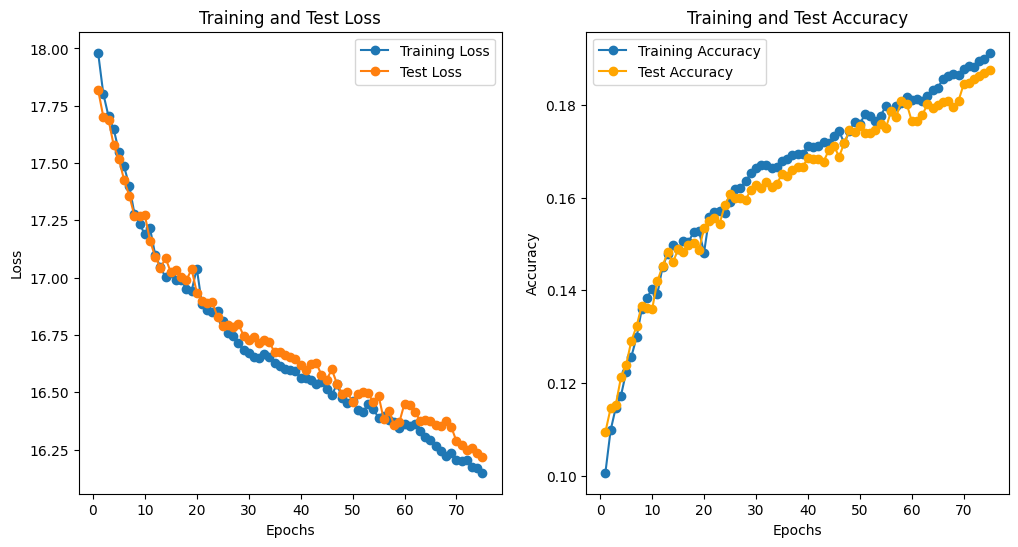

	Accuracy: 0.1875
	Precision Weighted: 0.12375443597183003
	Recall Weighted: 0.1875
	F1-Score Weighted: 0.12172236322061458


{'Accuracy': 0.1875,
 'Precision': 0.12375443597183003,
 'Recall': 0.1875,
 'F1 Score': 0.12172236322061458,
 'Confusion Matrix': array([[  2, 235,   0,   0, 227,  44,  93,   0,   0, 399],
        [  1, 274,   0,   1,  80,  88, 121,   0,   1, 434],
        [  6, 171,   0,   4, 382,  99, 174,   0,   2, 162],
        [ 10, 157,   0,   2, 281, 164, 218,   0,   0, 168],
        [  3, 112,   0,   4, 492, 102, 160,   0,   0, 127],
        [  6, 151,   0,   5, 278, 217, 223,   0,   1, 119],
        [  6, 150,   1,   2, 287, 179, 281,   0,   1,  93],
        [ 10, 107,   0,   1, 317, 137, 168,   0,   0, 260],
        [  0, 192,   0,   1,  89,  36,  66,   0,   1, 615],
        [  3, 167,   0,   0,  72,  55,  97,   0,   0, 606]]),
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.04      0.00      0.00      1000\n           1       0.16      0.27      0.20      1000\n           2       0.00      0.00      0.00      1000\n           3       0

In [ ]:
# Create the Final neural network

input_dimension = X_train_2d.shape[1]
output_dimension = y_train_onehot.shape[1]

network = NeuralNetwork(learning_rate = 0.1)
network.add_component(Dense_Layer(input_dimension, 32))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(32,64))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(64,32))
network.add_component(Activation_ReLU())
network.add_component(Dense_Layer(32, output_dimension))
network.add_component(Activation_Softmax())

# Train the neural network
network.train(X_train_2d, y_train_onehot,X_test_2d,y_test_onehot, epochs=75,verbose = True)

# After training, you can use the network for predictions
predictions = network.predict(X_test_2d, output_dimension)

# Evaluate the accuracy of the trained model
y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

metrics = evaluate_classification_metrics(y_test,y_pred,True)
metrics

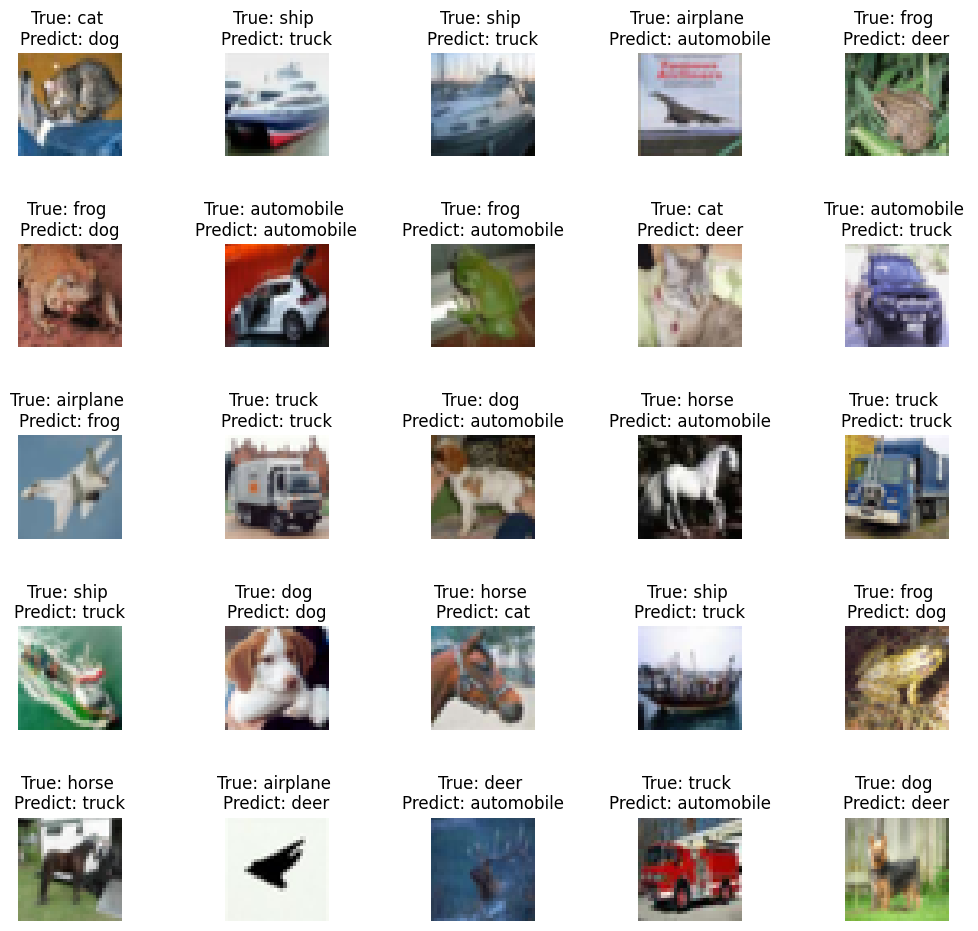

In [ ]:
# Visualize the outputs in the validation set, checking some examples of right and wrong classification

fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_test[i]], labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)